# SEGMENTACION CONSUMO ENERGIA (a.k.a. Energy Dissagragation / NILM)
- Dataset: REDD (The Reference Energy Disaggregation Data Set) - Energy consumption data of 6 houses.
- Algorithms: Testeo algoritmos de Aprendizaje Supervisado para extraer consumos individuales a partir contador principal (Ej. determinar consumo nevera a partir del consumo global)
- NOTA 1: El Sistema eléctrico USA no es Fase-Neutro, sino Fase-Fase, de ahí que existan dos "mains" (contadores)
- NOTA 2: se entrenan diferentes cargas correspondientes a una casa 1-6 (test) y se valida la predicción
- NOTA 3: El Dataset REDD/LowFreq debe estar en la carpeta GDrive: /content/drive/My Drive/DesagregacionEnergia/REDD Dataset/low_freq
## Empezando: Carga datos Dataset

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import time
import math
import warnings
from pathlib import Path # includes glob
#import glob             # Unix pathname pattern expansion, Ex. glob.glob('**/*.txt', recursive=True)
import pickle
warnings.filterwarnings("ignore")
# import altair as alt
import os
import seaborn

In [8]:
directory = os.getcwd()
pathdatos = Path(directory +'\low_freq')

In [9]:
# Defino Funciones para la lectura datos del Dataset REDD
#       house = Entero con Nº de casa

# Define PATH ficheros Casa Seleccionada.-
#Crea una ruta de ubucación del archivo casa_i
def path_house(pathdatos, house):
      """pathdatos -> (Path Object) directorio base todas casas
      house -> (int o string) Nº de casa"""
      #Concatena el ditectorio con la carpeta de cada casa
      return pathdatos / f'house_{house}'

# Lectura Fichero Labels con definición diferentes circuitos.-
#Retorna un diccionario con los nombres de electrodomesticos como value
# y como keys los numeros del 1 al 20
# Lectura Fichero Labels con definición diferentes circuitos.-
def read_label(pathhouse):
    #Crea un diccionario de etiquetas vacio
    label = {}
    #Concatena las rutas de cada casa dada con el archivo labels.dat que 
    #contiene las etiquetas de las lecturas
    hi = pathhouse / 'labels.dat'
    #Carga la dirección general creada en hi
    with open(hi) as f:
        #Ahora lee los valores que se encuentran dentro del archivo por cada linea
        for line in f:
            #Separa las componentes de palabras en el valor line usa como separador un espacio
            splitted_line = line.split(' ')
            #Guarda las palabras encontradas usando el indice como key y el nombre como value
            label[int(splitted_line[0])] = splitted_line[1].strip() + '_' + splitted_line[0]
    #Retorna el diccionario con las etiquetas
    return label

# Función construye Dataframe datos casa seleccionada.-
def read_merge_data(pathhouse):
    file = pathhouse / 'channel_1.dat'
    labels = read_label(pathhouse)
    
    df = pd.read_table(file, sep = ' ', names = ['unix_time', labels[1]], 
                                        dtype = {'unix_time': 'int64', labels[1]:'float64'}) 
    
    canales  = pathhouse.glob('channel*')   # Generador (solo puede leerse una vez!)
    num_apps = len(list(canales))           # Numero de circuitos
    
    for i in range(2, num_apps + 1):
        file = pathhouse / f'channel_{i}.dat'
        data = pd.read_table(file, sep = ' ', names = ['unix_time', labels[i]], 
                                              dtype = {'unix_time': 'int64', labels[i]:'float64'})
        df = pd.merge(df, data, how = 'inner', on = 'unix_time')
        # inner=mezcla columnas comunues
        # merge = une dataframes
    
    columns = list(df.columns)
    
    # Vamos a añadir  siguientes variables sabemos mucha influencia en consumo:
    #    Tiempo -- Timestamp
    #    M - mes del año 
    #    h - hora del dia (por ejemplo iluminación depende del dia)
    #    D - dia del mes (en principio no debe influir mucho)
    #    m - minuto del diia
    #    d - Dia de la semana (L, M, X, J, V, S, D)  
    columns = list(df.columns)
    df['timestamp'] = df['unix_time'].astype("datetime64[s]")
    df['M'] = df['timestamp'].dt.month
    df['d'] = df['timestamp'].dt.day
    df['h'] = df['timestamp'].dt.hour
    df['m'] = df['timestamp'].dt.minute
    df = df[['timestamp', 'M', 'd', 'h', 'm' ] + columns]
    
    # mains_0 = mains_1 + mains_2
    #df['mains_0'] = df['mains_1'] + df['mains_2']
    df['mains_0'] = df[columns[3:]].sum(axis=1)
    
    # ordenando las columnas
    df = df[['timestamp', 'M', 'd', 'h', 'm', 'mains_0'] + columns]
    
    df = df.set_index(df['timestamp'].values)
    df.drop(['unix_time','timestamp'], axis=1, inplace=True)
    
    return df

In [10]:
print (type(read_label))

<class 'function'>


In [11]:
# TEST: Carga label para SOLO una Casa
pathcasa = path_house(pathdatos, 1)     # Casa Nº1
labels = read_label(pathcasa)           # Leo datos casa Nº1

print(type(pathcasa))
print(pathcasa)
print(type(labels))
print(labels)

<class 'pathlib.WindowsPath'>
C:\Users\josel\REDD_Pruebas\low_freq\house_1
<class 'dict'>
{1: 'mains_1', 2: 'mains_2', 3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'washer_dryer_19', 20: 'washer_dryer_20'}


In [12]:
# Cargo Labels+Datos(Dataframes) casas 1 y 2: (Tarda un poco....)
#     COLUMNAS: Labels (Circuitos)
#     FILAS: timestamp + Potencia (W) para cada label
# DFS es un Diccionario incluye Num Casa->Dataframes
#%%time
dfs = {}

for i in range(1,3):
    pathcasa = path_house(pathdatos, i)
    dfs[f'labels_{i}'] = read_label(pathcasa)
    dfs[i] = read_merge_data(pathcasa)

In [13]:
# Inspeccionamos Diccionario de Dataframes Generado
# dfs = {'labels_1': {df.house1},
#        'labels_2': {df.house2} }
print(type(dfs))
#print(dfs)
print(dfs[1].head())
print(dfs[2].head())

<class 'dict'>
                     M   d   h   m  mains_0  mains_1  mains_2  oven_3  oven_4  \
2011-04-18 13:22:13  4  18  13  22    261.0   222.20   118.83     0.0     0.0   
2011-04-18 13:22:16  4  18  13  22    261.0   223.17   119.19     0.0     0.0   
2011-04-18 13:22:20  4  18  13  22    262.0   223.60   118.92     0.0     0.0   
2011-04-18 13:22:23  4  18  13  22    262.0   222.91   119.16     0.0     0.0   
2011-04-18 13:22:26  4  18  13  22    261.0   222.94   118.83     0.0     0.0   

                     refrigerator_5  ...  microwave_11  bathroom_gfi_12  \
2011-04-18 13:22:13             6.0  ...           5.0              1.0   
2011-04-18 13:22:16             6.0  ...           5.0              1.0   
2011-04-18 13:22:20             6.0  ...           5.0              1.0   
2011-04-18 13:22:23             6.0  ...           5.0              1.0   
2011-04-18 13:22:26             6.0  ...           5.0              1.0   

                     electric_heat_13  stove_14

Guardamos el df con las columnas calculadas para no tardar más en las siguientes ocasiones. Pickle funciona solo en Python, tambien podíamos usar un formato estandar H5 para guardar datos heterogeneos https://www.hdfgroup.org/downloads/hdf5/

In [17]:
#Abre el archivo para escribir sobre el, si no existe lo crea. wb = escribir en binario
with open(pathdatos/'casasJRus.pkl','wb') as file:
    #Envia "volca" los datos al nuevo archivo
    pickle.dump(dfs,file=file)

Leyendo los datos del disco

In [30]:
#Abre el archivo para su lectura 
with open(pathdatos/'casasJRus.pkl','rb') as file:
    dfs = pickle.load(file)
print(f'dfs {dfs.keys()}')
print('*'*80)
print(f'dfs {dfs["labels_1"]}')
print('*'*80)
print(f'dfs {dfs[1].index}')
print('*'*80)
print(f'dfs {type(dfs[1])}')
print('*'*80)
print(f'dfs {dfs[1].keys()}')

dfs dict_keys(['labels_1', 1, 'labels_2', 2])
********************************************************************************
dfs {1: 'mains_1', 2: 'mains_2', 3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'washer_dryer_19', 20: 'washer_dryer_20'}
********************************************************************************
dfs DatetimeIndex(['2011-04-18 13:22:13', '2011-04-18 13:22:16',
               '2011-04-18 13:22:20', '2011-04-18 13:22:23',
               '2011-04-18 13:22:26', '2011-04-18 13:22:30',
               '2011-04-18 13:22:33', '2011-04-18 13:22:37',
               '2011-04-18 13:22:40', '2011-04-18 13:22:44',
               ...
               '2011-05-24 19:56:03', '2011-05-24 19:56:06'

In [38]:
casa = dfs[1]
print(f'{casa}')

                     M   d   h   m  mains_0  mains_1  mains_2  oven_3  oven_4  \
2011-04-18 13:22:13  4  18  13  22    261.0   222.20   118.83     0.0     0.0   
2011-04-18 13:22:16  4  18  13  22    261.0   223.17   119.19     0.0     0.0   
2011-04-18 13:22:20  4  18  13  22    262.0   223.60   118.92     0.0     0.0   
2011-04-18 13:22:23  4  18  13  22    262.0   222.91   119.16     0.0     0.0   
2011-04-18 13:22:26  4  18  13  22    261.0   222.94   118.83     0.0     0.0   
...                 ..  ..  ..  ..      ...      ...      ...     ...     ...   
2011-05-24 19:56:20  5  24  19  56    242.0   235.73    38.65     0.0     0.0   
2011-05-24 19:56:23  5  24  19  56    240.0   235.03    38.66     0.0     0.0   
2011-05-24 19:56:27  5  24  19  56    243.0   235.46    38.61     0.0     0.0   
2011-05-24 19:56:30  5  24  19  56    242.0   235.98    38.77     0.0     0.0   
2011-05-24 19:56:34  5  24  19  56    241.0   235.29    38.83     0.0     0.0   

                     refrig

## Visualización Datos del dataframe
### Comprobamos si suma cargas = suma contadores (mains0 = mains_1 + mains_2)
- mains0 es la sumatoria hecha al unir las columnas en la función read_merge_data(), este proceso lo hace para verificar que al unir las columnas los valores de las sumatorias coincidan con la suma de las columnas de los dispositivos, osea a partir de la columna 3. 


In [36]:
numcasa = 1                  # Nº de Casa a Visualizar
#Dataframe keys incluye valores de las columnas D, M ...
casa = dfs[numcasa].copy()   # Nuevo dataframe que contiene datos casa seleccionada
columnas = dfs[f'labels_{numcasa}'].copy()
print(f'Columnas {columnas}')
del columnas[1]
del columnas[2]
print('*'*80)
print(f'Columnas {columnas}')
nombre_lineas = list(columnas.values())
#print(nombre_lineas)

casa['error'] = casa['mains_0'] - casa[nombre_lineas].sum(axis=1)
casa['error']

#print(type(casa))
#print(casa.head(10))

Columnas {1: 'mains_1', 2: 'mains_2', 3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'washer_dryer_19', 20: 'washer_dryer_20'}
********************************************************************************
Columnas {3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'washer_dryer_19', 20: 'washer_dryer_20'}


2011-04-18 13:22:13    0.0
2011-04-18 13:22:16    0.0
2011-04-18 13:22:20    0.0
2011-04-18 13:22:23    0.0
2011-04-18 13:22:26    0.0
                      ... 
2011-05-24 19:56:20    0.0
2011-05-24 19:56:23    0.0
2011-05-24 19:56:27    0.0
2011-05-24 19:56:30    0.0
2011-05-24 19:56:34    0.0
Name: error, Length: 406748, dtype: float64

Generando un fichero casas.csv para verificación manual de los errores sumando las líneas. Este archivo tiene todas las medidas tomadas en un mismo instante de tiempo condensadas en filas

In [39]:
with open(pathdatos/'casas.csv','w') as file:
    casa.head(100).to_csv(file)

In [40]:
print(nombre_lineas)
casa['error'] = casa['mains_0'] - casa[nombre_lineas].sum(axis=1)
casa['error']
casa['errorrelativo'] = casa['error']/casa['mains_0']*100
print(casa[['error','errorrelativo']].head())

['oven_3', 'oven_4', 'refrigerator_5', 'dishwaser_6', 'kitchen_outlets_7', 'kitchen_outlets_8', 'lighting_9', 'washer_dryer_10', 'microwave_11', 'bathroom_gfi_12', 'electric_heat_13', 'stove_14', 'kitchen_outlets_15', 'kitchen_outlets_16', 'lighting_17', 'lighting_18', 'washer_dryer_19', 'washer_dryer_20']
                     error  errorrelativo
2011-04-18 13:22:13    0.0            0.0
2011-04-18 13:22:16    0.0            0.0
2011-04-18 13:22:20    0.0            0.0
2011-04-18 13:22:23    0.0            0.0
2011-04-18 13:22:26    0.0            0.0


In [13]:
# Función plotea cada circuito (columna)
#casa, channel_i, separador de columnas, rango minimo y maximo o automatico del histograma
def muestra_linea(casa, linea, num_bins = 20, range = None):
      
    print(f'Información sobre la línea: {linea}')
    print(casa[linea].describe())
    
    n, bins, patches = plt.hist(casa[linea], num_bins, range=range,facecolor='blue', alpha=0.5)
    plt.show()
  
    plt.plot(casa[linea])
    plt.show()

Información sobre la línea: oven_3
count    406748.000000
mean          6.206361
std         100.255472
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1725.000000
Name: oven_3, dtype: float64


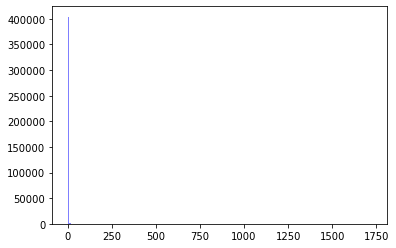

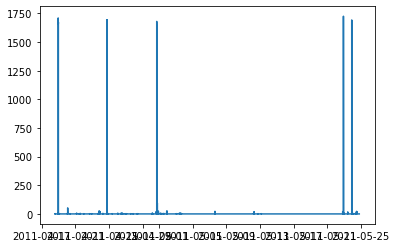

In [14]:
# TEST: Muestra carga 'oven_3'
muestra_linea(casa,'oven_3', num_bins=200, range = None)

### Mostrando información de cada línea disponible

oven_3
Información sobre la línea: oven_3
count    406748.000000
mean          6.206361
std         100.255472
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1725.000000
Name: oven_3, dtype: float64


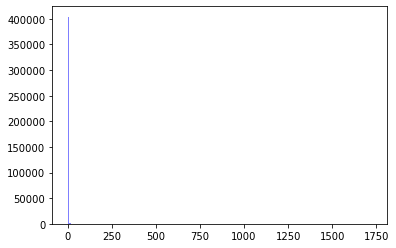

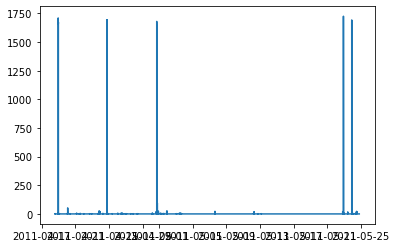

oven_4
Información sobre la línea: oven_4
count    406748.000000
mean          7.742122
std         126.784783
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        2565.000000
Name: oven_4, dtype: float64


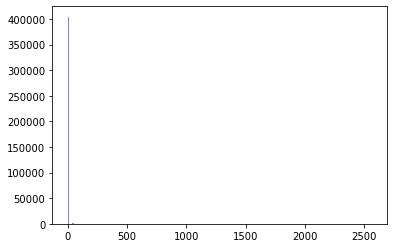

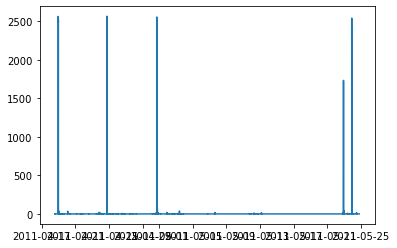

refrigerator_5
Información sobre la línea: refrigerator_5
count    406748.000000
mean         55.504096
std          89.149730
min           0.000000
25%           6.000000
50%           7.000000
75%         181.000000
max        2359.000000
Name: refrigerator_5, dtype: float64


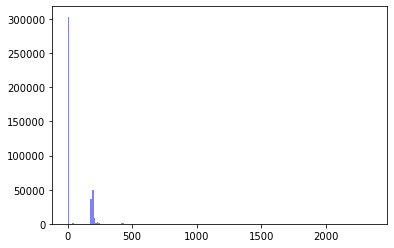

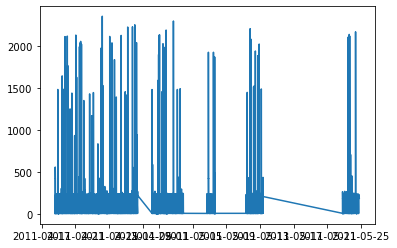

dishwaser_6
Información sobre la línea: dishwaser_6
count    406748.000000
mean         24.917698
std         149.718191
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1422.000000
Name: dishwaser_6, dtype: float64


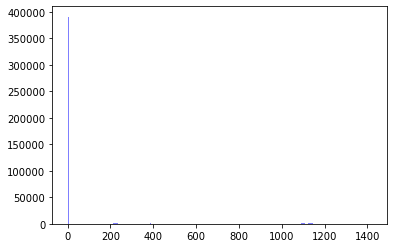

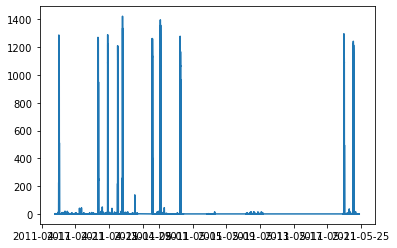

kitchen_outlets_7
Información sobre la línea: kitchen_outlets_7
count    406748.000000
mean         21.236535
std           1.958581
min           7.000000
25%          20.000000
50%          21.000000
75%          22.000000
max          59.000000
Name: kitchen_outlets_7, dtype: float64


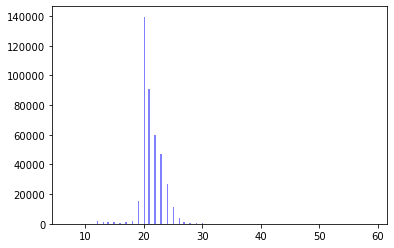

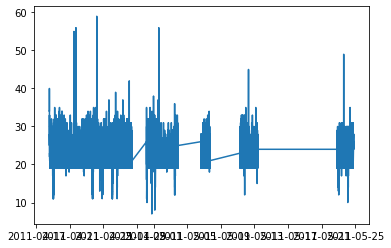

kitchen_outlets_8
Información sobre la línea: kitchen_outlets_8
count    406748.000000
mean         28.331126
std          16.799793
min           3.000000
25%          21.000000
50%          22.000000
75%          23.000000
max        1550.000000
Name: kitchen_outlets_8, dtype: float64


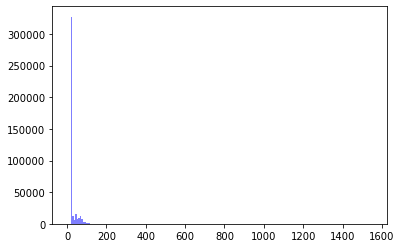

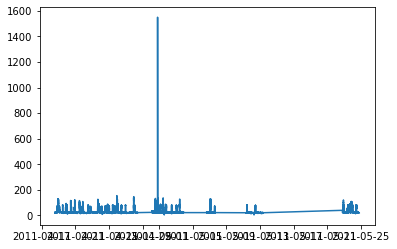

lighting_9
Información sobre la línea: lighting_9
count    406748.000000
mean         43.300198
std          45.931033
min           0.000000
25%           2.000000
50%          42.000000
75%          81.000000
max         363.000000
Name: lighting_9, dtype: float64


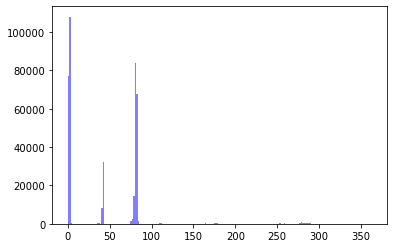

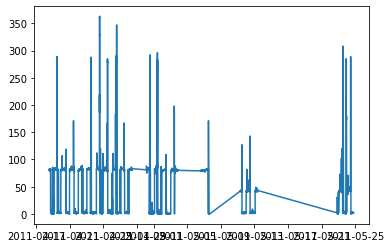

washer_dryer_10
Información sobre la línea: washer_dryer_10
count    406748.000000
mean          3.912454
std          42.428219
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4475.000000
Name: washer_dryer_10, dtype: float64


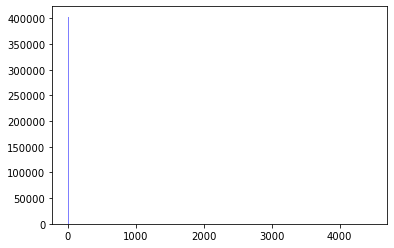

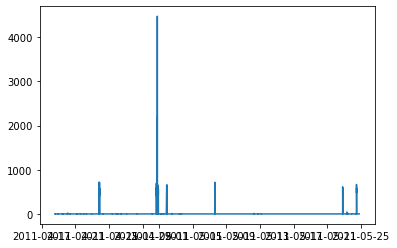

microwave_11
Información sobre la línea: microwave_11
count    406748.000000
mean         22.259810
std         164.229323
min           1.000000
25%           4.000000
50%           4.000000
75%           4.000000
max        2906.000000
Name: microwave_11, dtype: float64


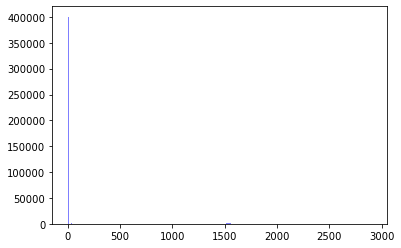

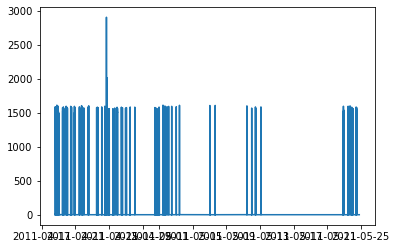

bathroom_gfi_12
Información sobre la línea: bathroom_gfi_12
count    406748.000000
mean          6.998749
std          97.137862
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        1686.000000
Name: bathroom_gfi_12, dtype: float64


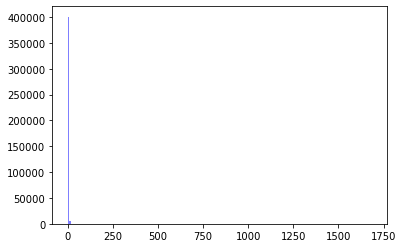

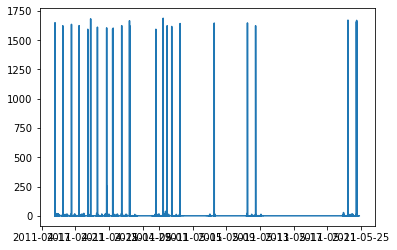

electric_heat_13
Información sobre la línea: electric_heat_13
count    406748.000000
mean          0.127590
std           1.073337
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         192.000000
Name: electric_heat_13, dtype: float64


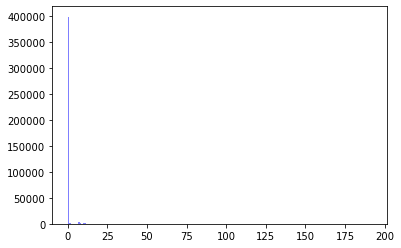

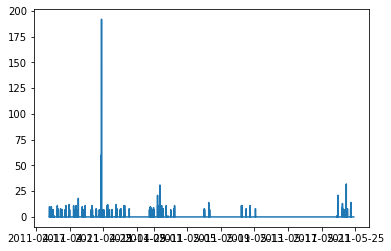

stove_14
Información sobre la línea: stove_14
count    406748.000000
mean          0.115049
std           0.872150
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          36.000000
Name: stove_14, dtype: float64


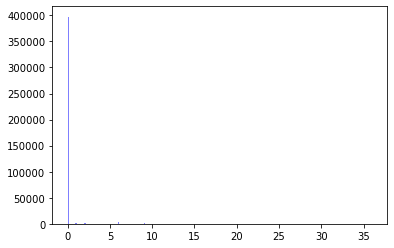

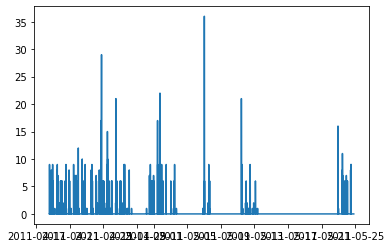

kitchen_outlets_15
Información sobre la línea: kitchen_outlets_15
count    406748.000000
mean          5.501908
std          68.599415
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        1118.000000
Name: kitchen_outlets_15, dtype: float64


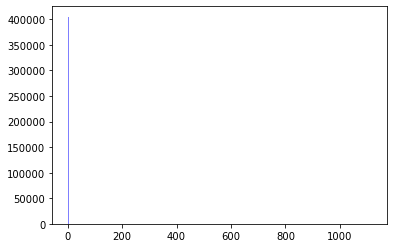

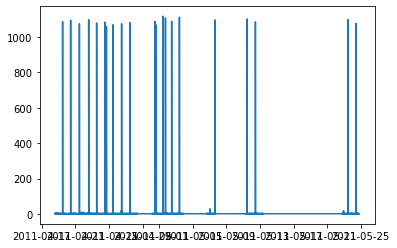

kitchen_outlets_16
Información sobre la línea: kitchen_outlets_16
count    406748.000000
mean          2.028563
std          54.460008
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1585.000000
Name: kitchen_outlets_16, dtype: float64


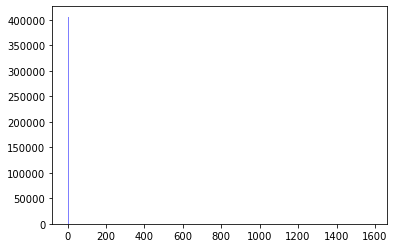

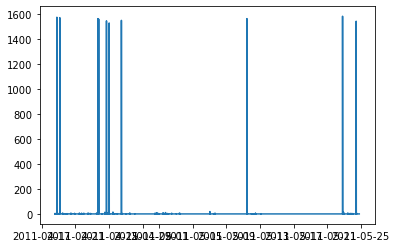

lighting_17
Información sobre la línea: lighting_17
count    406748.000000
mean         18.042355
std          29.972681
min           0.000000
25%           0.000000
50%           0.000000
75%          64.000000
max         112.000000
Name: lighting_17, dtype: float64


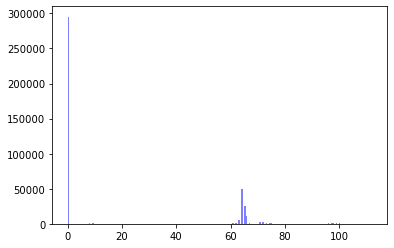

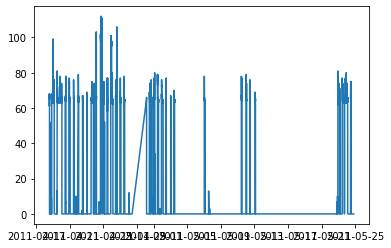

lighting_18
Información sobre la línea: lighting_18
count    406748.000000
mean         13.307077
std          22.678864
min           0.000000
25%           1.000000
50%           1.000000
75%           9.000000
max          90.000000
Name: lighting_18, dtype: float64


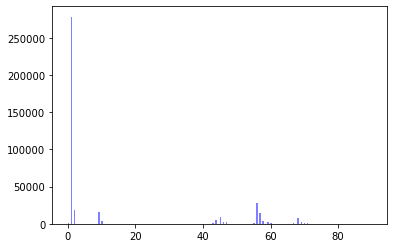

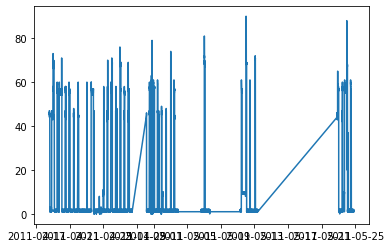

washer_dryer_19
Información sobre la línea: washer_dryer_19
count    406748.000000
mean          0.000080
std           0.029595
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          17.500000
Name: washer_dryer_19, dtype: float64


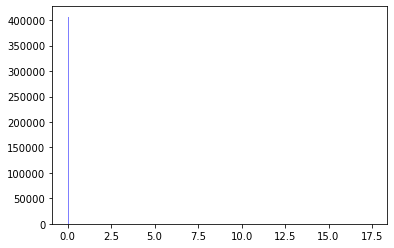

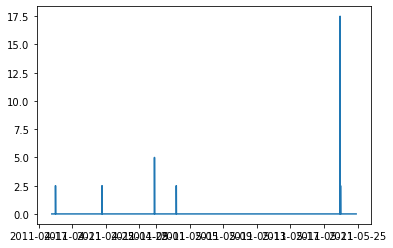

washer_dryer_20
Información sobre la línea: washer_dryer_20
count    406748.000000
mean         31.854262
std         291.610783
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        3222.500000
Name: washer_dryer_20, dtype: float64


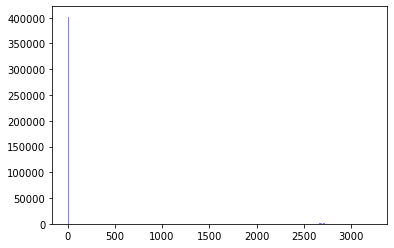

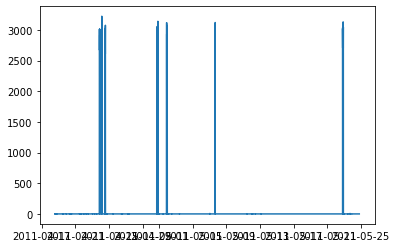

In [15]:
for nombre_linea in nombre_lineas:
    print(nombre_linea)
    muestra_linea(casa,nombre_linea, num_bins=200, range = None)

## AñadiendoNuevo dato: tiempo funcionamiento carga

In [41]:
delta = [np.timedelta64(0, 's')] + list(casa.index[1:]- casa.index[0:-1])
# meto el objeto numpy [np.timedelta64] entre corchetes para convertirlo en una lista
# delta es una lista compuesta de:
#   primer elemento 0 - para mantener las longitudes de delta con la de Casa
#   Siguientes elementos fila(i+1)- fila(i) 

numdata = len(delta)
casa['deltatime'] = delta
# hay un problema de tipos con la variable delta. así que lo incorporamos al 
# df casa y reescalo en la columna deltatime
casa['deltatime'] /= np.timedelta64(1,'s')

In [42]:
casa.head(5)

M   d   h   m  mains_0  mains_1  mains_2  oven_3  oven_4  \
2011-04-18 13:22:13  4  18  13  22    261.0   222.20   118.83     0.0     0.0   
2011-04-18 13:22:16  4  18  13  22    261.0   223.17   119.19     0.0     0.0   
2011-04-18 13:22:20  4  18  13  22    262.0   223.60   118.92     0.0     0.0   
2011-04-18 13:22:23  4  18  13  22    262.0   222.91   119.16     0.0     0.0   
2011-04-18 13:22:26  4  18  13  22    261.0   222.94   118.83     0.0     0.0   

                     refrigerator_5  ...  stove_14  kitchen_outlets_15  \
2011-04-18 13:22:13             6.0  ...       0.0                 2.0   
2011-04-18 13:22:16             6.0  ...       0.0                 2.0   
2011-04-18 13:22:20             6.0  ...       0.0                 2.0   
2011-04-18 13:22:23             6.0  ...       0.0                 1.0   
2011-04-18 13:22:26             6.0  ...       0.0                 2.0   

                     kitchen_outlets_16  lighting_17  lighting_18  \
2011-04-18 13:22:13                 0.0         65.0         46.0   
2011-04-18 13:22:16                 0.0         65.0         46.0   
2011-04-18 13:22:20                 0.0         65.0         46.0   
2011-04-18 13:22:23                 0.0         65.0         46.0   
2011-04-18 13:22:26                 0.0         65.0         46.0   

                     washer_dryer_19  washer_dryer_20  error  errorrelativo  \
2011-04-18 13:22:13              0.0              0.0    0.0            0.0   
2011-04-18 13:22:16              0.0              0.0    0.0            0.0   
2011-04-18 13:22:20              0.0              0.0    0.0            0.0   
2011-04-18 13:22:23              0.0              0.0    0.0            0.0   
2011-04-18 13:22:26              0.0              0.0    0.0            0.0   

                     deltatime  
2011-04-18 13:22:13        0.0  
2011-04-18 13:22:16        3.0  
2011-04-18 13:22:20        4.0  
2011-04-18 13:22:23        3.0  
2011-04-18 13:22:26        3.0  

[5 rows x 28 columns]

In [43]:
# Vamos a hacer unos pruebas:
lista =  [0, 1, 1, 2,  1,  2,  0,  0]
deltas = [0, 3, 3, 3, 12, 3, 3, 3]
output = [0]*len(lista)
print(type(lista))
print(type(delta))
for it in range(len(lista)-1):
    if lista[it]>0 and deltas[it+1]< 10 :
        output[it+1] = output[it] + deltas[it+1]
output

<class 'list'>
<class 'list'>


[0, 0, 3, 6, 0, 3, 6, 0]

In [44]:
print(columnas)
# eliminando los valores NA y remplazo por 0.0
casa.fillna(0.0)

for columna in columnas.values():
    print(columna)
    nombre_columna_len = columna+'_len'
  
    if columna != 'refrigerator_5':
        continue

    # creamos nueva columna
    
    casa[nombre_columna_len] = 0.0
  
    break
    
casa.head(5)

{3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'washer_dryer_19', 20: 'washer_dryer_20'}
oven_3
oven_4
refrigerator_5


M   d   h   m  mains_0  mains_1  mains_2  oven_3  oven_4  \
2011-04-18 13:22:13  4  18  13  22    261.0   222.20   118.83     0.0     0.0   
2011-04-18 13:22:16  4  18  13  22    261.0   223.17   119.19     0.0     0.0   
2011-04-18 13:22:20  4  18  13  22    262.0   223.60   118.92     0.0     0.0   
2011-04-18 13:22:23  4  18  13  22    262.0   222.91   119.16     0.0     0.0   
2011-04-18 13:22:26  4  18  13  22    261.0   222.94   118.83     0.0     0.0   

                     refrigerator_5  ...  kitchen_outlets_15  \
2011-04-18 13:22:13             6.0  ...                 2.0   
2011-04-18 13:22:16             6.0  ...                 2.0   
2011-04-18 13:22:20             6.0  ...                 2.0   
2011-04-18 13:22:23             6.0  ...                 1.0   
2011-04-18 13:22:26             6.0  ...                 2.0   

                     kitchen_outlets_16  lighting_17  lighting_18  \
2011-04-18 13:22:13                 0.0         65.0         46.0   
2011-04-18 13:22:16                 0.0         65.0         46.0   
2011-04-18 13:22:20                 0.0         65.0         46.0   
2011-04-18 13:22:23                 0.0         65.0         46.0   
2011-04-18 13:22:26                 0.0         65.0         46.0   

                     washer_dryer_19  washer_dryer_20  error  errorrelativo  \
2011-04-18 13:22:13              0.0              0.0    0.0            0.0   
2011-04-18 13:22:16              0.0              0.0    0.0            0.0   
2011-04-18 13:22:20              0.0              0.0    0.0            0.0   
2011-04-18 13:22:23              0.0              0.0    0.0            0.0   
2011-04-18 13:22:26              0.0              0.0    0.0            0.0   

                     deltatime  refrigerator_5_len  
2011-04-18 13:22:13        0.0                 0.0  
2011-04-18 13:22:16        3.0                 0.0  
2011-04-18 13:22:20        4.0                 0.0  
2011-04-18 13:22:23        3.0                 0.0  
2011-04-18 13:22:26        3.0                 0.0  

[5 rows x 29 columns]

In [45]:
casa['refrigerator_5_len']

2011-04-18 13:22:13    0.0
2011-04-18 13:22:16    0.0
2011-04-18 13:22:20    0.0
2011-04-18 13:22:23    0.0
2011-04-18 13:22:26    0.0
                      ... 
2011-05-24 19:56:20    0.0
2011-05-24 19:56:23    0.0
2011-05-24 19:56:27    0.0
2011-05-24 19:56:30    0.0
2011-05-24 19:56:34    0.0
Name: refrigerator_5_len, Length: 406748, dtype: float64

## Entrenamiento con KERAS con "Restricciones"  
Copiado de: https://stackoverflow.com/questions/51746005/how-to-restrict-the-sum-of-predicted-outputs-in-a-neural-network-regression-usin

In [20]:
#pip install keras

In [21]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model

# Datos y etiquetas aleatorios
features = np.random.rand(100, 20)
labels = np.random.rand(100, 3)

# Modelo de red neuronal simple con tres salidas para la casa 1
input_layer = Input((20,)) #Entrada correspondiente a 20 dispositivos
hidden_layer = Dense(16)(input_layer) #hiden / oculta
output_layer = Dense(3)(hidden_layer) #Salida

# Modelo fabricado con keras 
model = Model(inputs=input_layer, outputs=output_layer)

# Función de perdida personalizada
def custom_loss(y_true, y_pred):
    # Normal MSE loss error cuadratico medio
    mse = K.mean(K.square(y_true-y_pred), axis=-1)
    # Loss that penalizes differences between sum(predictions) and sum(labels)
    sum_constraint = K.square(K.sum(y_pred, axis=-1) - K.sum(y_true, axis=-1))

    return(mse+sum_constraint)

# Compile with custom loss
model.compile(loss=custom_loss, optimizer='sgd')
model.fit(features, labels, epochs=1, verbose=1) 
import numpy as np
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model

# Some random training data and labels
features = np.random.rand(100, 20)
labels = np.random.rand(100, 3)

# Simple neural net with three outputs
input_layer = Input((20,))
hidden_layer = Dense(16)(input_layer)
output_layer = Dense(3)(hidden_layer)

# Model
model = Model(inputs=input_layer, outputs=output_layer)

# Write a custom loss function
def custom_loss(y_true, y_pred):
    # Normal MSE loss
    mse = K.mean(K.square(y_true-y_pred), axis=-1)
    # Loss that penalizes differences between sum(predictions) and sum(labels)
    sum_constraint = K.square(K.sum(y_pred, axis=-1) - K.sum(y_true, axis=-1))

    return(mse+sum_constraint)

# Compile with custom loss
model.compile(loss=custom_loss, optimizer='sgd')
model.fit(features, labels, epochs=1, verbose=1)

4/4 [==============================] - 0s 747us/step - loss: 3.3802


### Train / Test Data

In [22]:
print(type(casa))
print(casa.describe())
print(casa.shape)
print(casa.shape[0])
print(casa.head())
print(casa.tail())

<class 'pandas.core.frame.DataFrame'>
                   M              d              h              m  \
count  406748.000000  406748.000000  406748.000000  406748.000000   
mean        4.423815      18.014877      11.326079      29.506060   
std         0.494162       8.896782       6.818514      17.295919   
min         4.000000       1.000000       0.000000       0.000000   
25%         4.000000      12.000000       5.000000      15.000000   
50%         4.000000      22.000000      11.000000      29.000000   
75%         5.000000      24.000000      17.000000      44.000000   
max         5.000000      30.000000      23.000000      59.000000   

             mains_0        mains_1        mains_2         oven_3  \
count  406748.000000  406748.000000  406748.000000  406748.000000   
mean      291.386034     227.353130     156.143288       6.206361   
std       515.188161     409.695428     425.762416     100.255472   
min        52.000000      51.870000      36.720000       0.00000

In [23]:
# Separate house data into train, validation and test data

# Genera los indices para trocear el dataset
train_length = int(casa.shape[0]*0.8)
test_length = int(casa.shape[0] - train_length)
total_length = int(casa.shape[0])
print(train_length, test_length, total_length)

# Genera los dataframe de train y test
train = casa[0: train_length]
test = casa[train_length: total_length]

# Vamos a chequear
print('train.shape: ', train.shape)
#print('val.shape: ', val.shape)
print('test.shape: ', test.shape)

325398 81350 406748
train.shape:  (325398, 29)
test.shape:  (81350, 29)


In [24]:
# Using mains_1, mains_2 to predict refrigerator
X_train1 = train[['mains_1','mains_2']].values
y_train1 = train['refrigerator_5'].values

X_test1 = test[['mains_1','mains_2']].values
y_test1 = test['refrigerator_5'].values

print(X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape)

(325398, 2) (325398,) (81350, 2) (81350,)


## Building Models
### Decision tree regression

In [25]:
# Definimos las funciones de error: MSE (Cuadratica) y MAE (Absoluta)
def mse_loss(y_predict, y):
    return np.mean(np.square(y_predict - y)) 

def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y))

print(type(mse_loss))
print(type(mae_loss))

<class 'function'>
<class 'function'>


House 1 data contain 23 days from 2011-04-18 to 2011-05-24.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-06', '2011-05-07', '2011-05-11', '2011-05-12', '2011-05-13', '2011-05-22', '2011-05-23', '2011-05-24'] 

House 2 data contain 16 days from 2011-04-18 to 2011-05-22.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-22'] 

<class 'dict'>
<class 'dict'>
<class 'pandas.core.frame.DataFrame'>
{1: ['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-06', '2011-05-07', '2011-05-11', '20

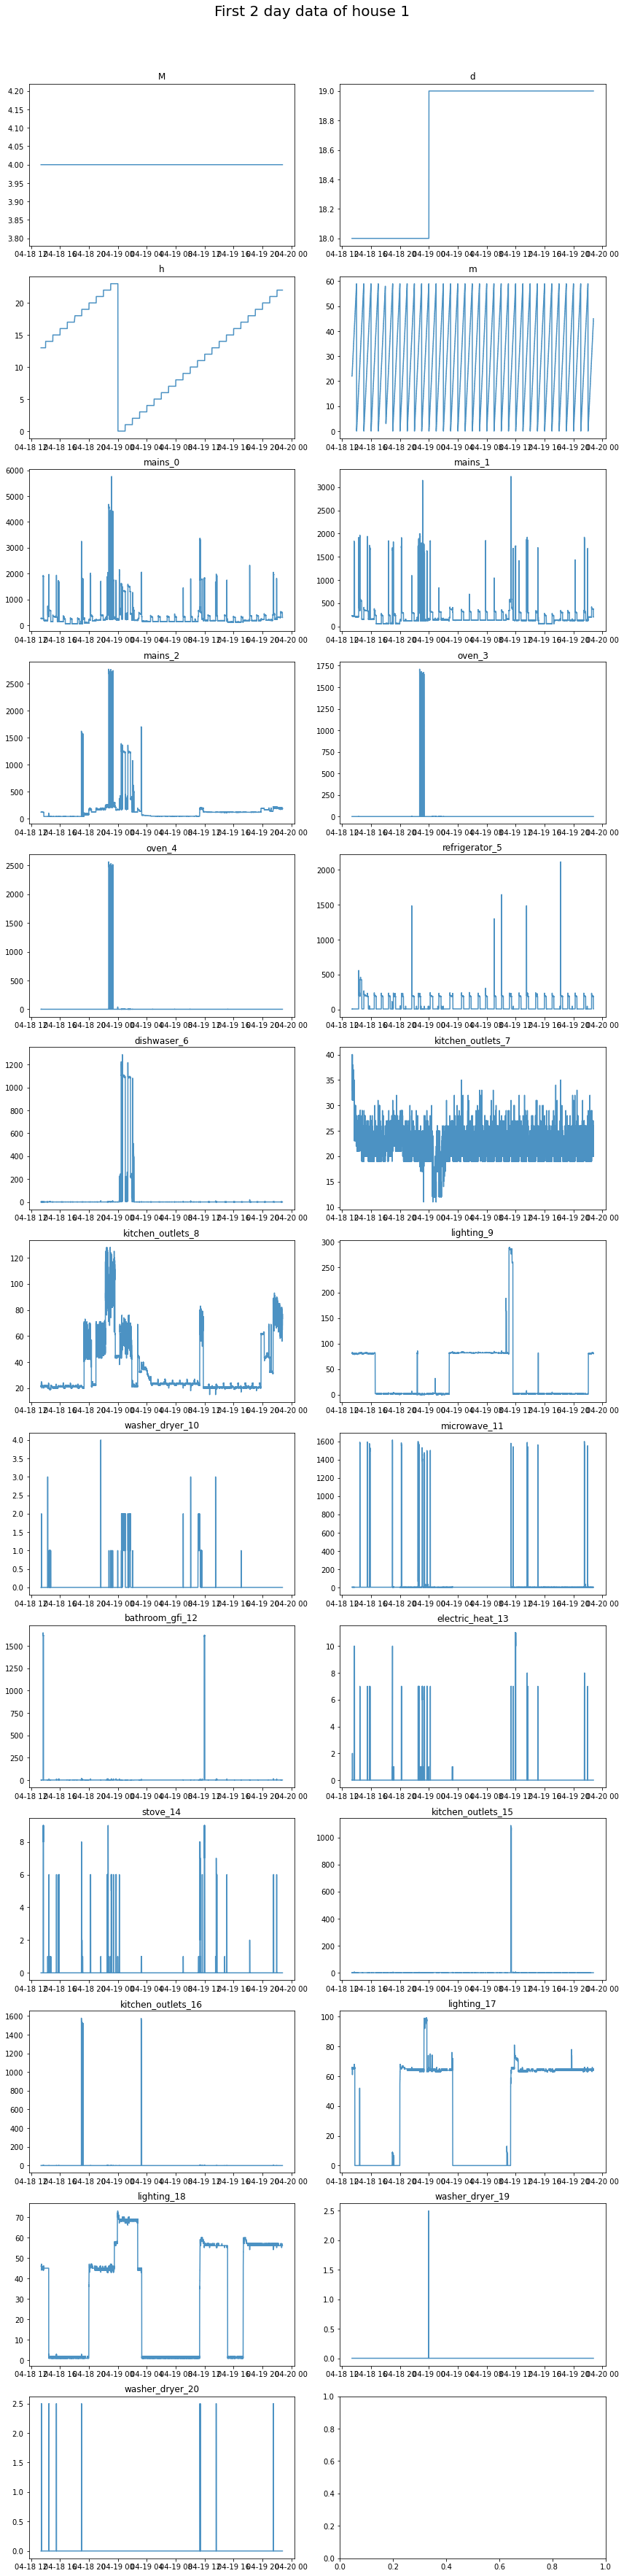

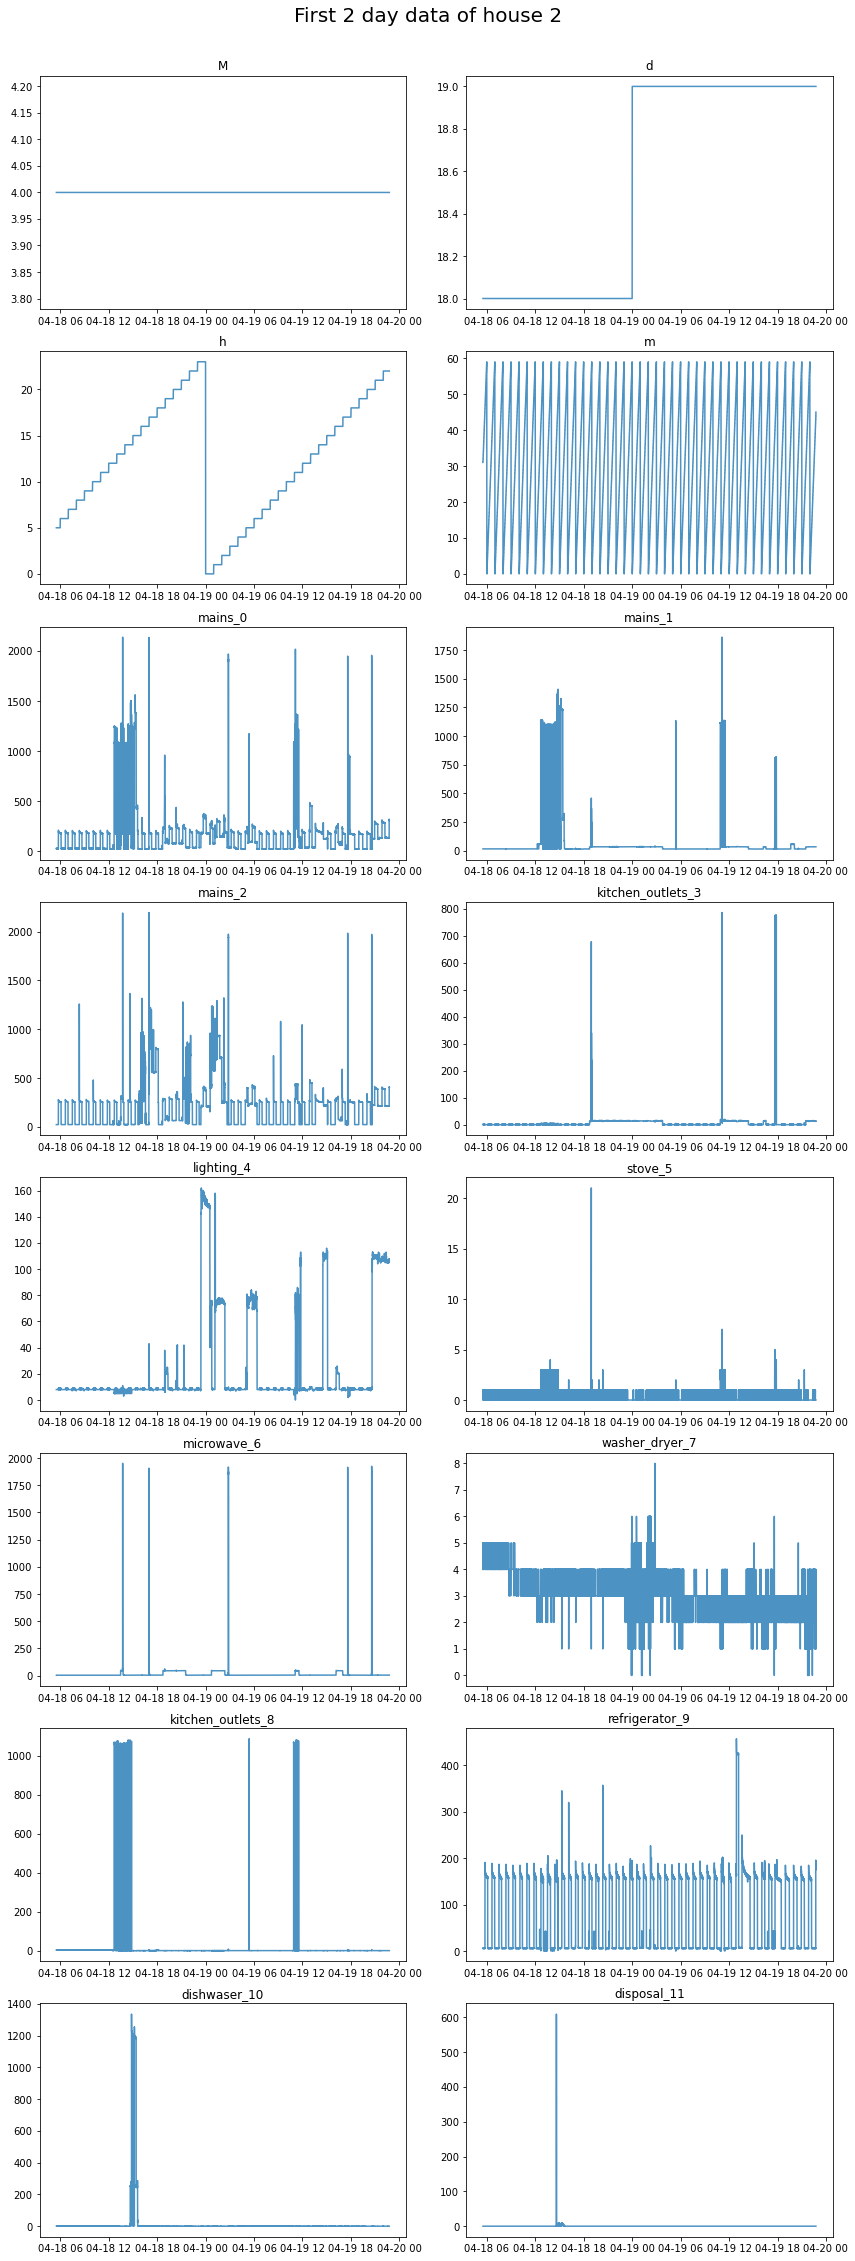

In [26]:
# Plot 2 first day data of house 1 and 2
def plot_df(df, title):
    apps = df.columns.values
    num_apps = len(apps) 
    fig, axes = plt.subplots((num_apps+1)//2,2, figsize=(12, num_apps*2))
    for i, key in enumerate(apps):
        axes.flat[i].plot(df[key], alpha = 0.8)
        axes.flat[i].set_title(key, fontsize = '12')
    plt.suptitle(title, fontsize = '20')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    
dates = {}
for i in range(1,3):
    dates[i] = [str(time)[:10] for time in dfs[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i,len(dates[i]),dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

print(type(dfs))
print(type(dates))

print(type(dfs[1]))
print(dates)
    
for i in range(1,3):
    plot_df(dfs[i][:dates[i][1]], 'First 2 day data of house {}'.format(i))

Text(0.5, 1.0, 'House 2')

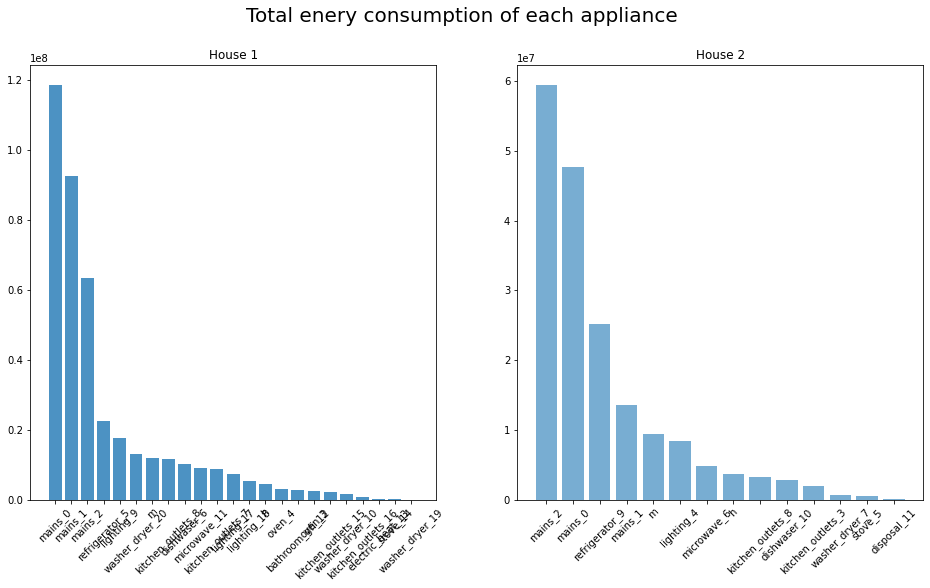

In [27]:

# HISTOGRAM Plot: total energy sonsumption of each appliance from two houses
fig, axes = plt.subplots(1,2,figsize=(16, 8))
plt.suptitle('Total enery consumption of each appliance', fontsize = 20)
cons1 = dfs[1][dfs[1].columns.values[2:]].sum().sort_values(ascending=False)
app1 = cons1.index
y_pos1 = np.arange(len(app1))
axes[0].bar(y_pos1, cons1.values,  alpha=0.8) 
plt.sca(axes[0])
plt.xticks(y_pos1, app1, rotation = 45)
plt.title('House 1')

cons2 = dfs[2][dfs[2].columns.values[2:]].sum().sort_values(ascending=False)
app2 = cons2.index
y_pos2 = np.arange(len(app2))
axes[1].bar(y_pos2, cons2.values, alpha=0.6)
plt.sca(axes[1])
plt.xticks(y_pos2, app2, rotation = 45)
plt.title('House 2')

Información sobre la línea: oven_3
count    406748.000000
mean          6.206361
std         100.255472
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1725.000000
Name: oven_3, dtype: float64


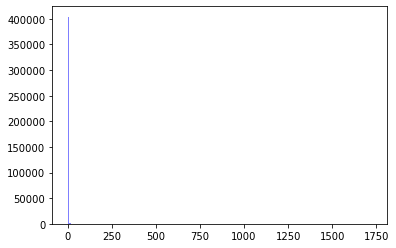

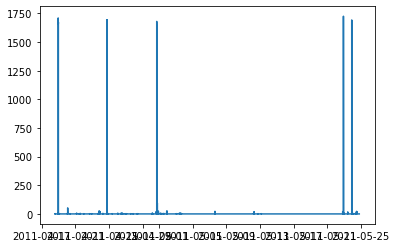

In [28]:
# CIRCUIT DATA DESCRIPTION
def muestra_linea(casa, linea, num_bins = 20, range = None):
    print(f'Información sobre la línea: {linea}')
  
    print(casa[linea].describe())
  
    n, bins, patches = plt.hist(casa[linea], num_bins, range=range,
                              facecolor='blue', alpha=0.5)
  
    plt.show()
  
    plt.plot(casa[linea])
    plt.show()
muestra_linea(dfs[1],'oven_3', num_bins=200, range = None)

In [29]:
# Separate house 1 data into train, validation and test data
df1_train = dfs[1][:dates[1][10]]
df1_val = dfs[1][dates[1][11]:dates[1][16]]
df1_test = dfs[1][dates[1][17]:]
print('df_train.shape: ', df1_train.shape)
print('df_val.shape: ', df1_val.shape)
print('df_test.shape: ', df1_test.shape)

df_train.shape:  (214816, 25)
df_val.shape:  (104875, 25)
df_test.shape:  (87057, 25)


In [30]:
# Using mains_1, mains_2 to predict refrigerator
X_train1 = df1_train[['mains_1','mains_2']].values
y_train1 = df1_train['refrigerator_5'].values
X_val1 = df1_val[['mains_1','mains_2']].values
y_val1 = df1_val['refrigerator_5'].values
X_test1 = df1_test[['mains_1','mains_2']].values
y_test1 = df1_test['refrigerator_5'].values
print(X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape)

(214816, 2) (214816,) (104875, 2) (104875,) (87057, 2) (87057,)


In [31]:
# Using decision tree regression, here we use validation data to turn the min_samples_split parameter
def mse_loss(y_predict, y):
    return np.mean(np.square(y_predict - y)) 
def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y)) 

min_samples_split=np.arange(2, 400, 10)
from sklearn.tree import DecisionTreeRegressor

def tree_reg(X_train, y_train, X_val, y_val, min_samples_split):
    clfs = []
    losses = []
    start = time.time()
    for split in min_samples_split:
        clf = DecisionTreeRegressor(min_samples_split = split)
        clf.fit(X_train, y_train)
        y_predict_val = clf.predict(X_val)
        clfs.append(clf)
        losses.append( mse_loss(y_predict_val, y_val) )
    print('Trainning time: ', time.time() - start)
    return clfs, losses
  
tree_clfs_1, tree_losses_1 = tree_reg(X_train1, y_train1, X_val1, y_val1, min_samples_split)

Trainning time:  22.572246074676514


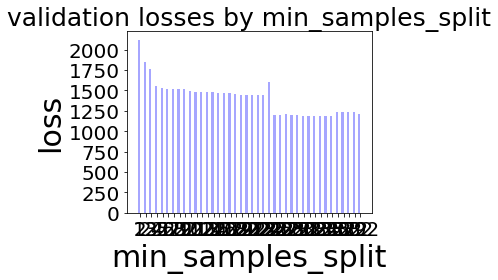

In [32]:
def plot_losses(losses, min_samples_split):
    index = np.arange(len(min_samples_split))
    bar_width = 0.4
    opacity = 0.35

    plt.bar(index, losses, bar_width, alpha=opacity, color='b')
    plt.xlabel('min_samples_split', fontsize=30)
    plt.ylabel('loss', fontsize=30)
    plt.title('validation losses by min_samples_split', fontsize = '25')
    plt.xticks(index + bar_width/2, min_samples_split, fontsize=20 )
    plt.yticks(fontsize=20 )
    plt.rcParams["figure.figsize"] = [24,15]
    plt.tight_layout()

plot_losses(tree_losses_1, min_samples_split)

In [33]:
# Choose the best model and predict refrigerator consumption on the test set
ind = np.argmin(tree_losses_1)
tree_clf_1 = tree_clfs_1[ind]
y_test_predict_1 = tree_clf_1.predict(X_test1)
mse_tree_1 = mse_loss(y_test_predict_1, y_test1)
mae_tree_1 = mae_loss(y_test_predict_1, y_test1)
print('Mean square error on test set: ', mse_tree_1)
print('Mean absolute error on the test set: ', mae_tree_1)

Mean square error on test set:  1634.5797666188705
Mean absolute error on the test set:  12.686127417077758


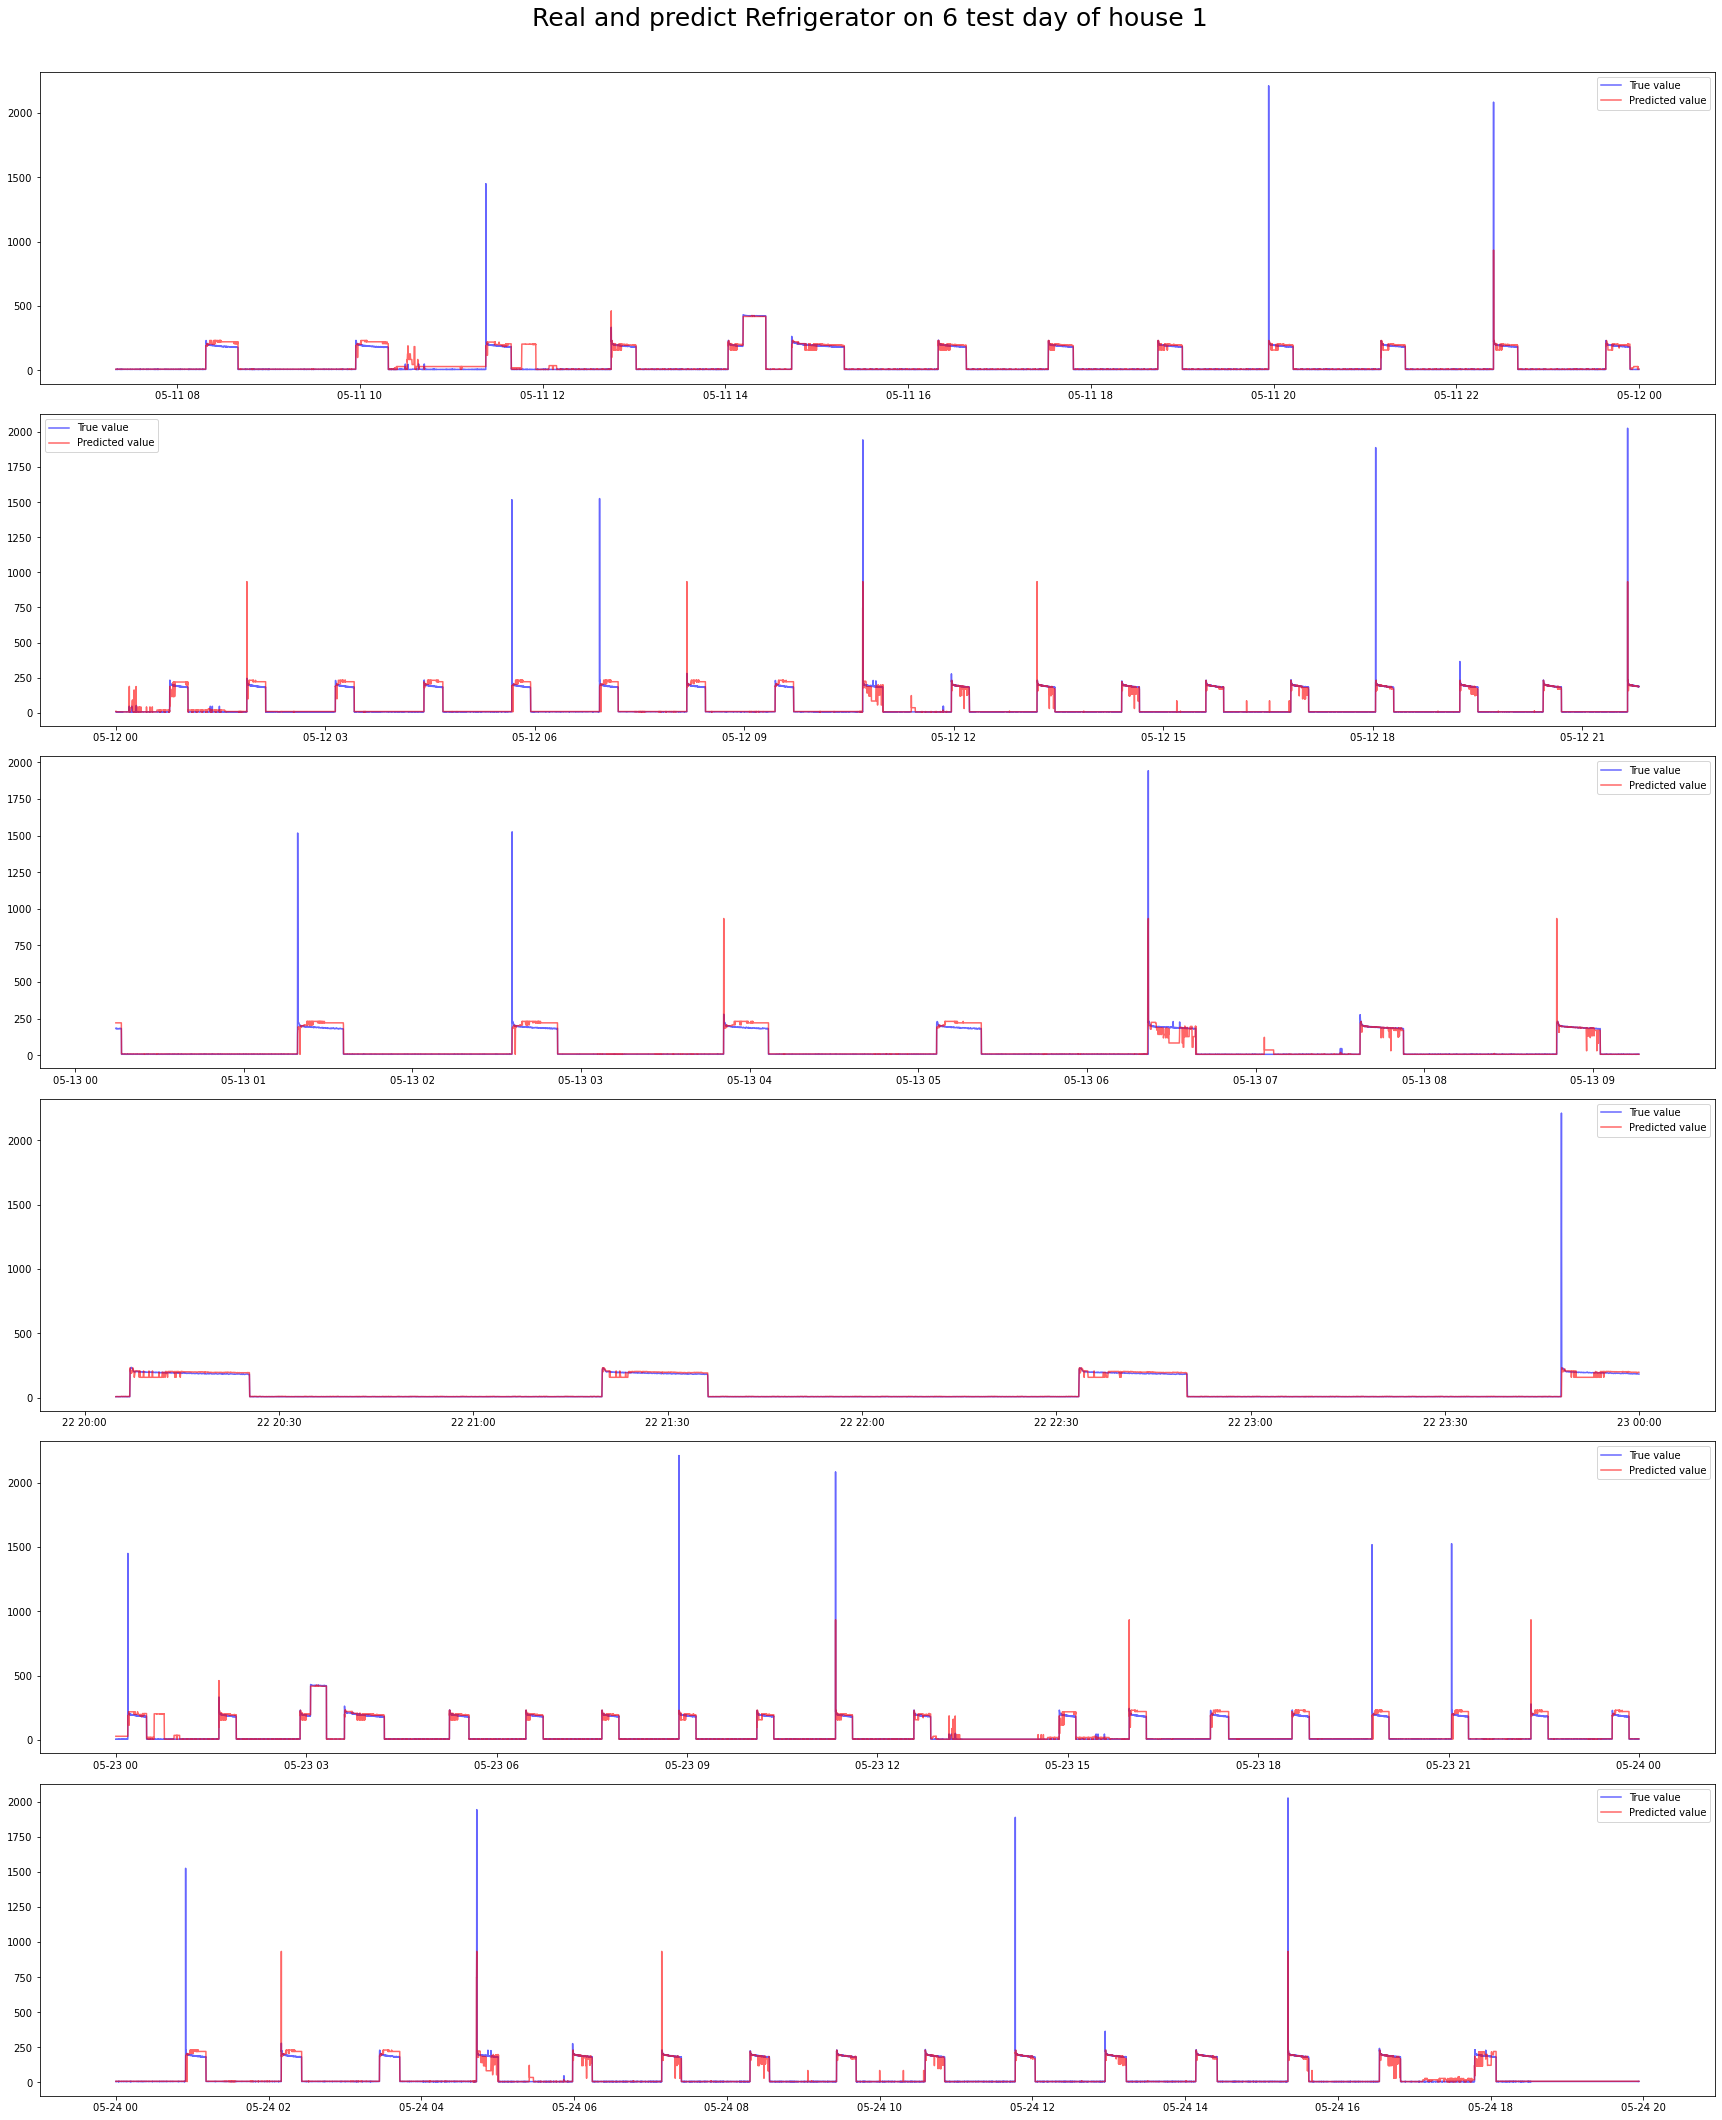

In [34]:
# Plot real and predict refrigerator consumption on six days of test data
def plot_each_app(df, dates, predict, y_test, title, look_back = 0):
    num_date = len(dates)
    fig, axes = plt.subplots(num_date,1,figsize=(24, num_date*5) )
    plt.suptitle(title, fontsize = '25')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_date):
        if i == 0: l = 0
        ind = df[dates[i]].index[look_back:]
        axes.flat[i].plot(ind, y_test[l:l+len(ind)], color = 'blue', alpha = 0.6, label = 'True value')
        axes.flat[i].plot(ind, predict[l:l+len(ind)], color = 'red', alpha = 0.6, label = 'Predicted value')
        axes.flat[i].legend()
        l = len(ind)


plot_each_app(df1_test, dates[1][17:], y_test_predict_1, y_test1, 'Real and predict Refrigerator on 6 test day of house 1')

Using decision tree model we have just trained on house 1 to predict refrigerator consumtion on house 2

In [35]:
X_2 = dfs[2][['mains_2','mains_1']].values
y_2 = dfs[2]['refrigerator_9'].values
print(X_2.shape, y_2.shape)

(316840, 2) (316840,)


In [36]:
y_predict_2 = tree_clf_1.predict(X_2)
mse_tree_2 = mse_loss(y_predict_2, y_2)
mae_tree_2 = mae_loss(y_predict_2, y_2)
print('Mean square error on test set: ', mse_tree_2)
print('Mean absolute error on the test set: ', mae_tree_2)

Mean square error on test set:  32245.25362228206
Mean absolute error on the test set:  64.75419454670589


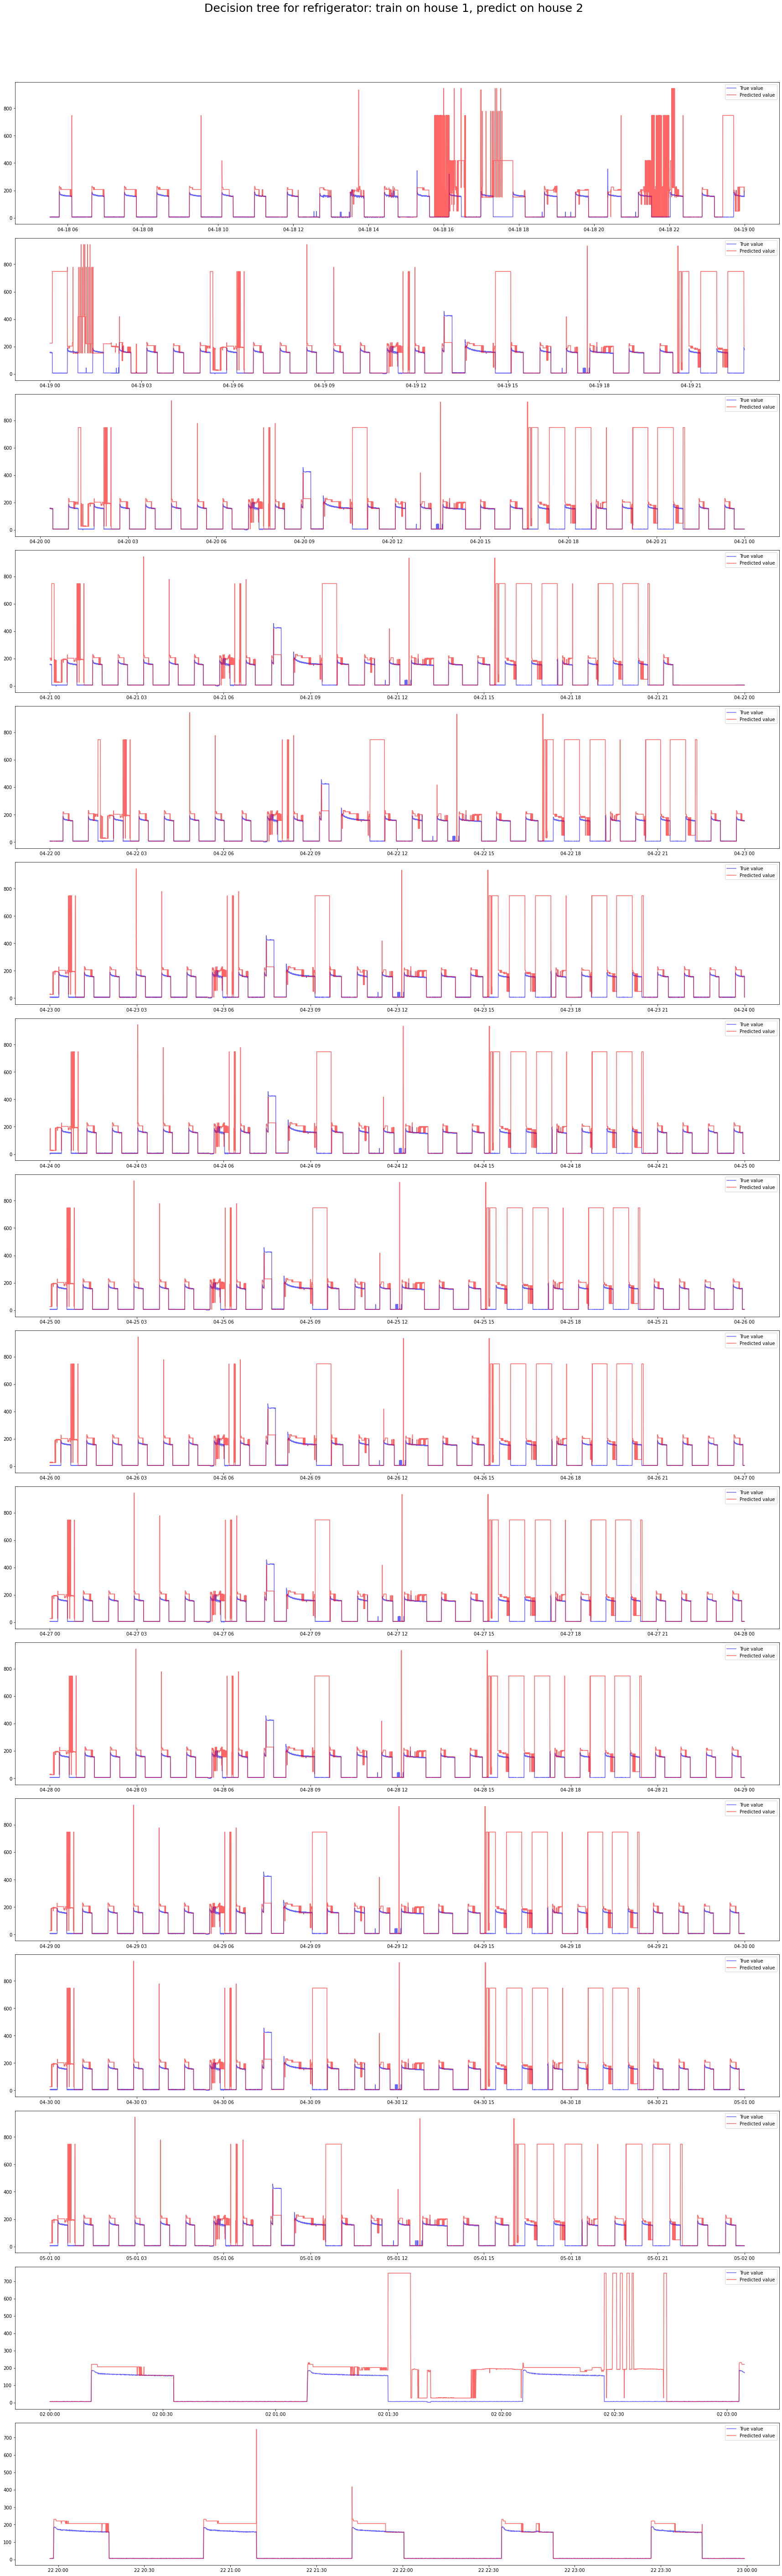

In [37]:
plot_each_app(dfs[2], dates[2], y_predict_2, y_2, 'Decision tree for refrigerator: train on house 1, predict on house 2')

Now, we will try decision tree method for other appliances in house 1

In [38]:
# List of other appliances in house 1:
appliances = list(dfs[1].columns.values[2:])
appliances.pop(2)
print(appliances)

['h', 'm', 'mains_1', 'mains_2', 'oven_3', 'oven_4', 'refrigerator_5', 'dishwaser_6', 'kitchen_outlets_7', 'kitchen_outlets_8', 'lighting_9', 'washer_dryer_10', 'microwave_11', 'bathroom_gfi_12', 'electric_heat_13', 'stove_14', 'kitchen_outlets_15', 'kitchen_outlets_16', 'lighting_17', 'lighting_18', 'washer_dryer_19', 'washer_dryer_20']


In [39]:

# using decision tree model on other appliances
def tree_reg_mult_apps():
    start = time.time()
    min_samples_split=np.arange(2, 400, 10)
    pred = {}
    for app in appliances:
        list_clfs = []
        losses = []
        y_train = df1_train[app].values
        y_val = df1_val[app].values
        for split in min_samples_split:
            clf = DecisionTreeRegressor(min_samples_split = split)
            clf.fit(X_train1, y_train)
            y_predict_val = clf.predict(X_val1)
            list_clfs.append(clf)
            losses.append( mse_loss(y_predict_val, y_val) )
        ind = np.argmin(losses)
        pred[app] = list_clfs[ind].predict(X_test1)
    print('Trainning time: ', time.time() - start)
    return pred

mul_pred = tree_reg_mult_apps()

Trainning time:  357.26289200782776


In [40]:
def error_mul_app(mul_pred):
    mse_losses = {}
    mae_losses = {}
    for app in appliances:
        mse_losses[app] = mse_loss(mul_pred[app], df1_test[app].values)
        mae_losses[app] = mae_loss(mul_pred[app], df1_test[app].values)
    return mse_losses, mae_losses

mul_mse_tree, mul_mae_tree = error_mul_app(mul_pred)

In [41]:
for app in appliances:
    m = np.mean(df1_test[app].values)
    print('mean of {0}: {1:.2f} - mse: {2:.2f} - mae: {3:.2f}'.format(app, m ,mul_mse_tree[app], mul_mae_tree[app]))

mean of h: 11.02 - mse: 57.57 - mae: 6.01
mean of m: 29.47 - mse: 405.09 - mae: 16.78
mean of mains_1: 220.02 - mse: 27.28 - mae: 0.61
mean of mains_2: 162.25 - mse: 8.30 - mae: 0.21
mean of oven_3: 15.63 - mse: 18554.82 - mae: 11.28
mean of oven_4: 17.11 - mse: 7454.75 - mae: 4.92
mean of refrigerator_5: 59.04 - mse: 1634.58 - mae: 12.69
mean of dishwaser_6: 25.35 - mse: 831.49 - mae: 3.38
mean of kitchen_outlets_7: 21.25 - mse: 4.54 - mae: 1.59
mean of kitchen_outlets_8: 27.71 - mse: 99.51 - mae: 3.43
mean of lighting_9: 28.29 - mse: 1585.73 - mae: 24.15
mean of washer_dryer_10: 3.07 - mse: 934.44 - mae: 2.44
mean of microwave_11: 18.92 - mse: 12442.92 - mae: 13.00
mean of bathroom_gfi_12: 6.73 - mse: 3471.07 - mae: 3.44
mean of electric_heat_13: 0.11 - mse: 0.53 - mae: 0.05
mean of stove_14: 0.10 - mse: 0.23 - mae: 0.04
mean of kitchen_outlets_15: 5.34 - mse: 832.75 - mae: 1.63
mean of kitchen_outlets_16: 1.93 - mse: 718.63 - mae: 0.65
mean of lighting_17: 18.97 - mse: 136.66 - mae:

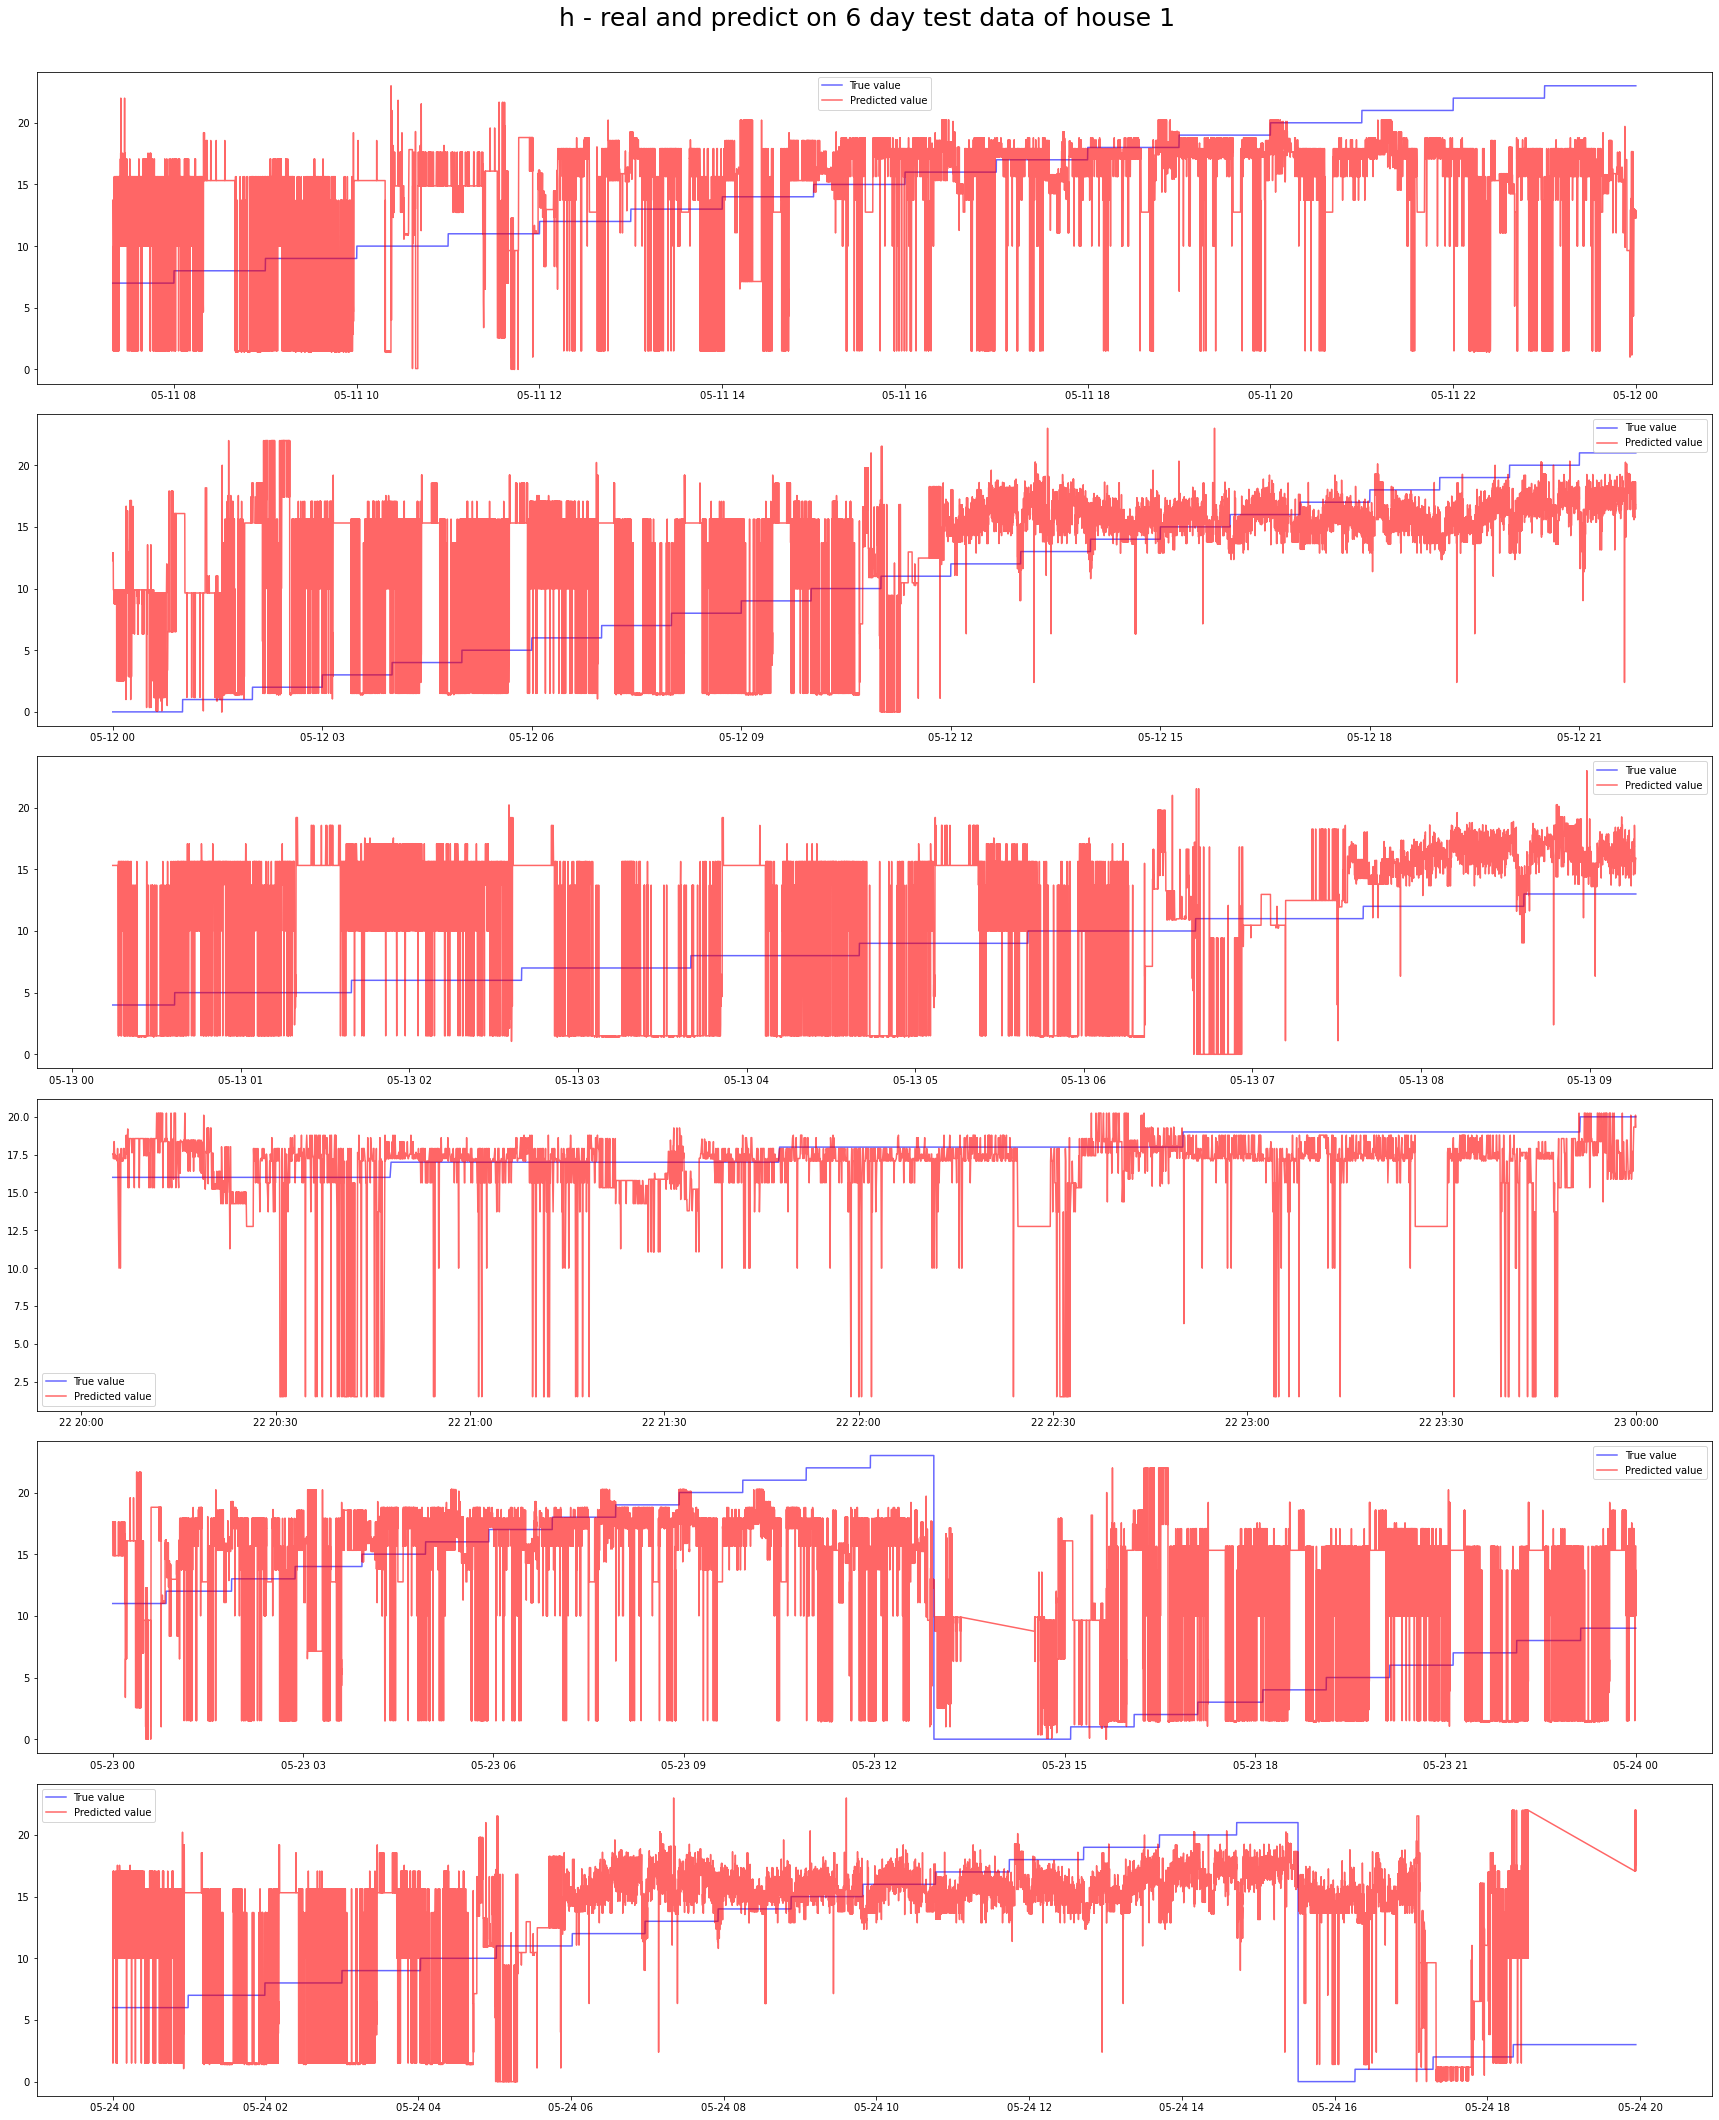

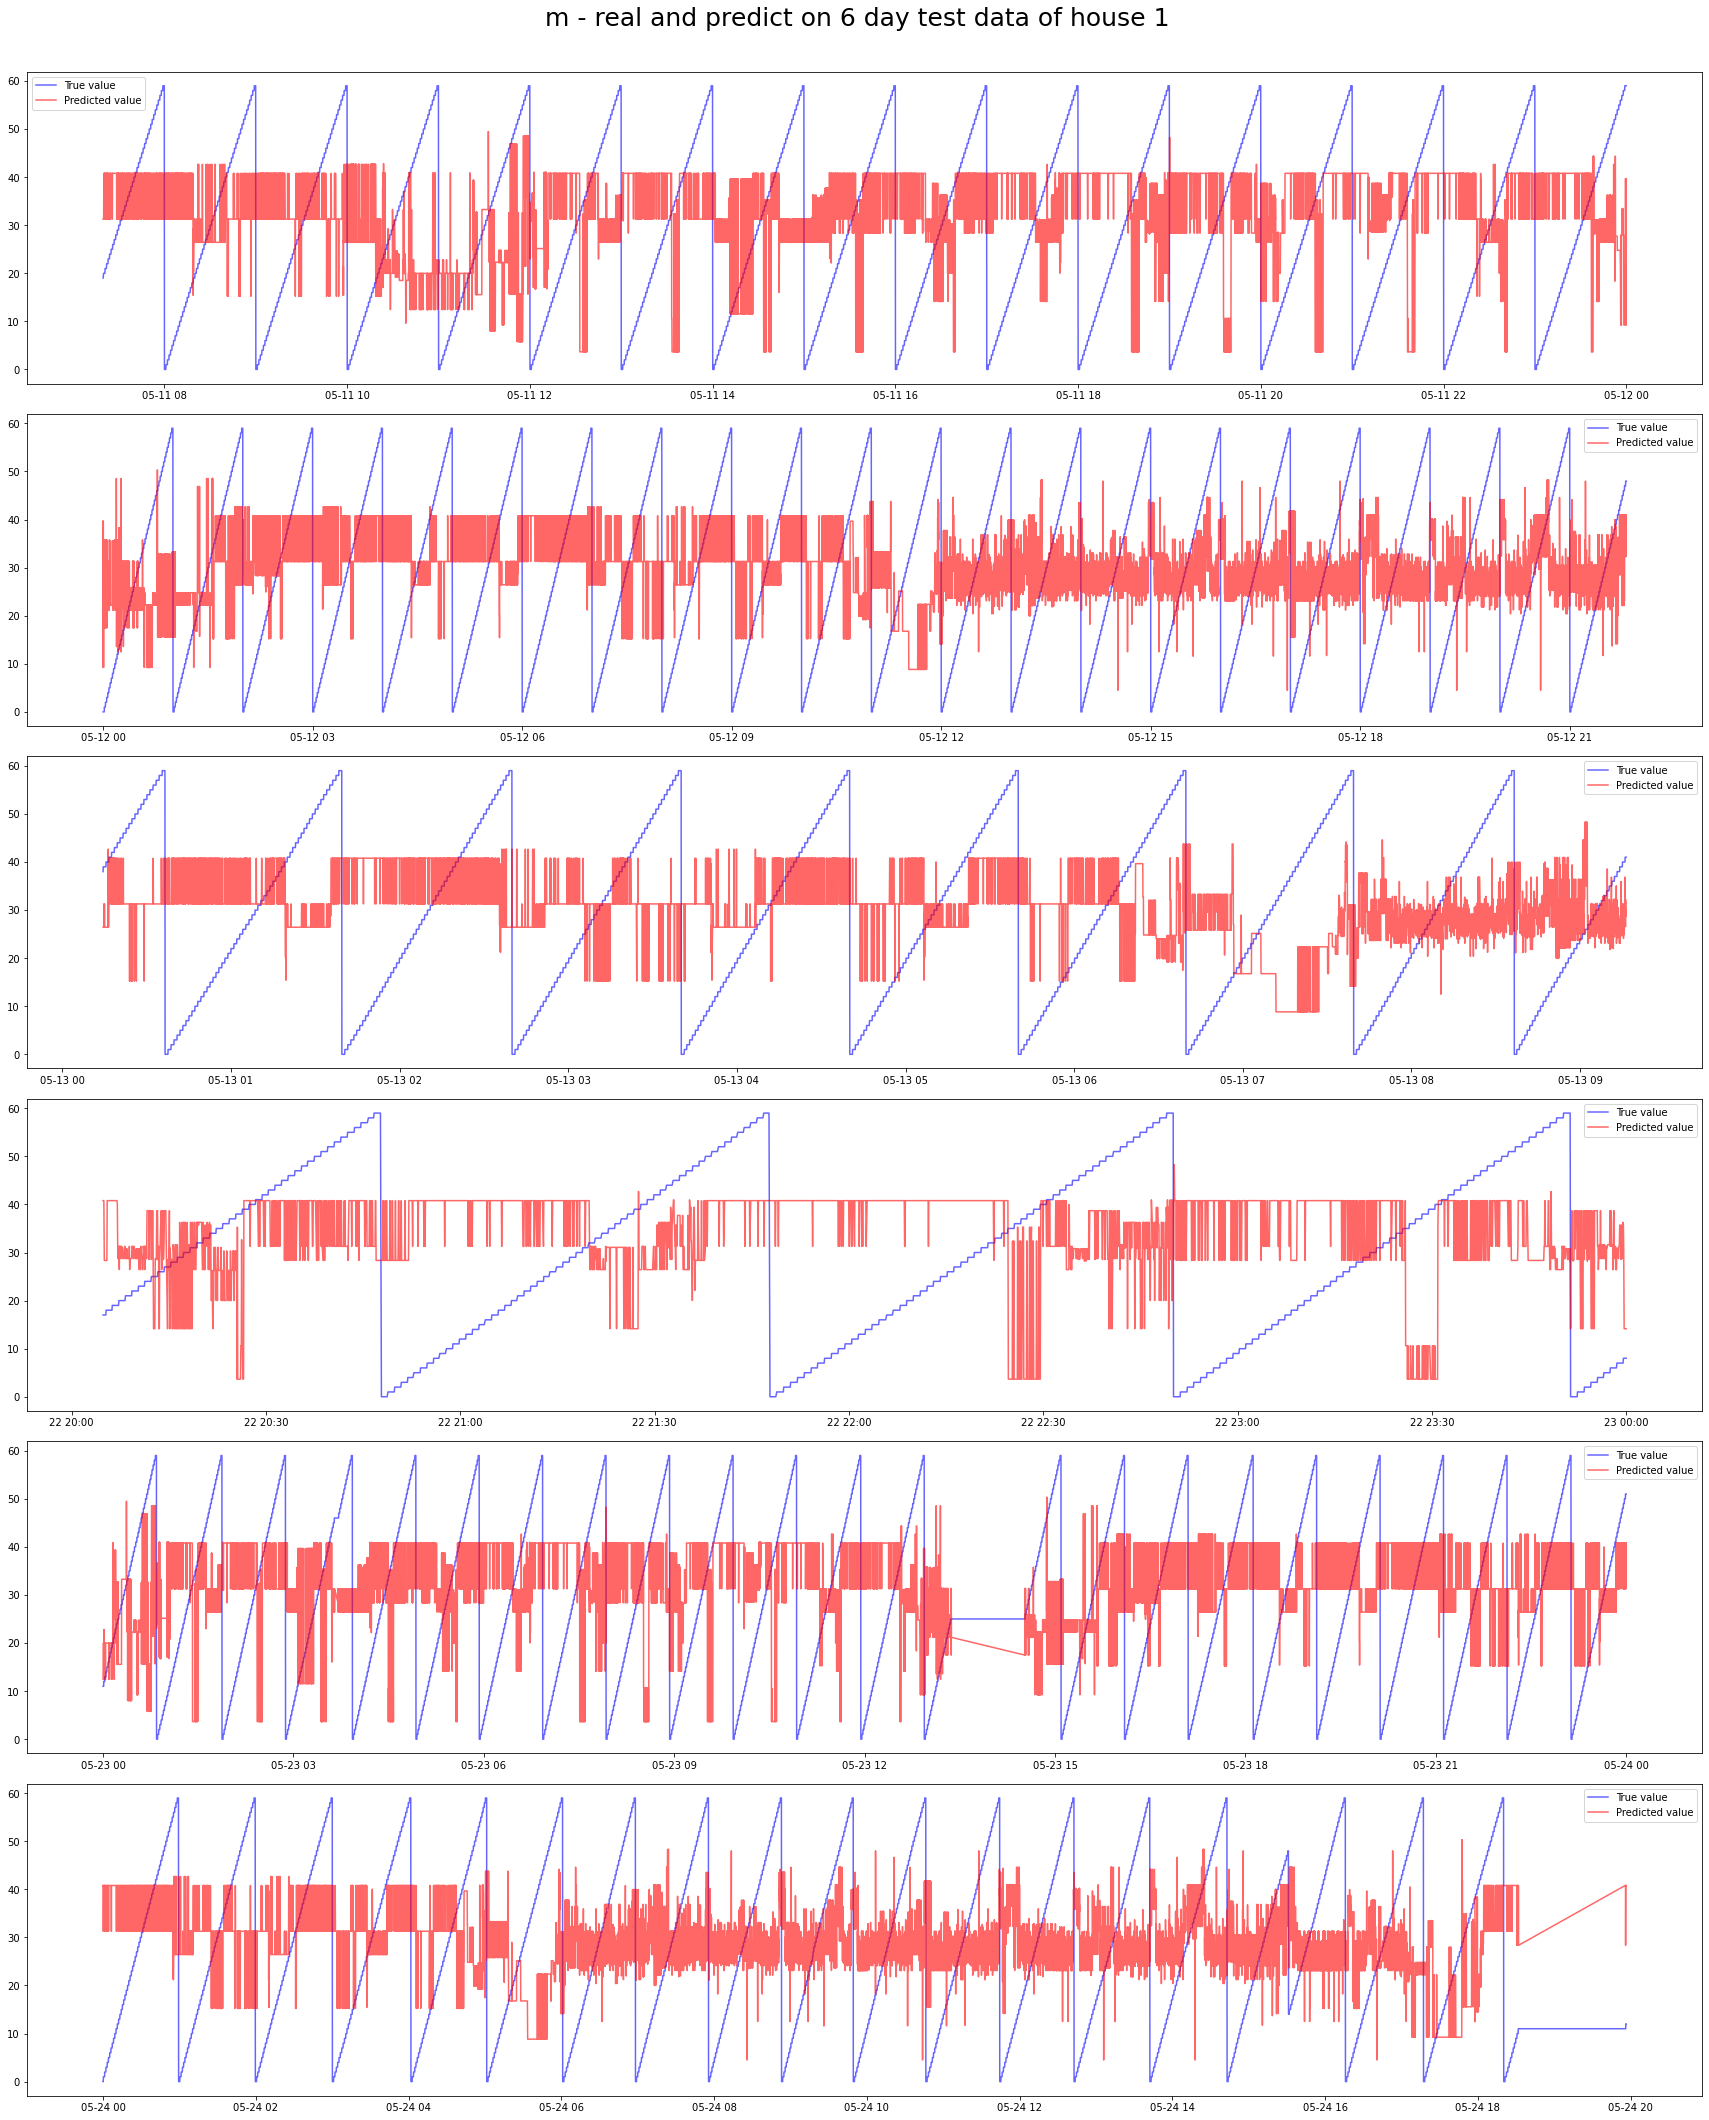

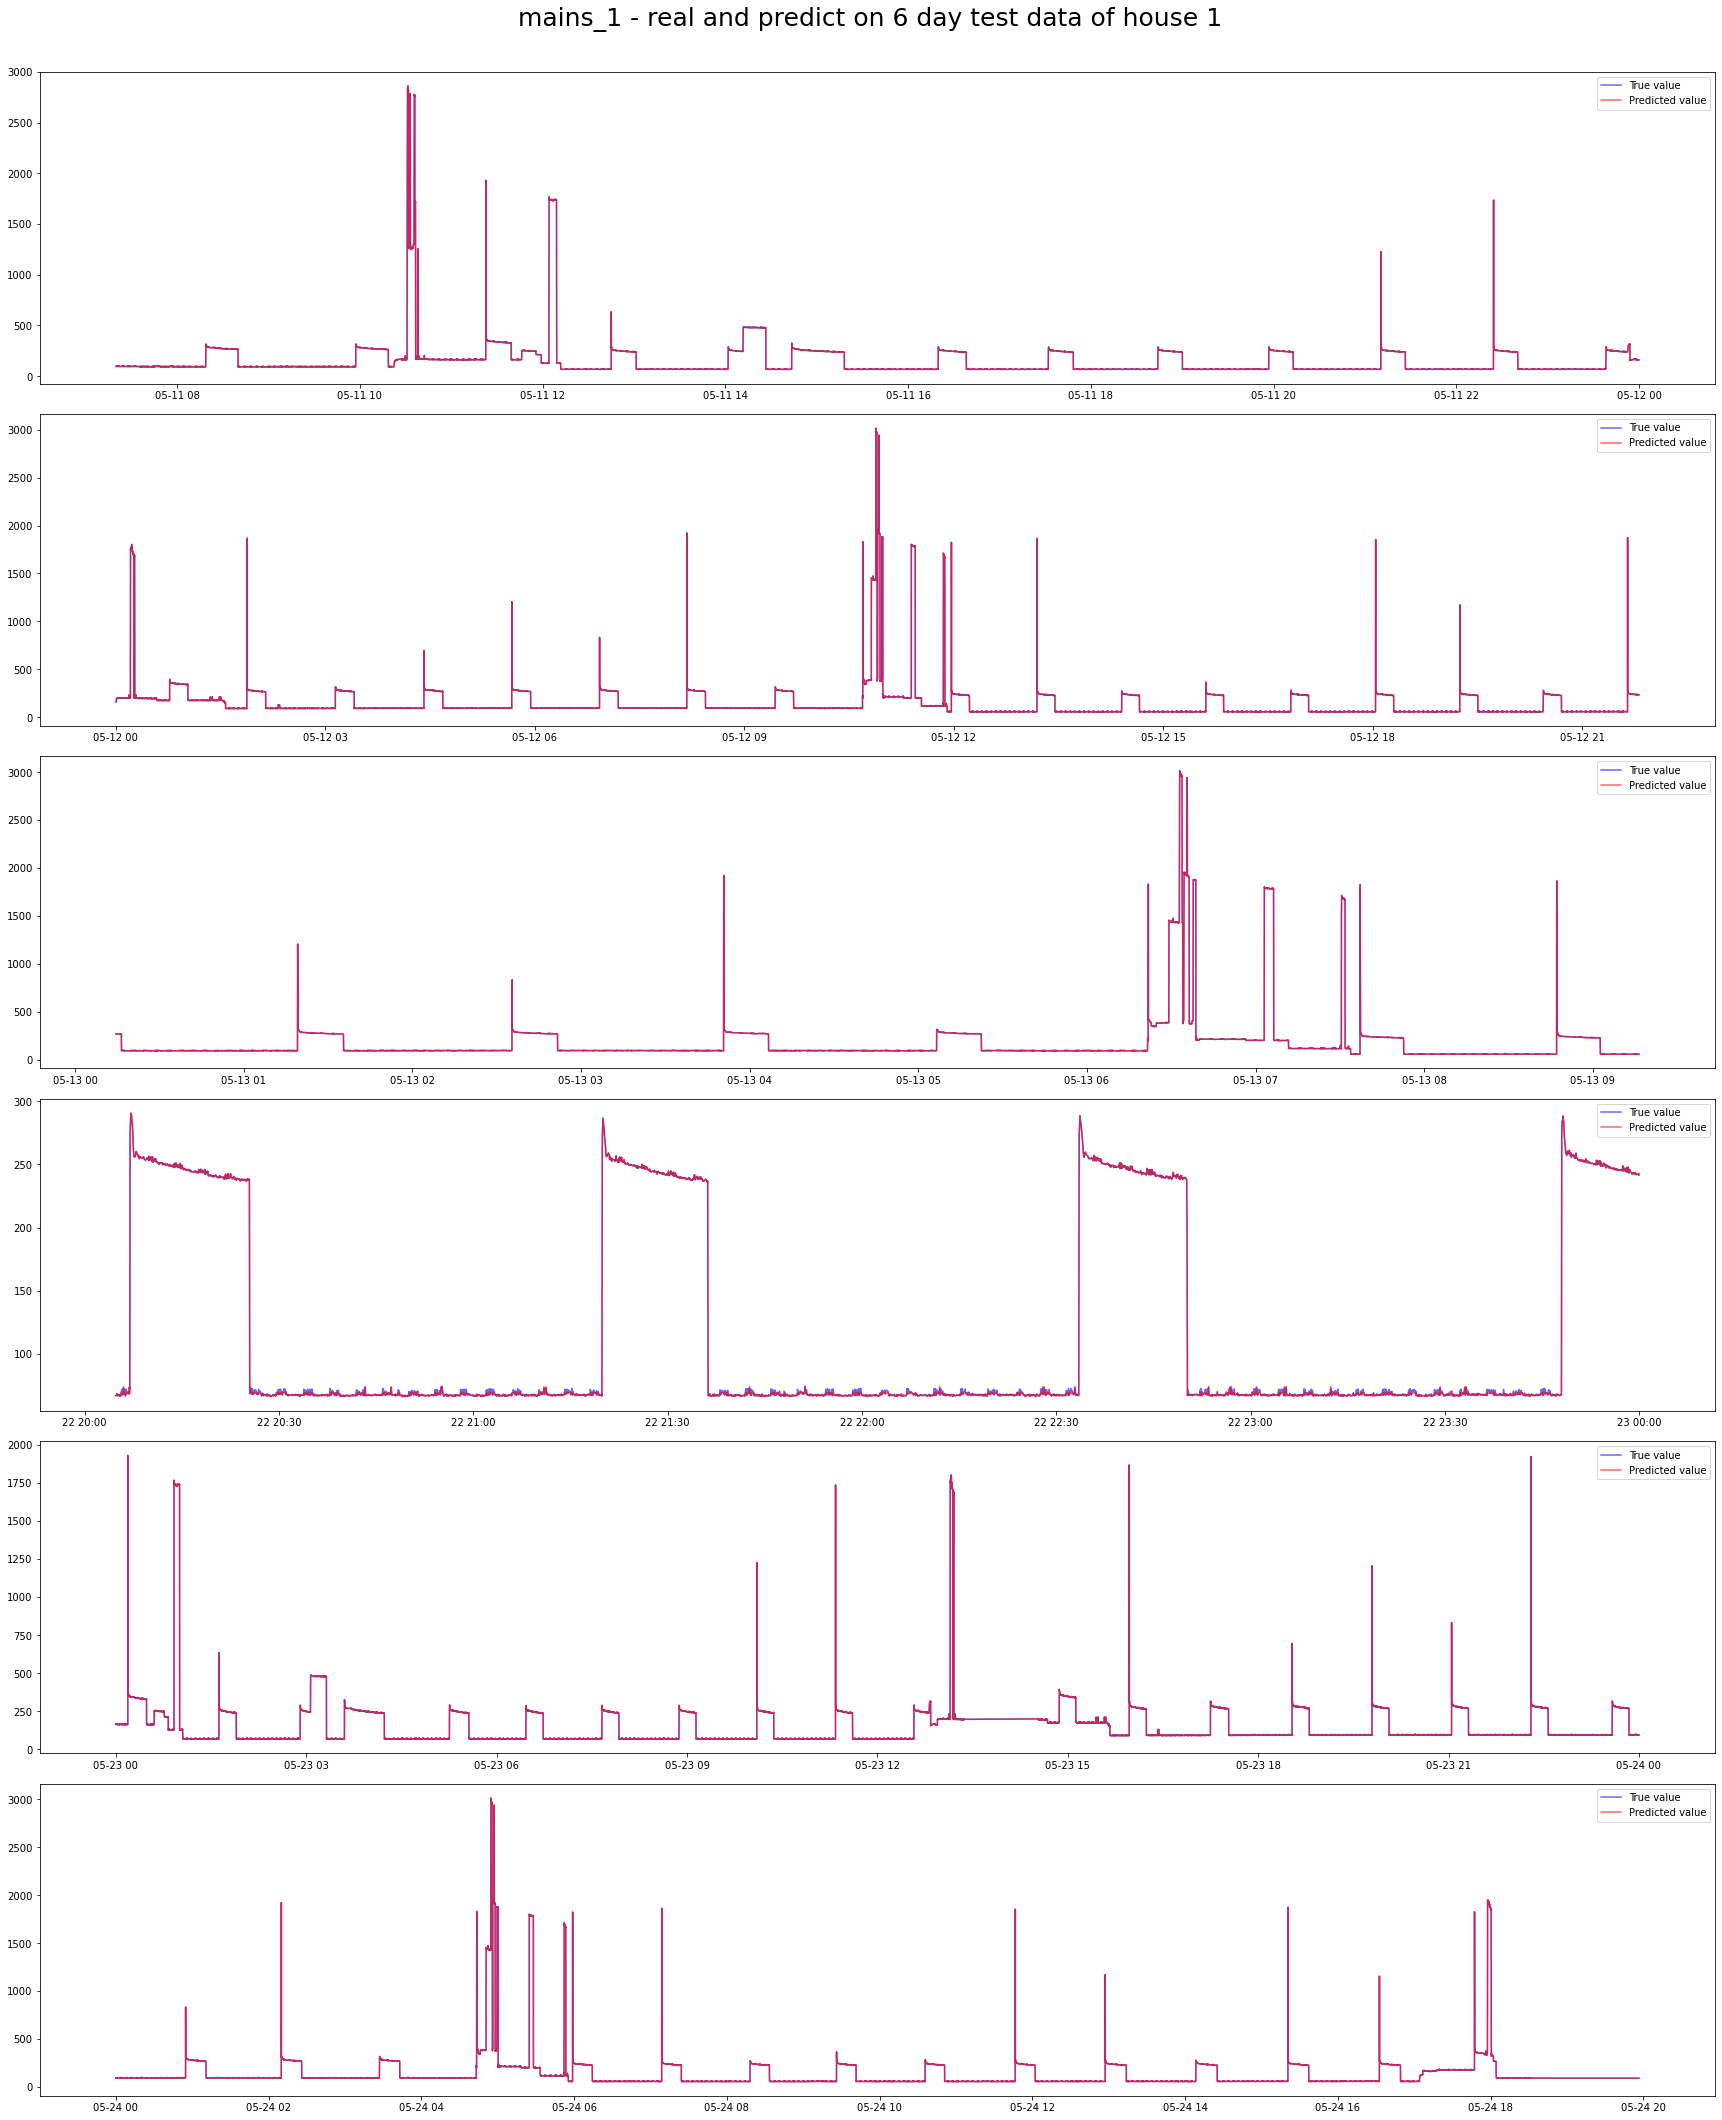

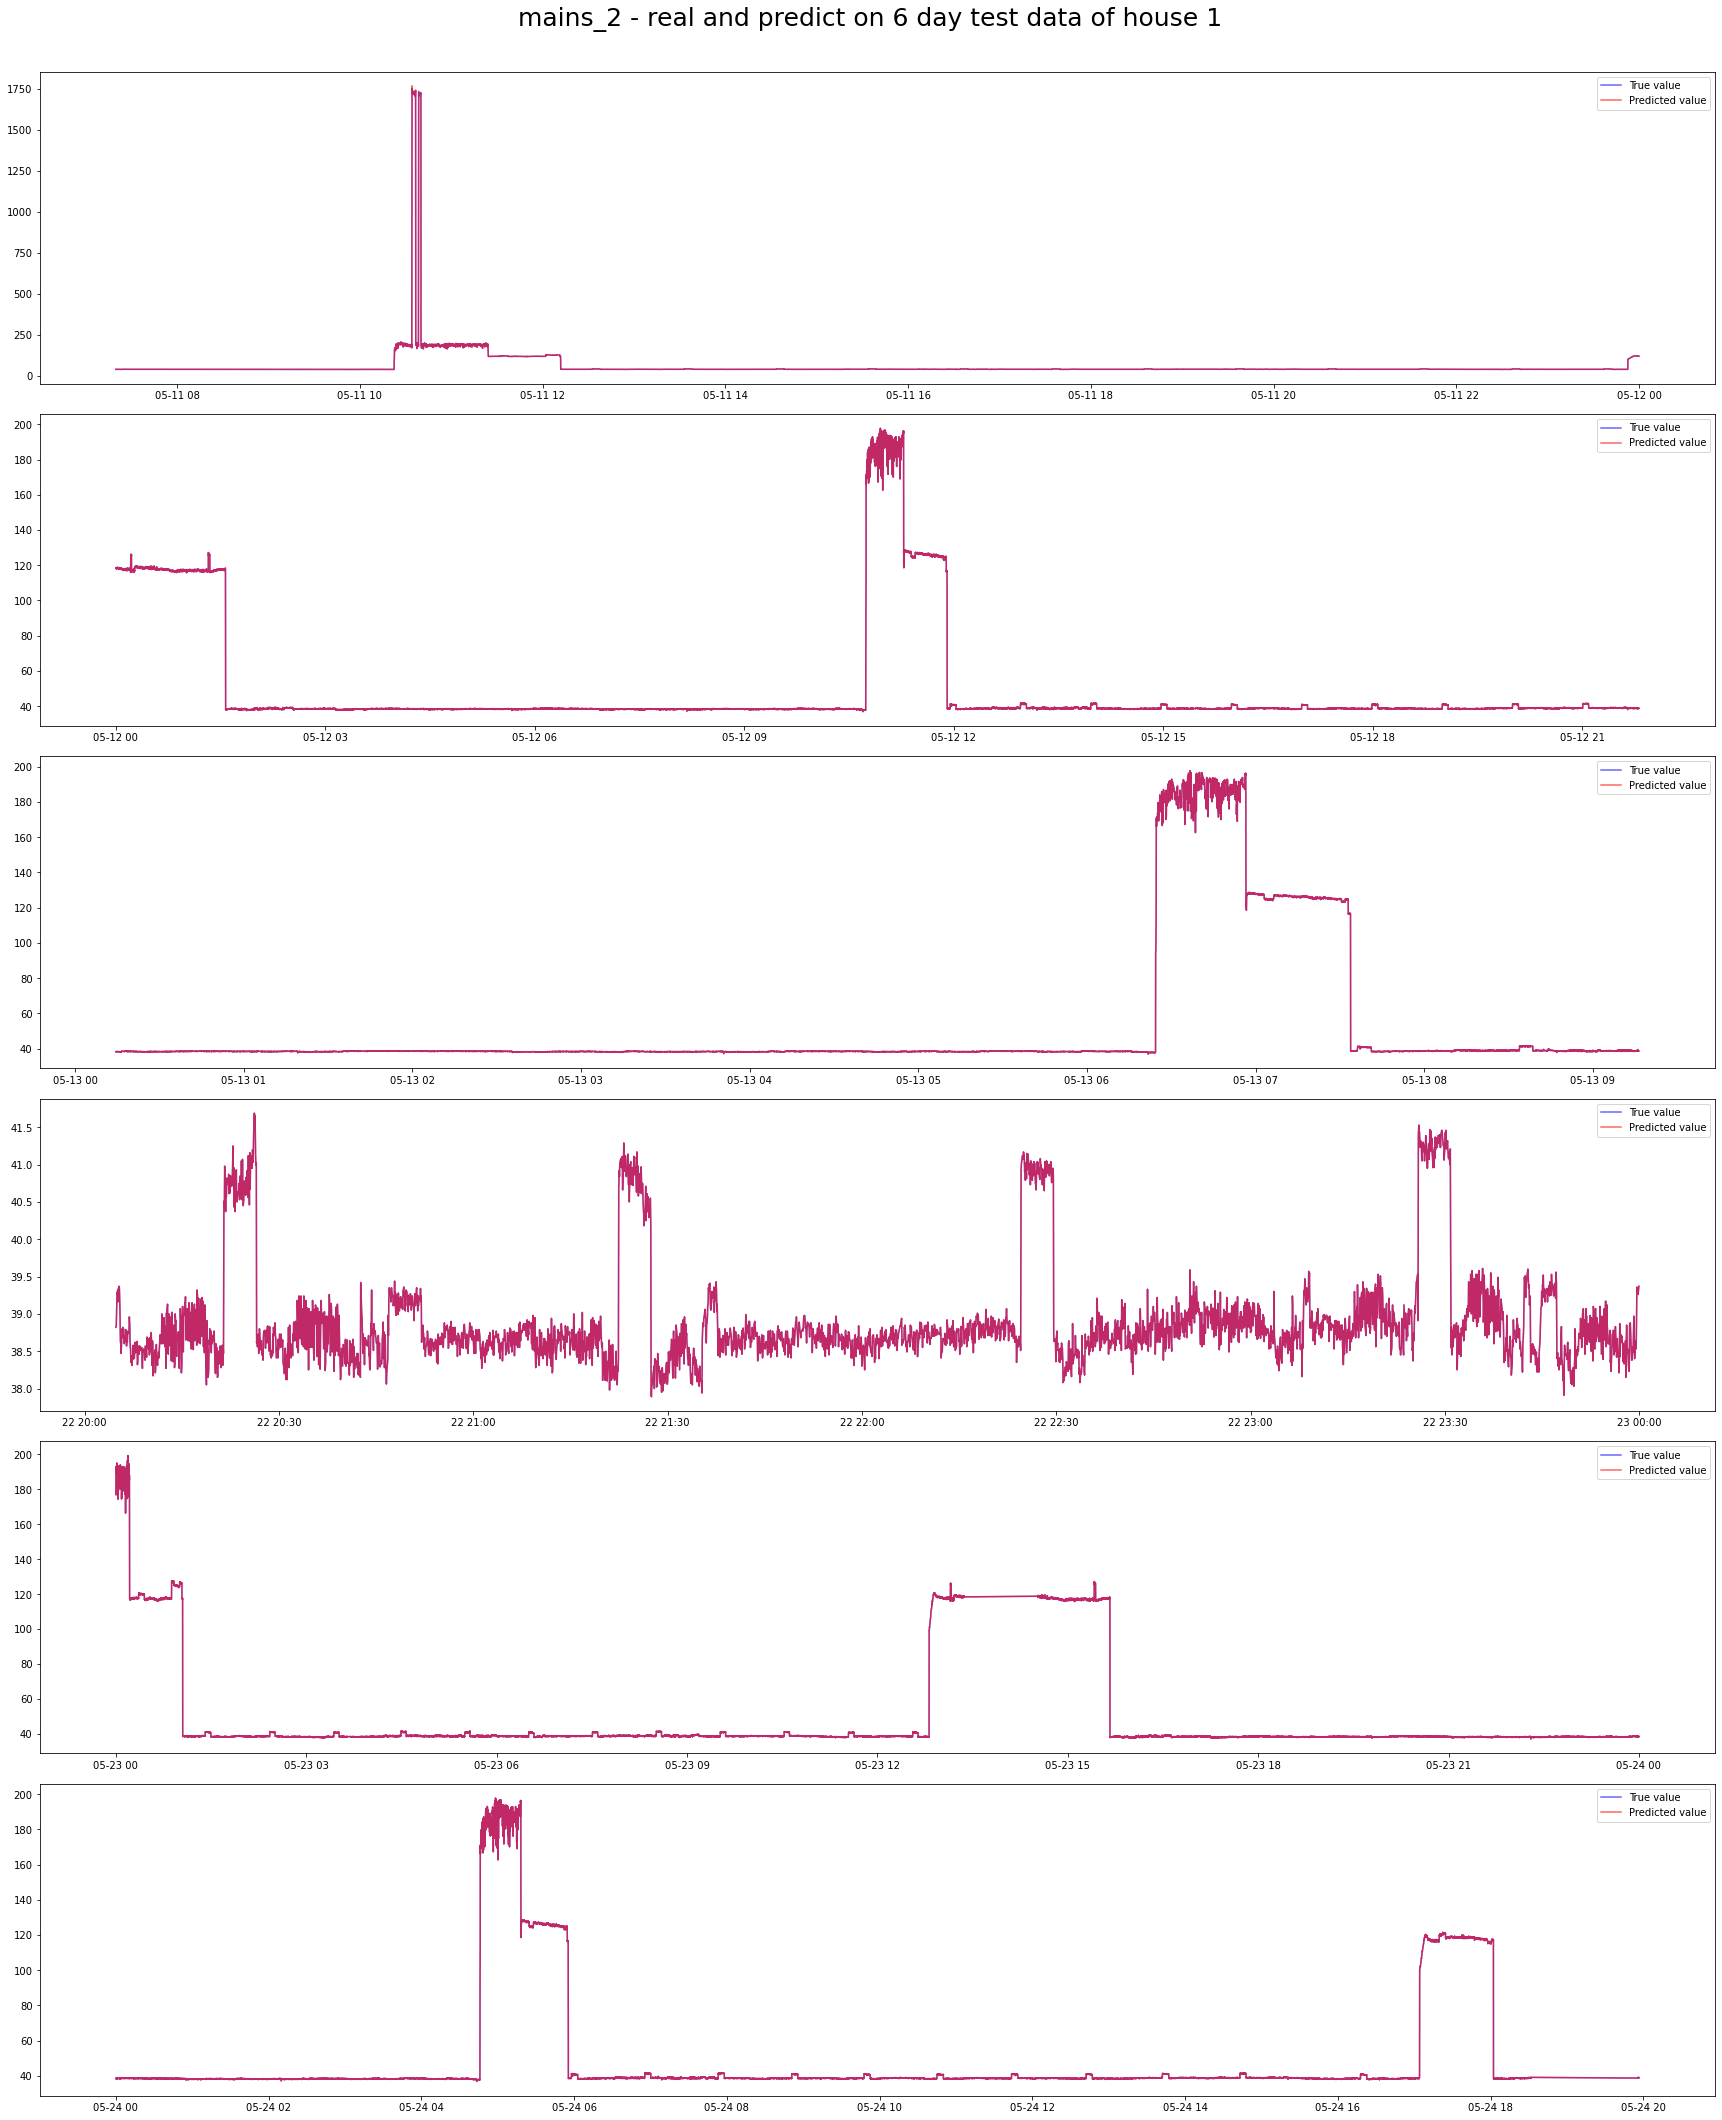

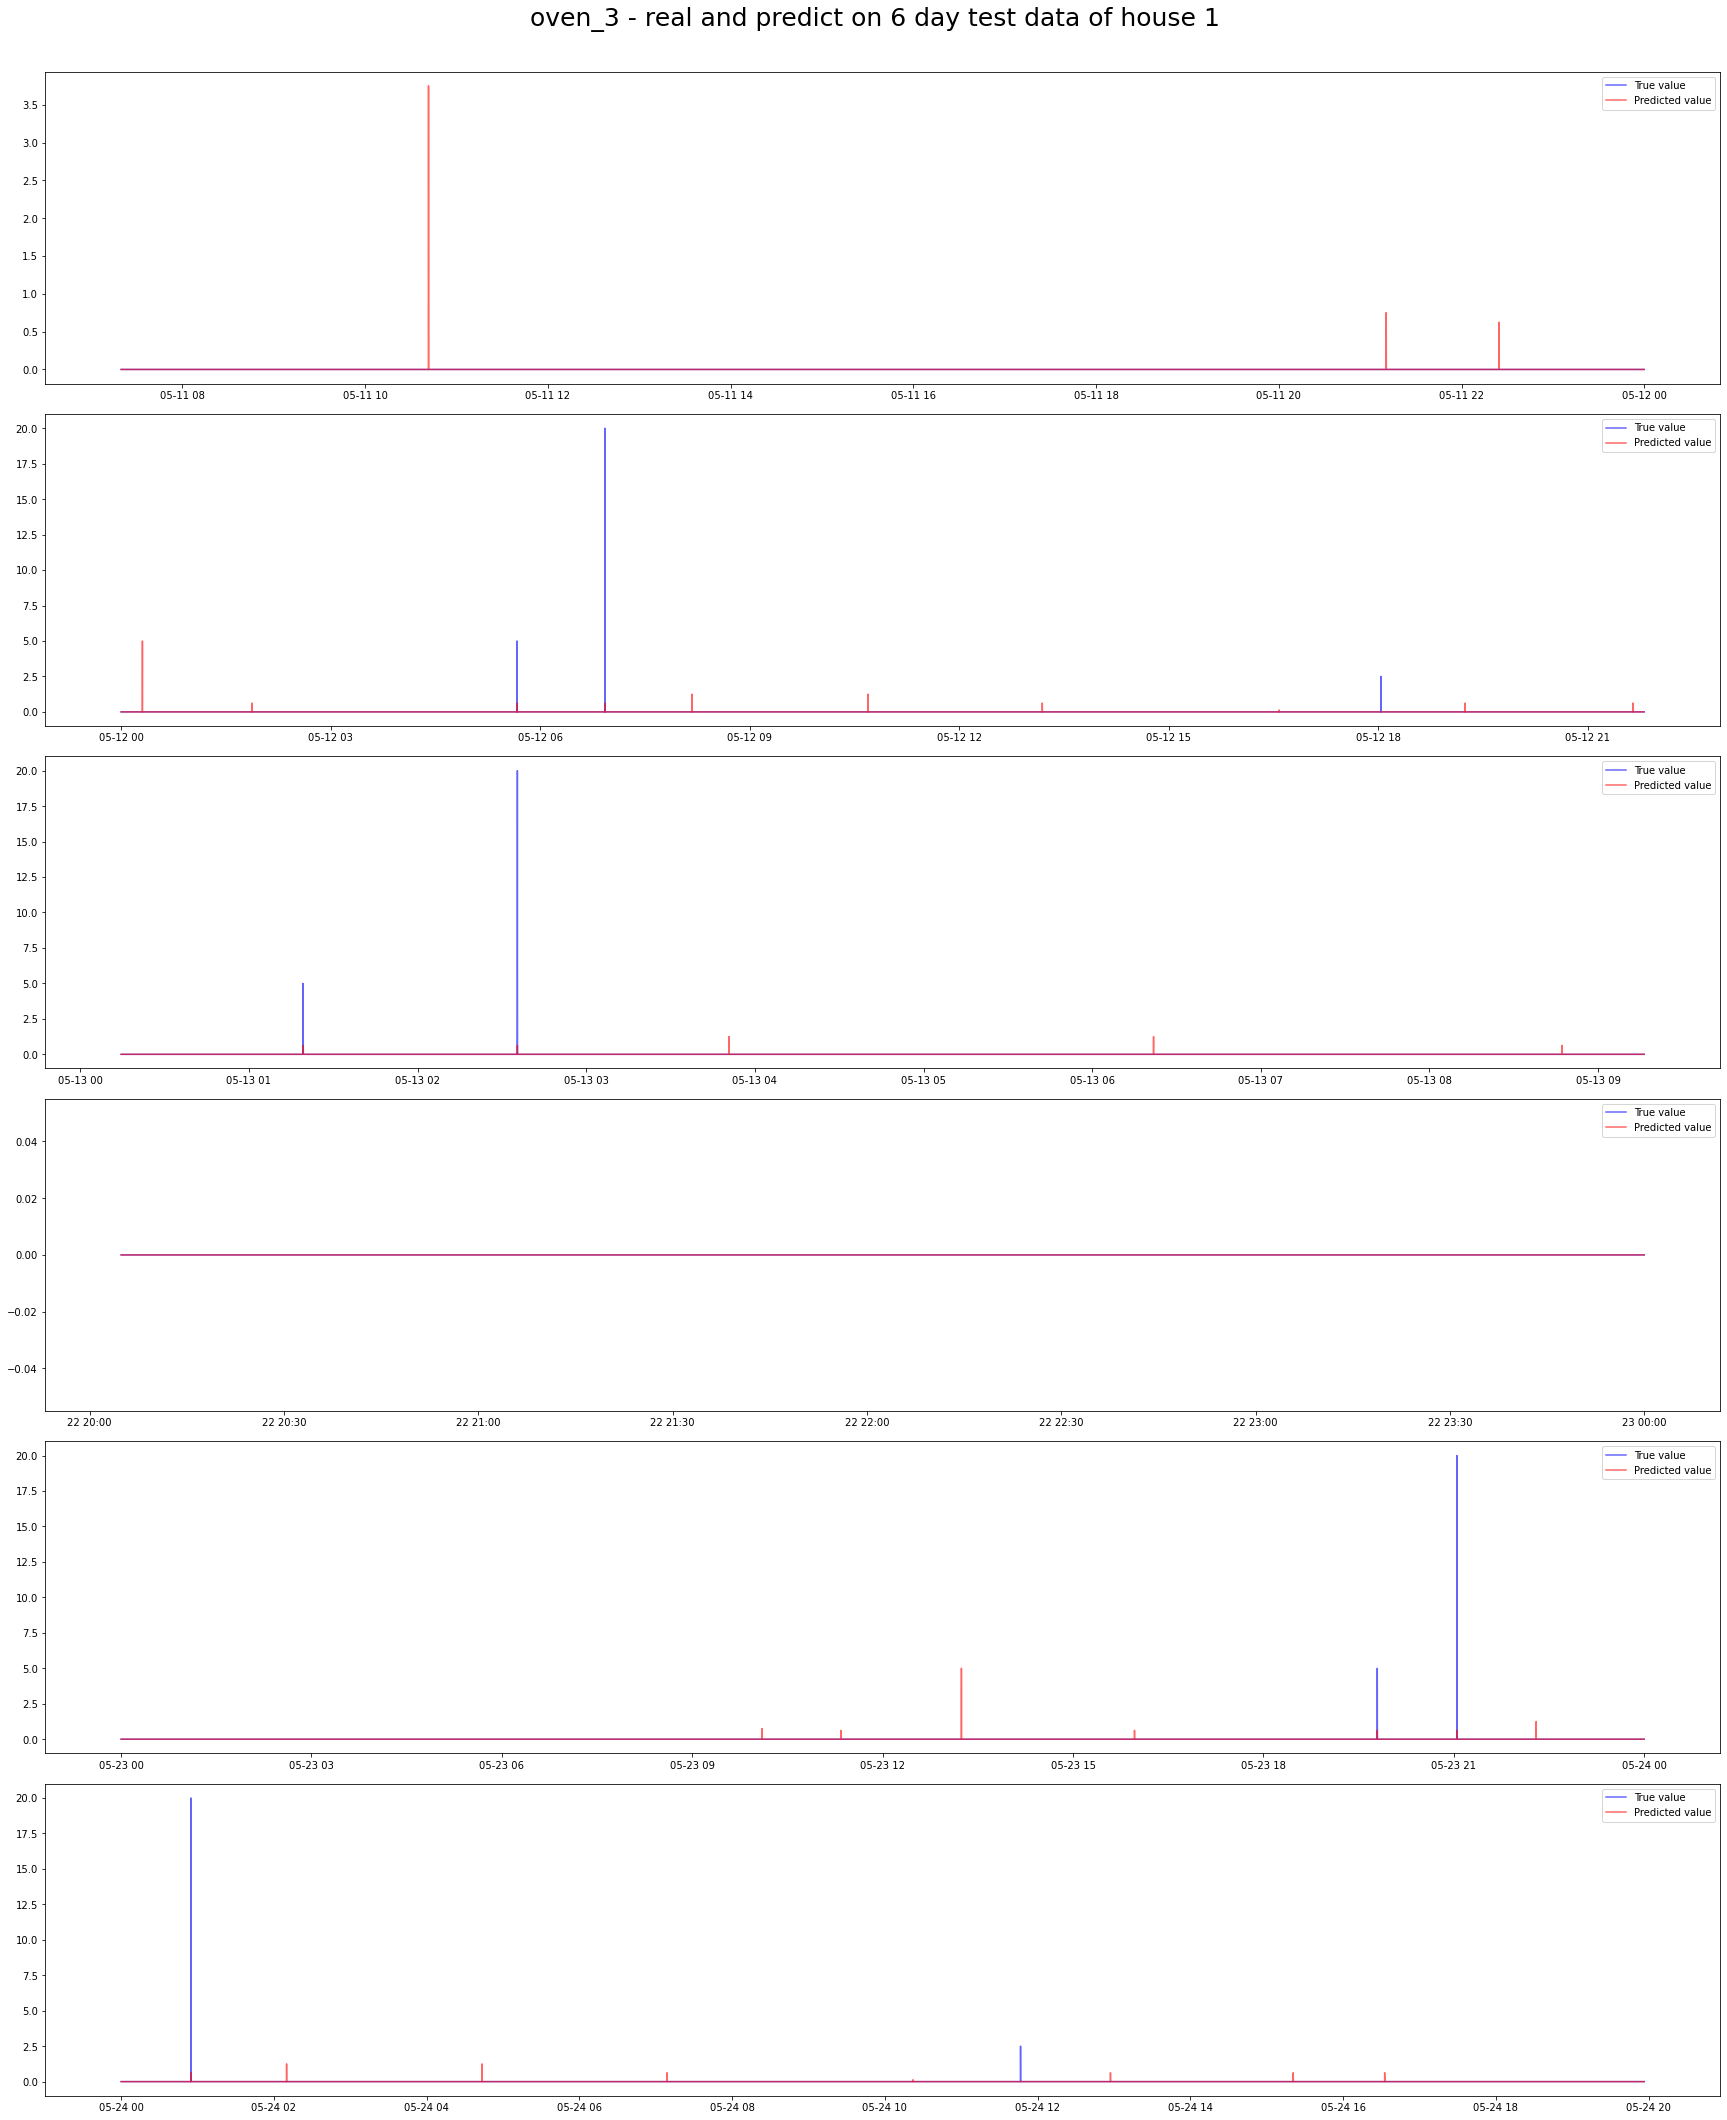

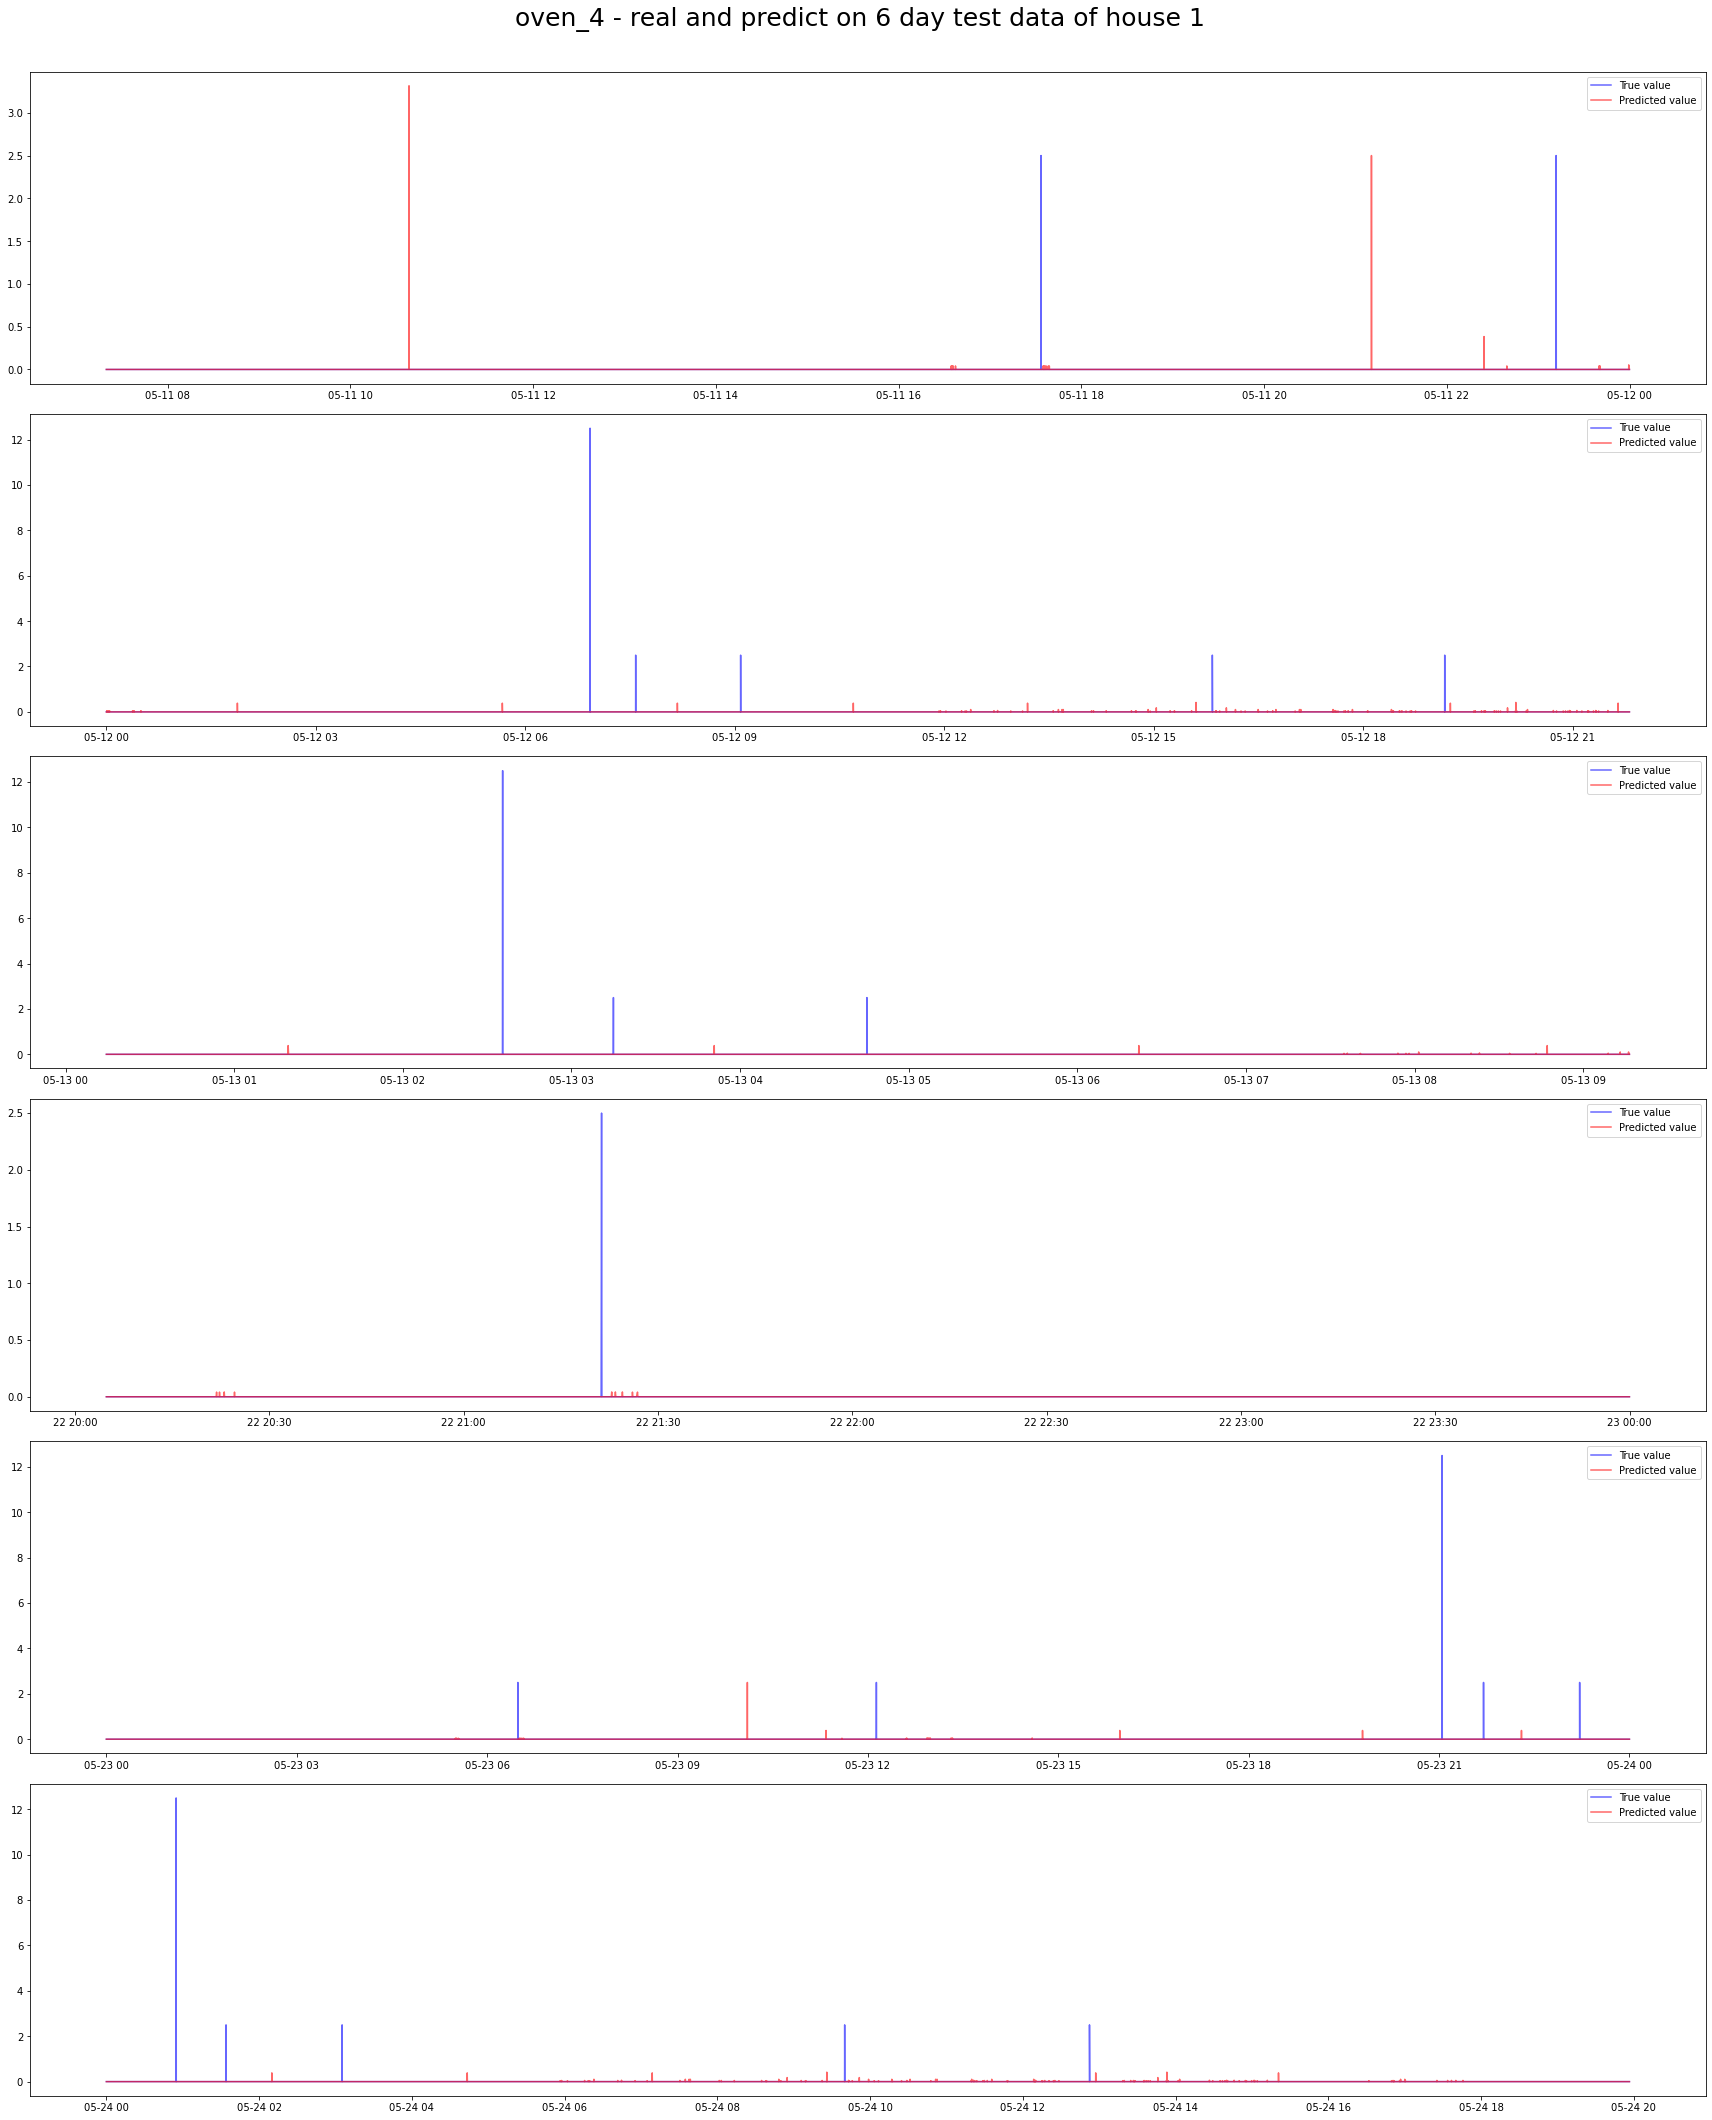

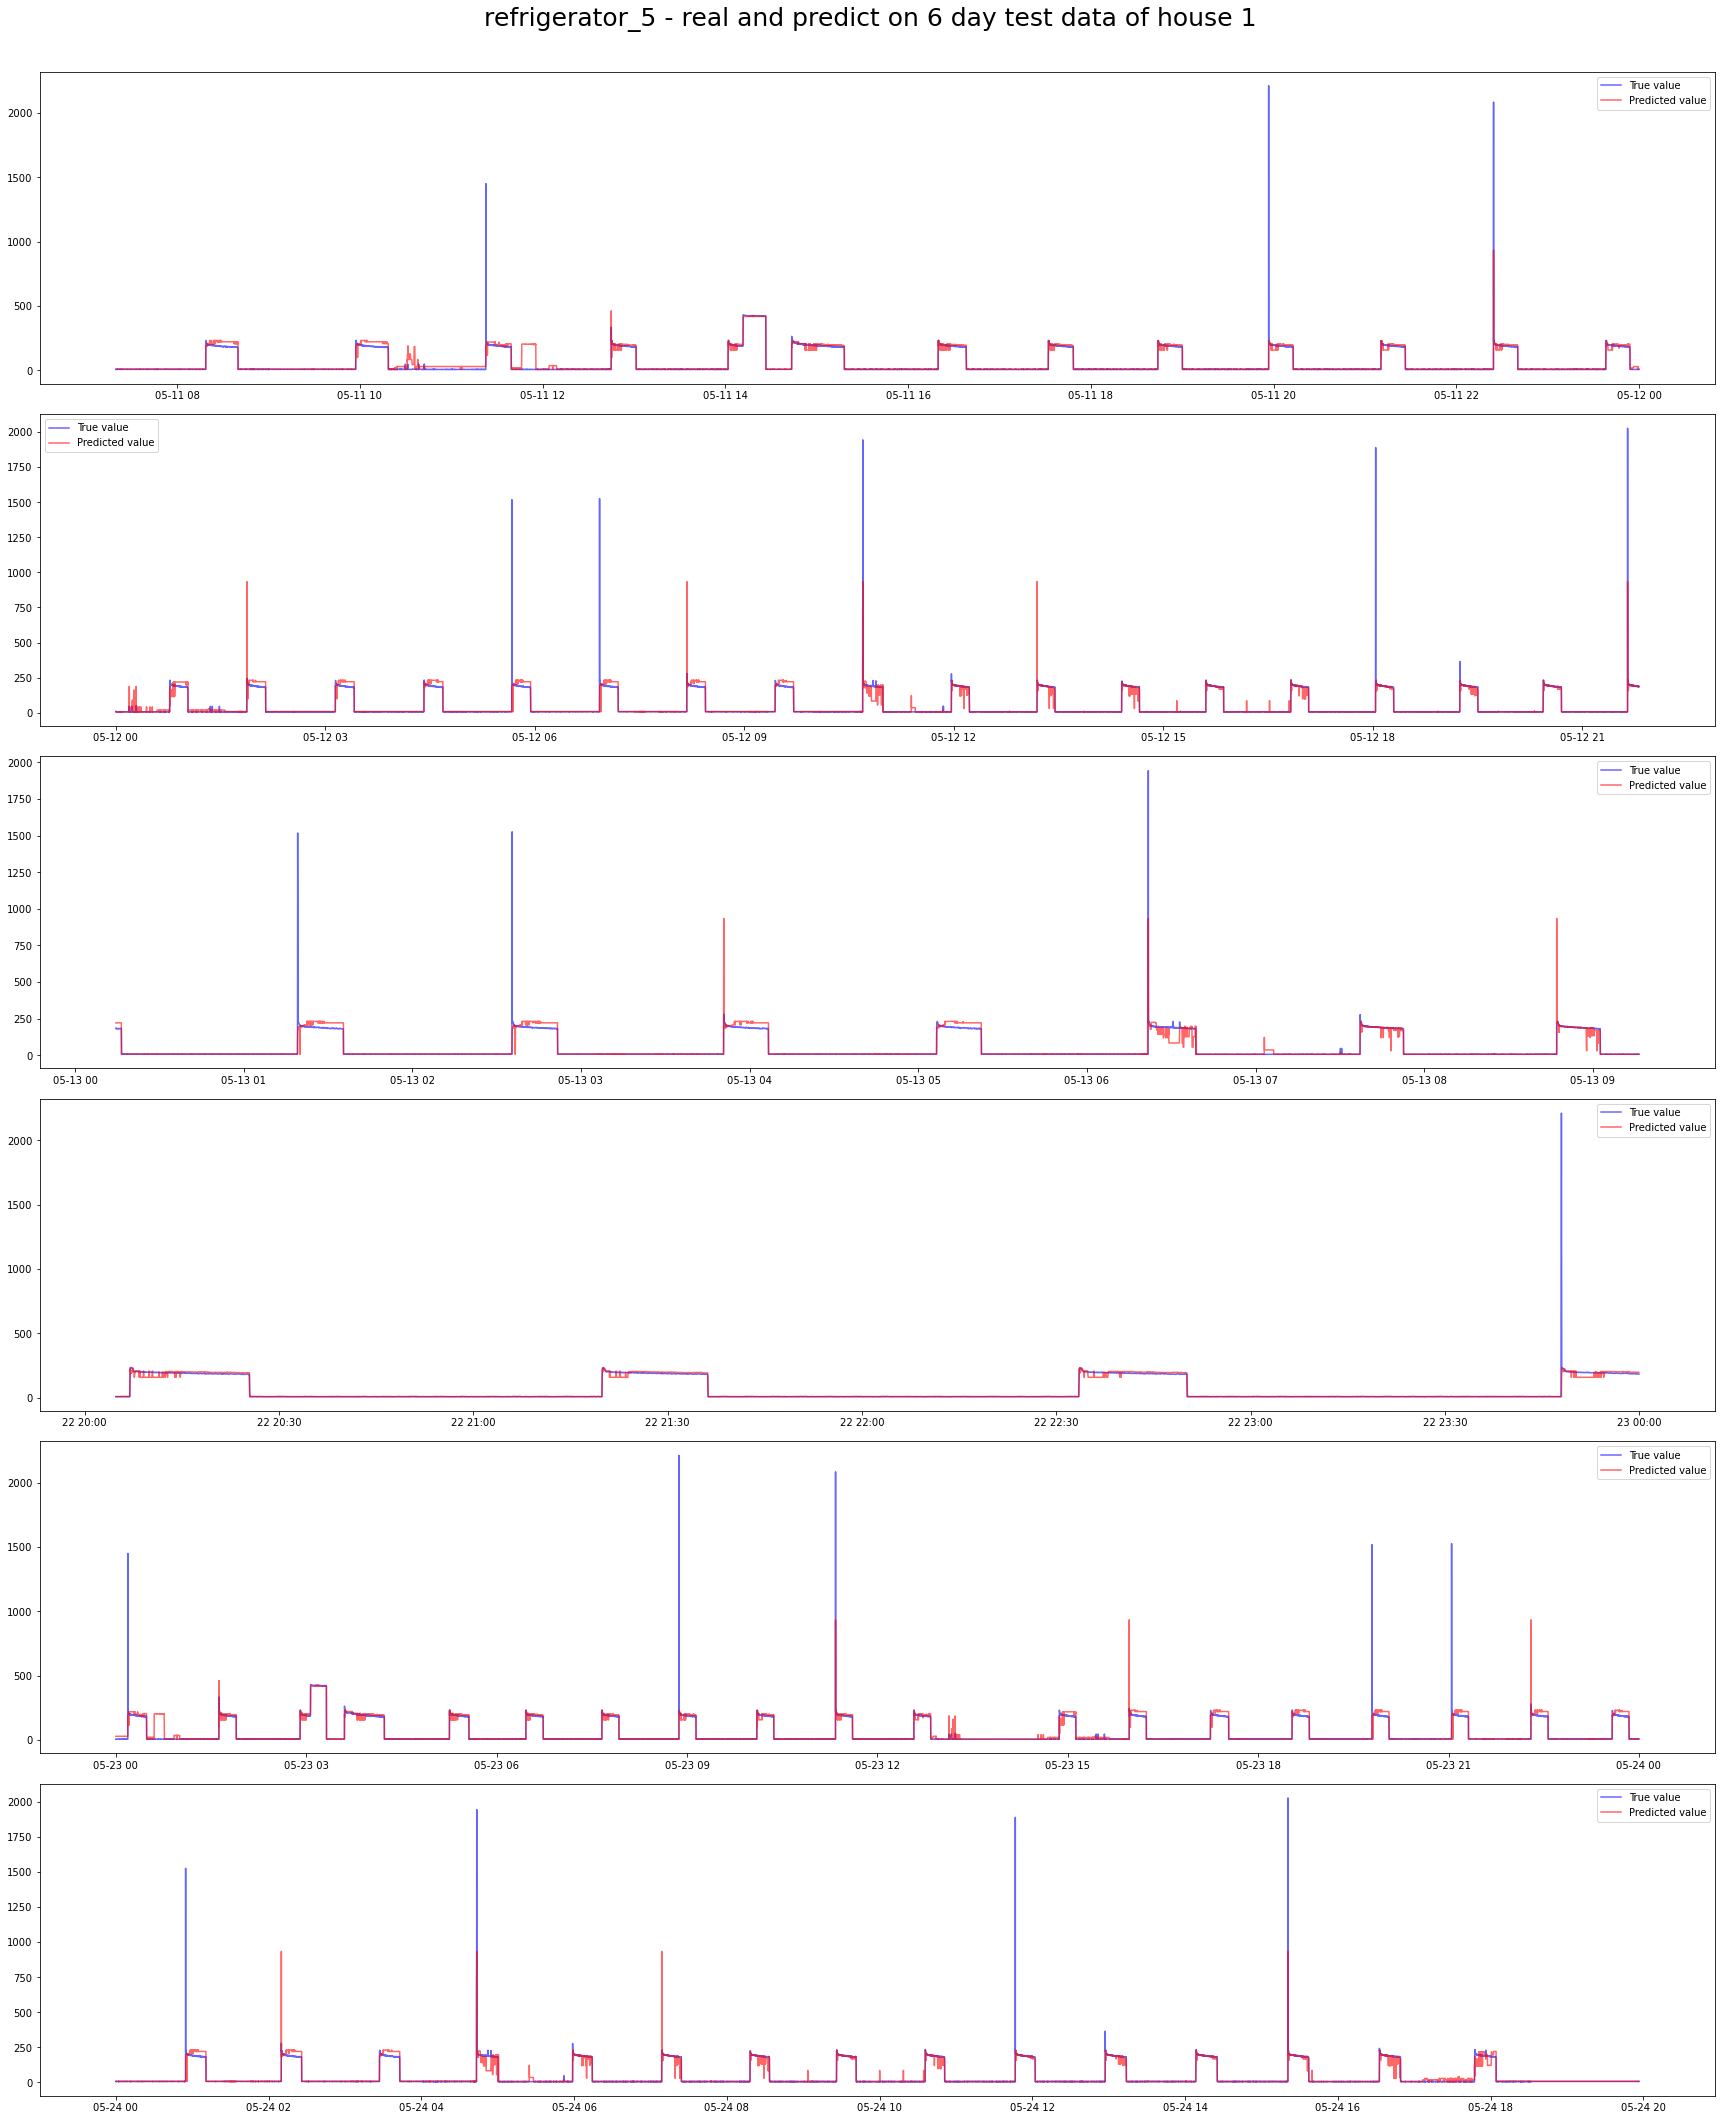

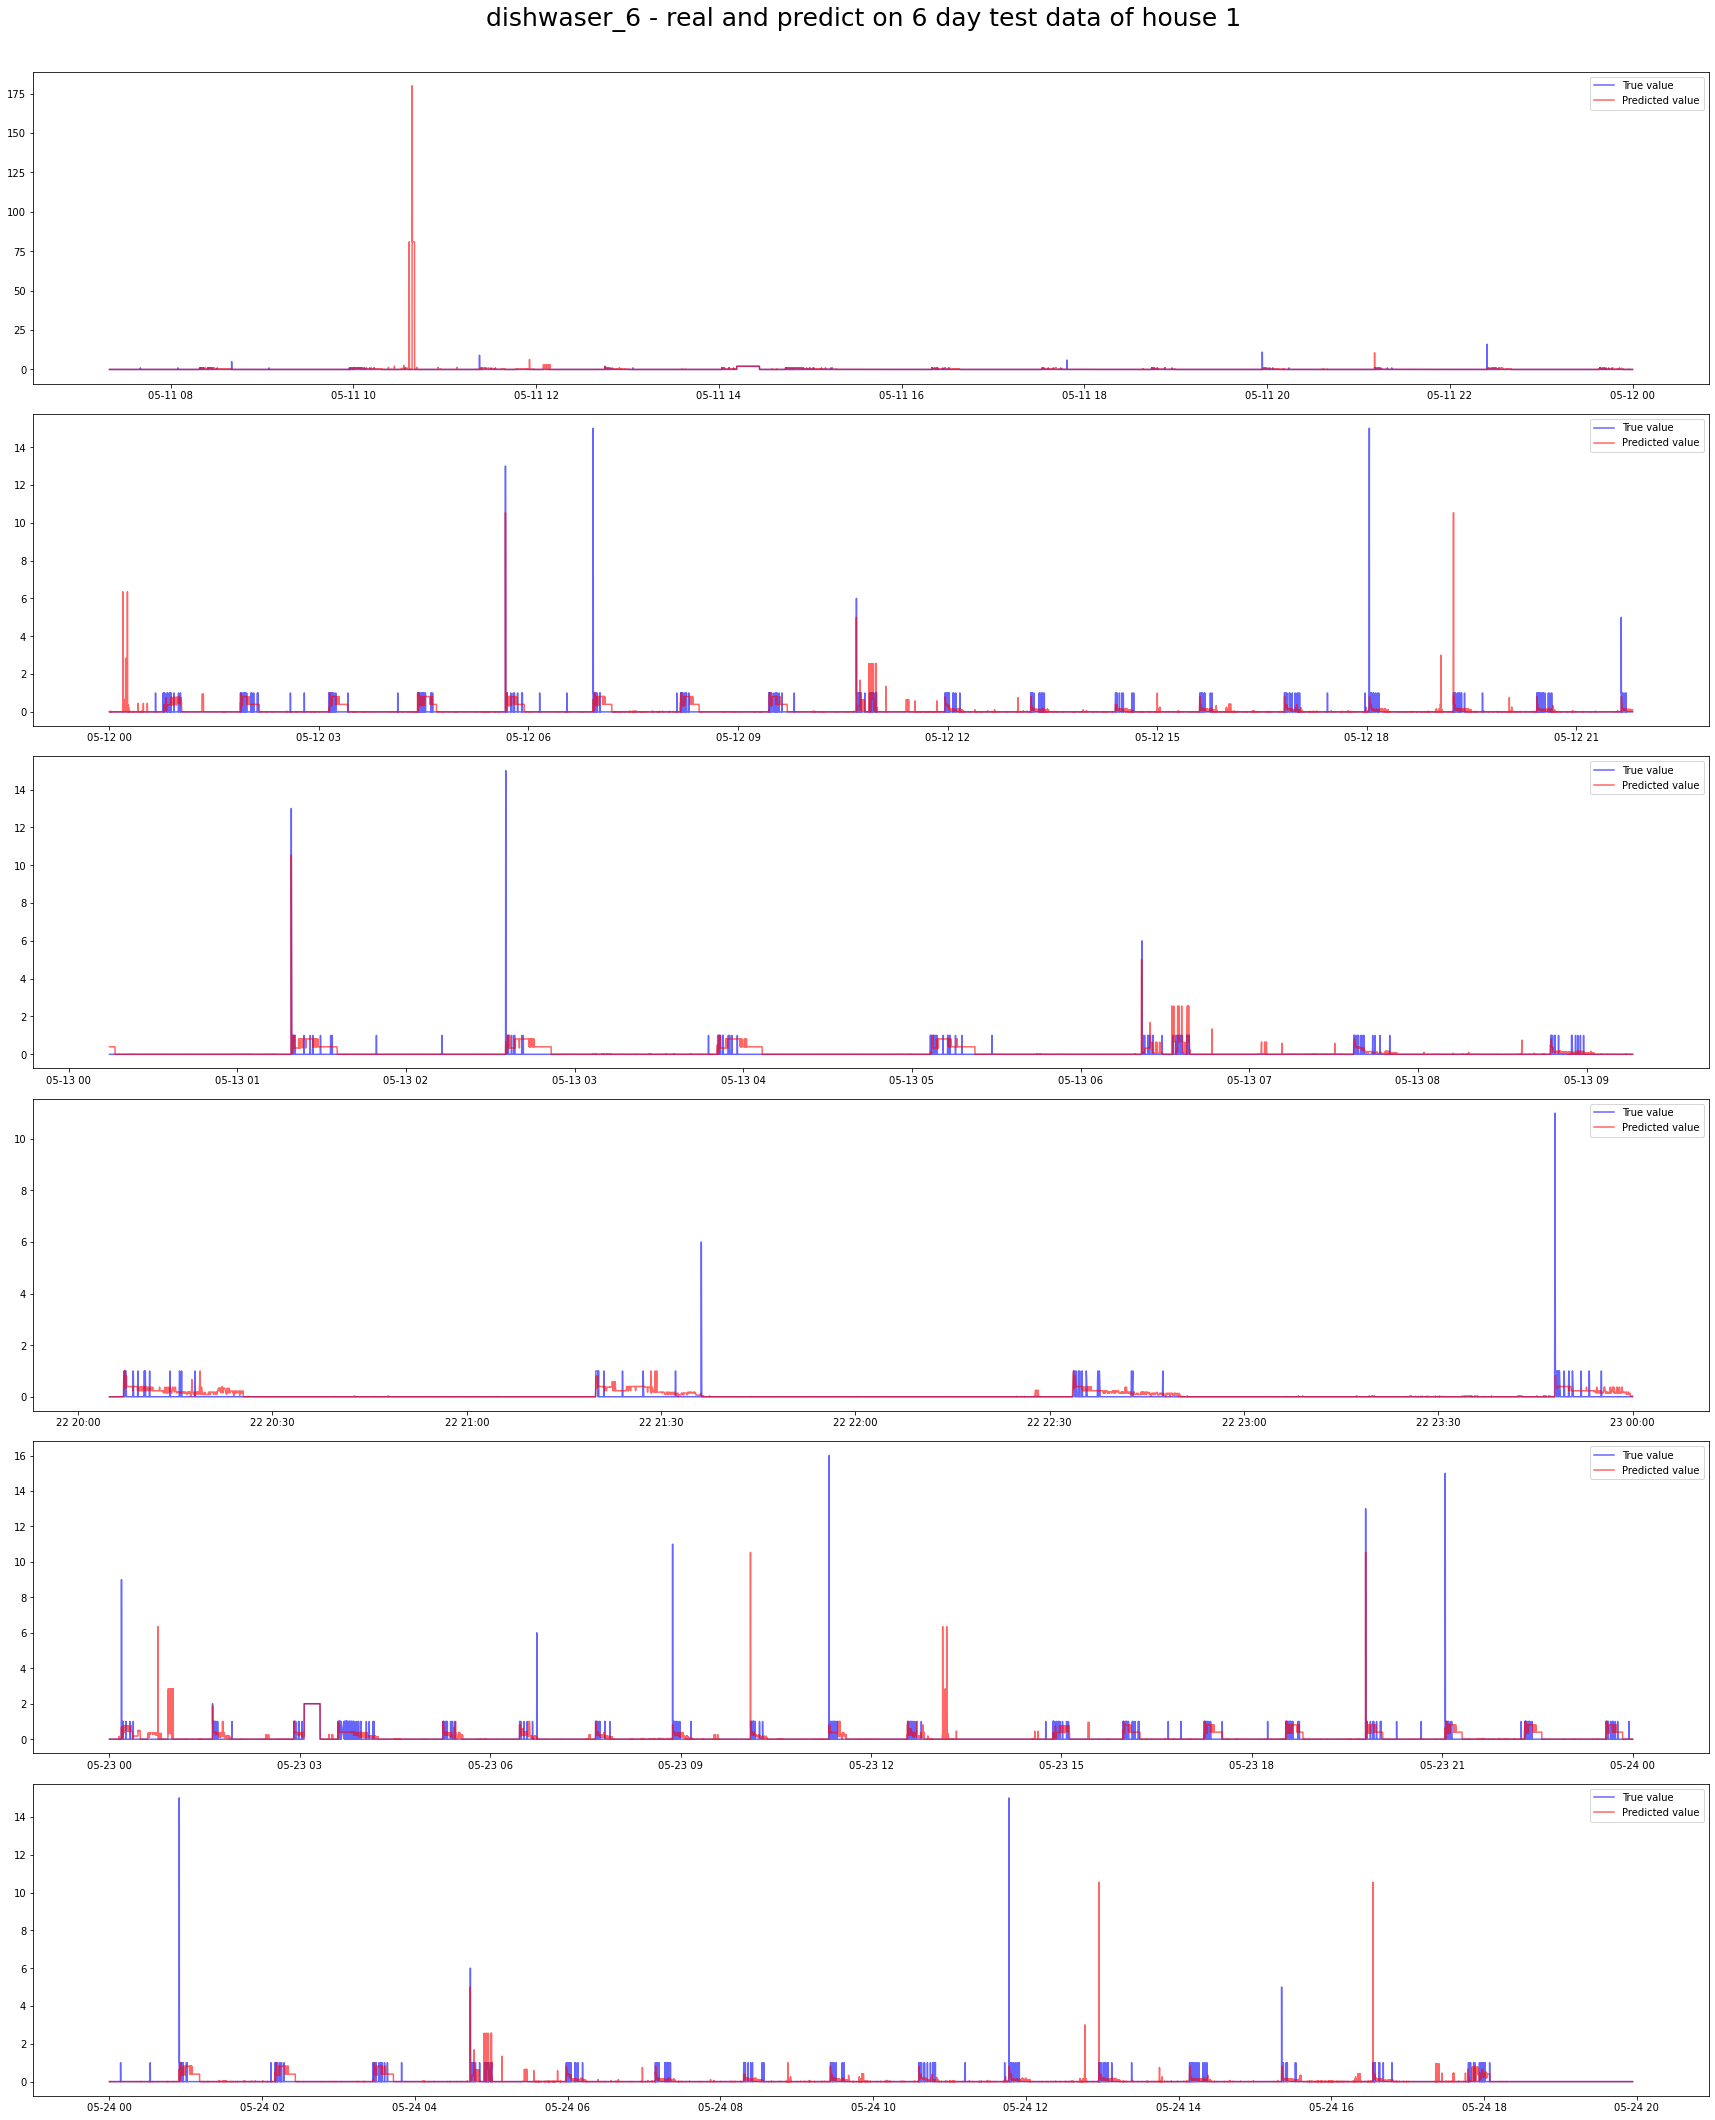

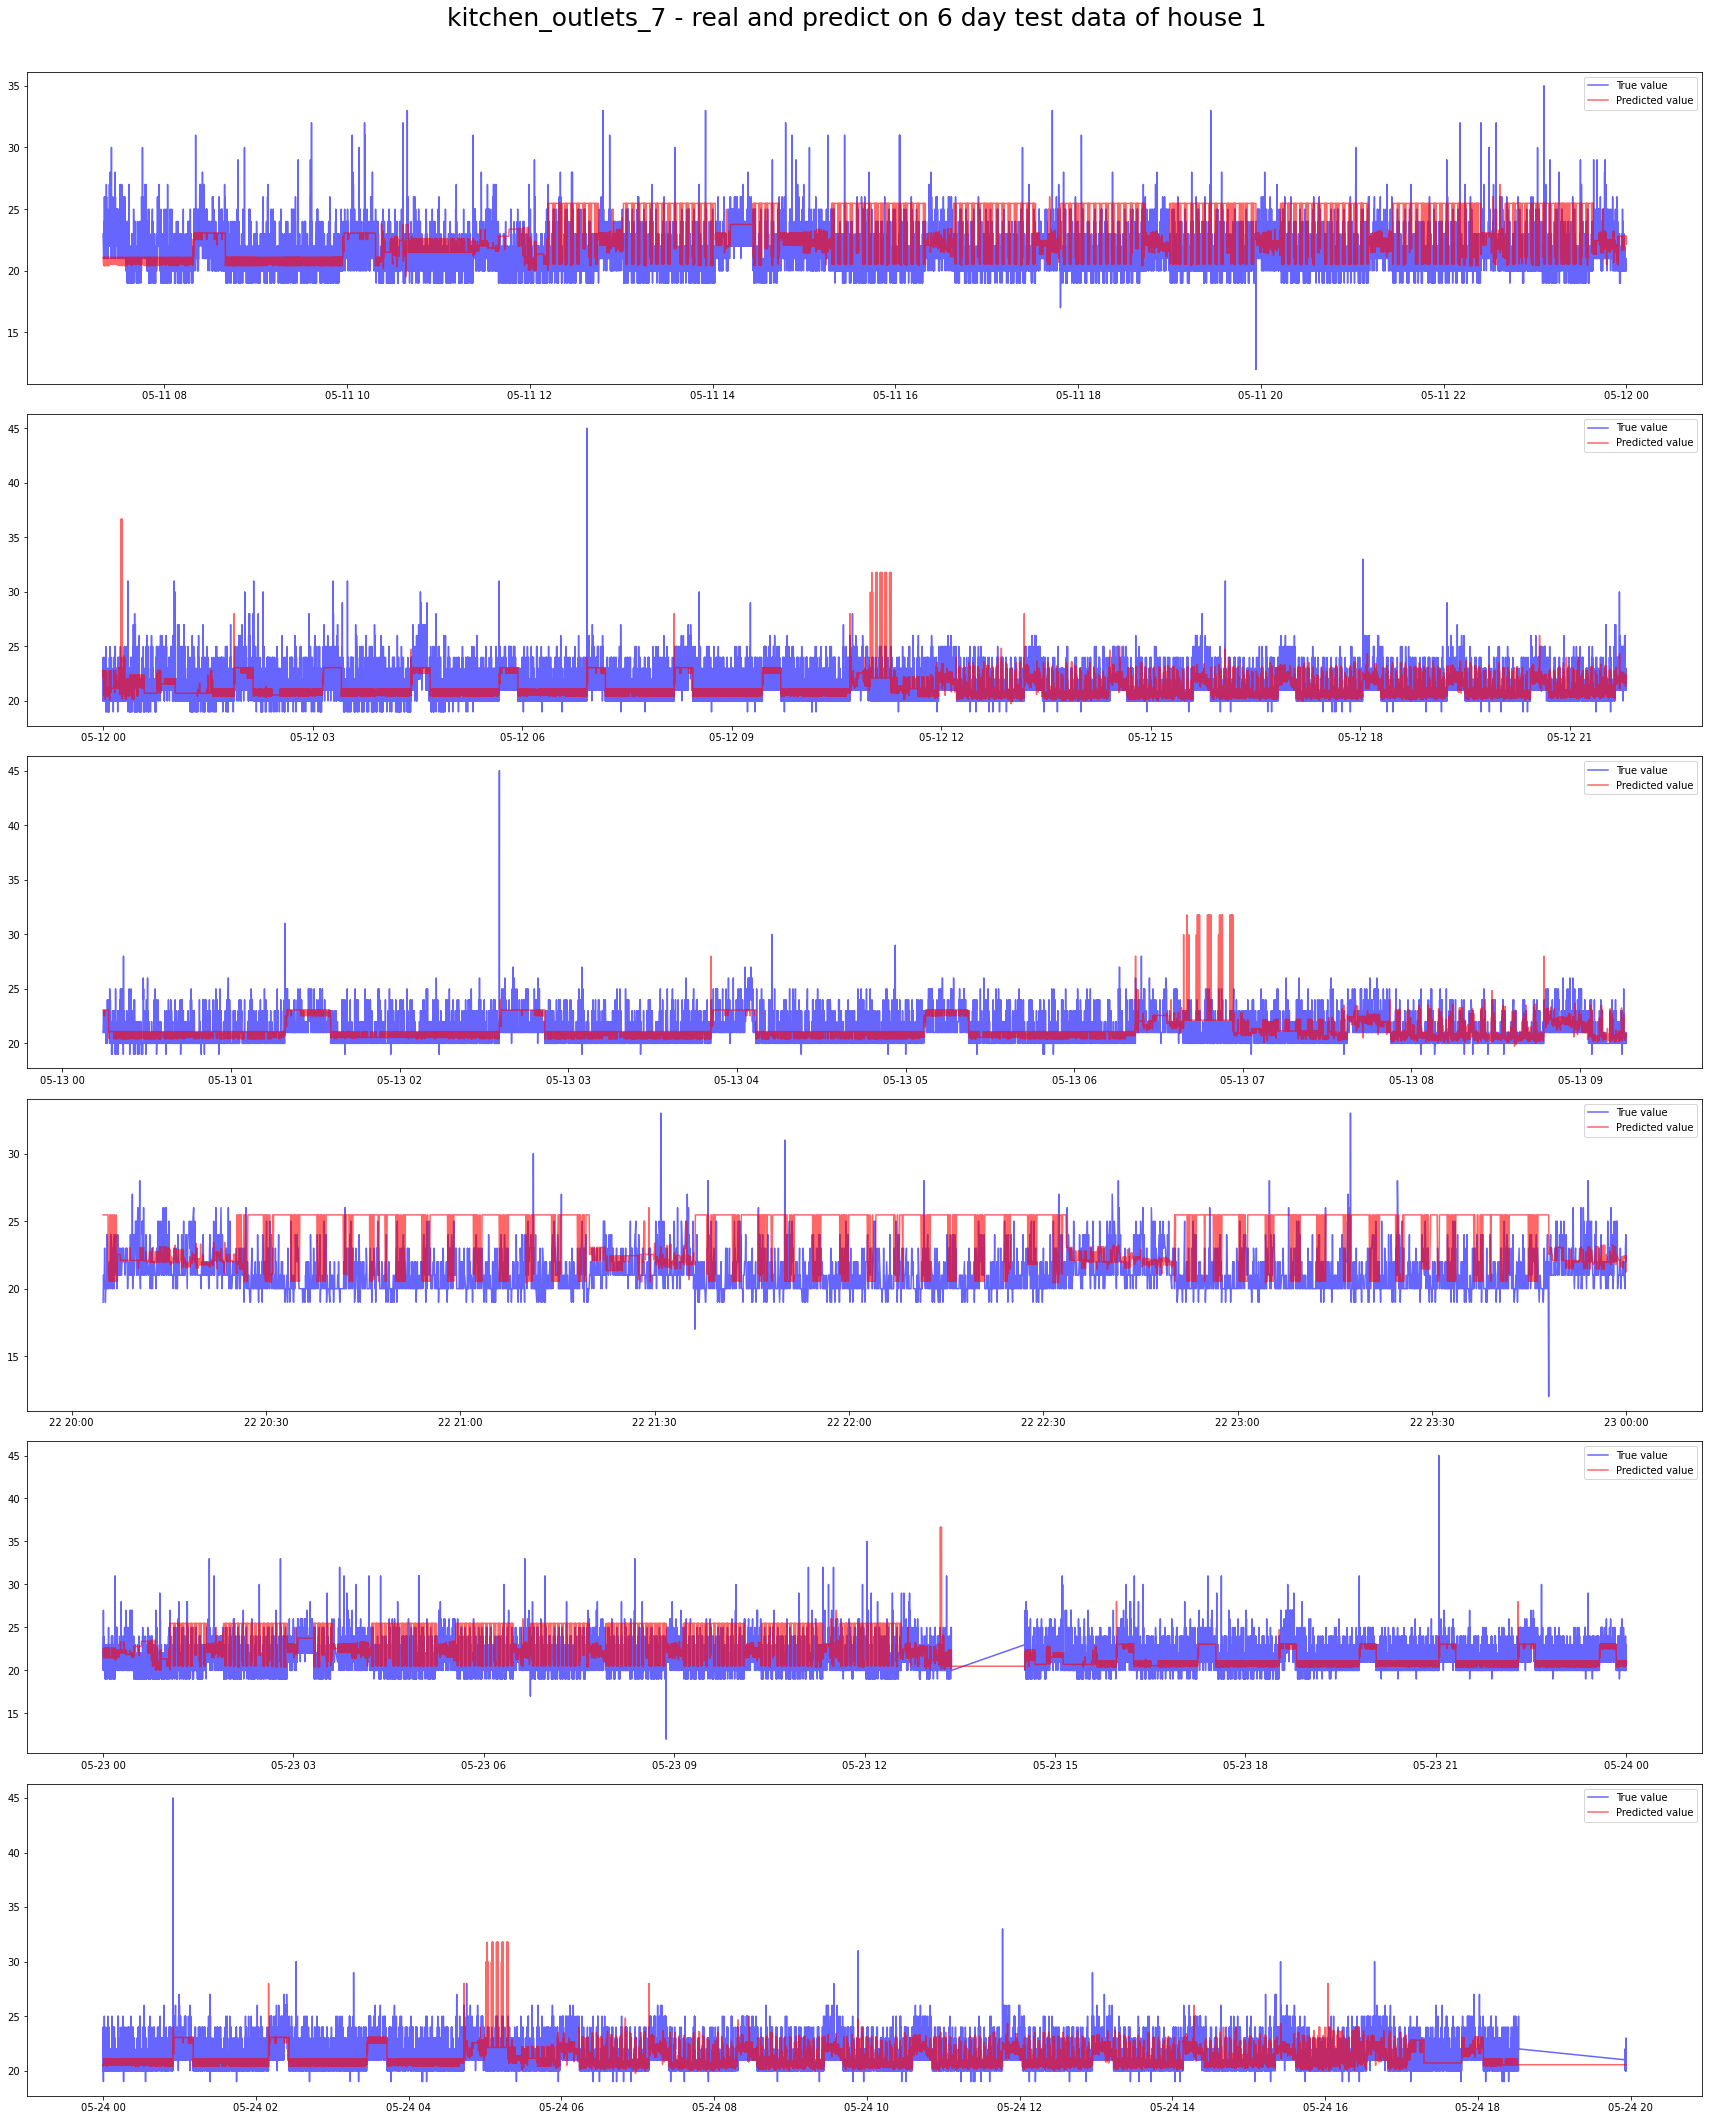

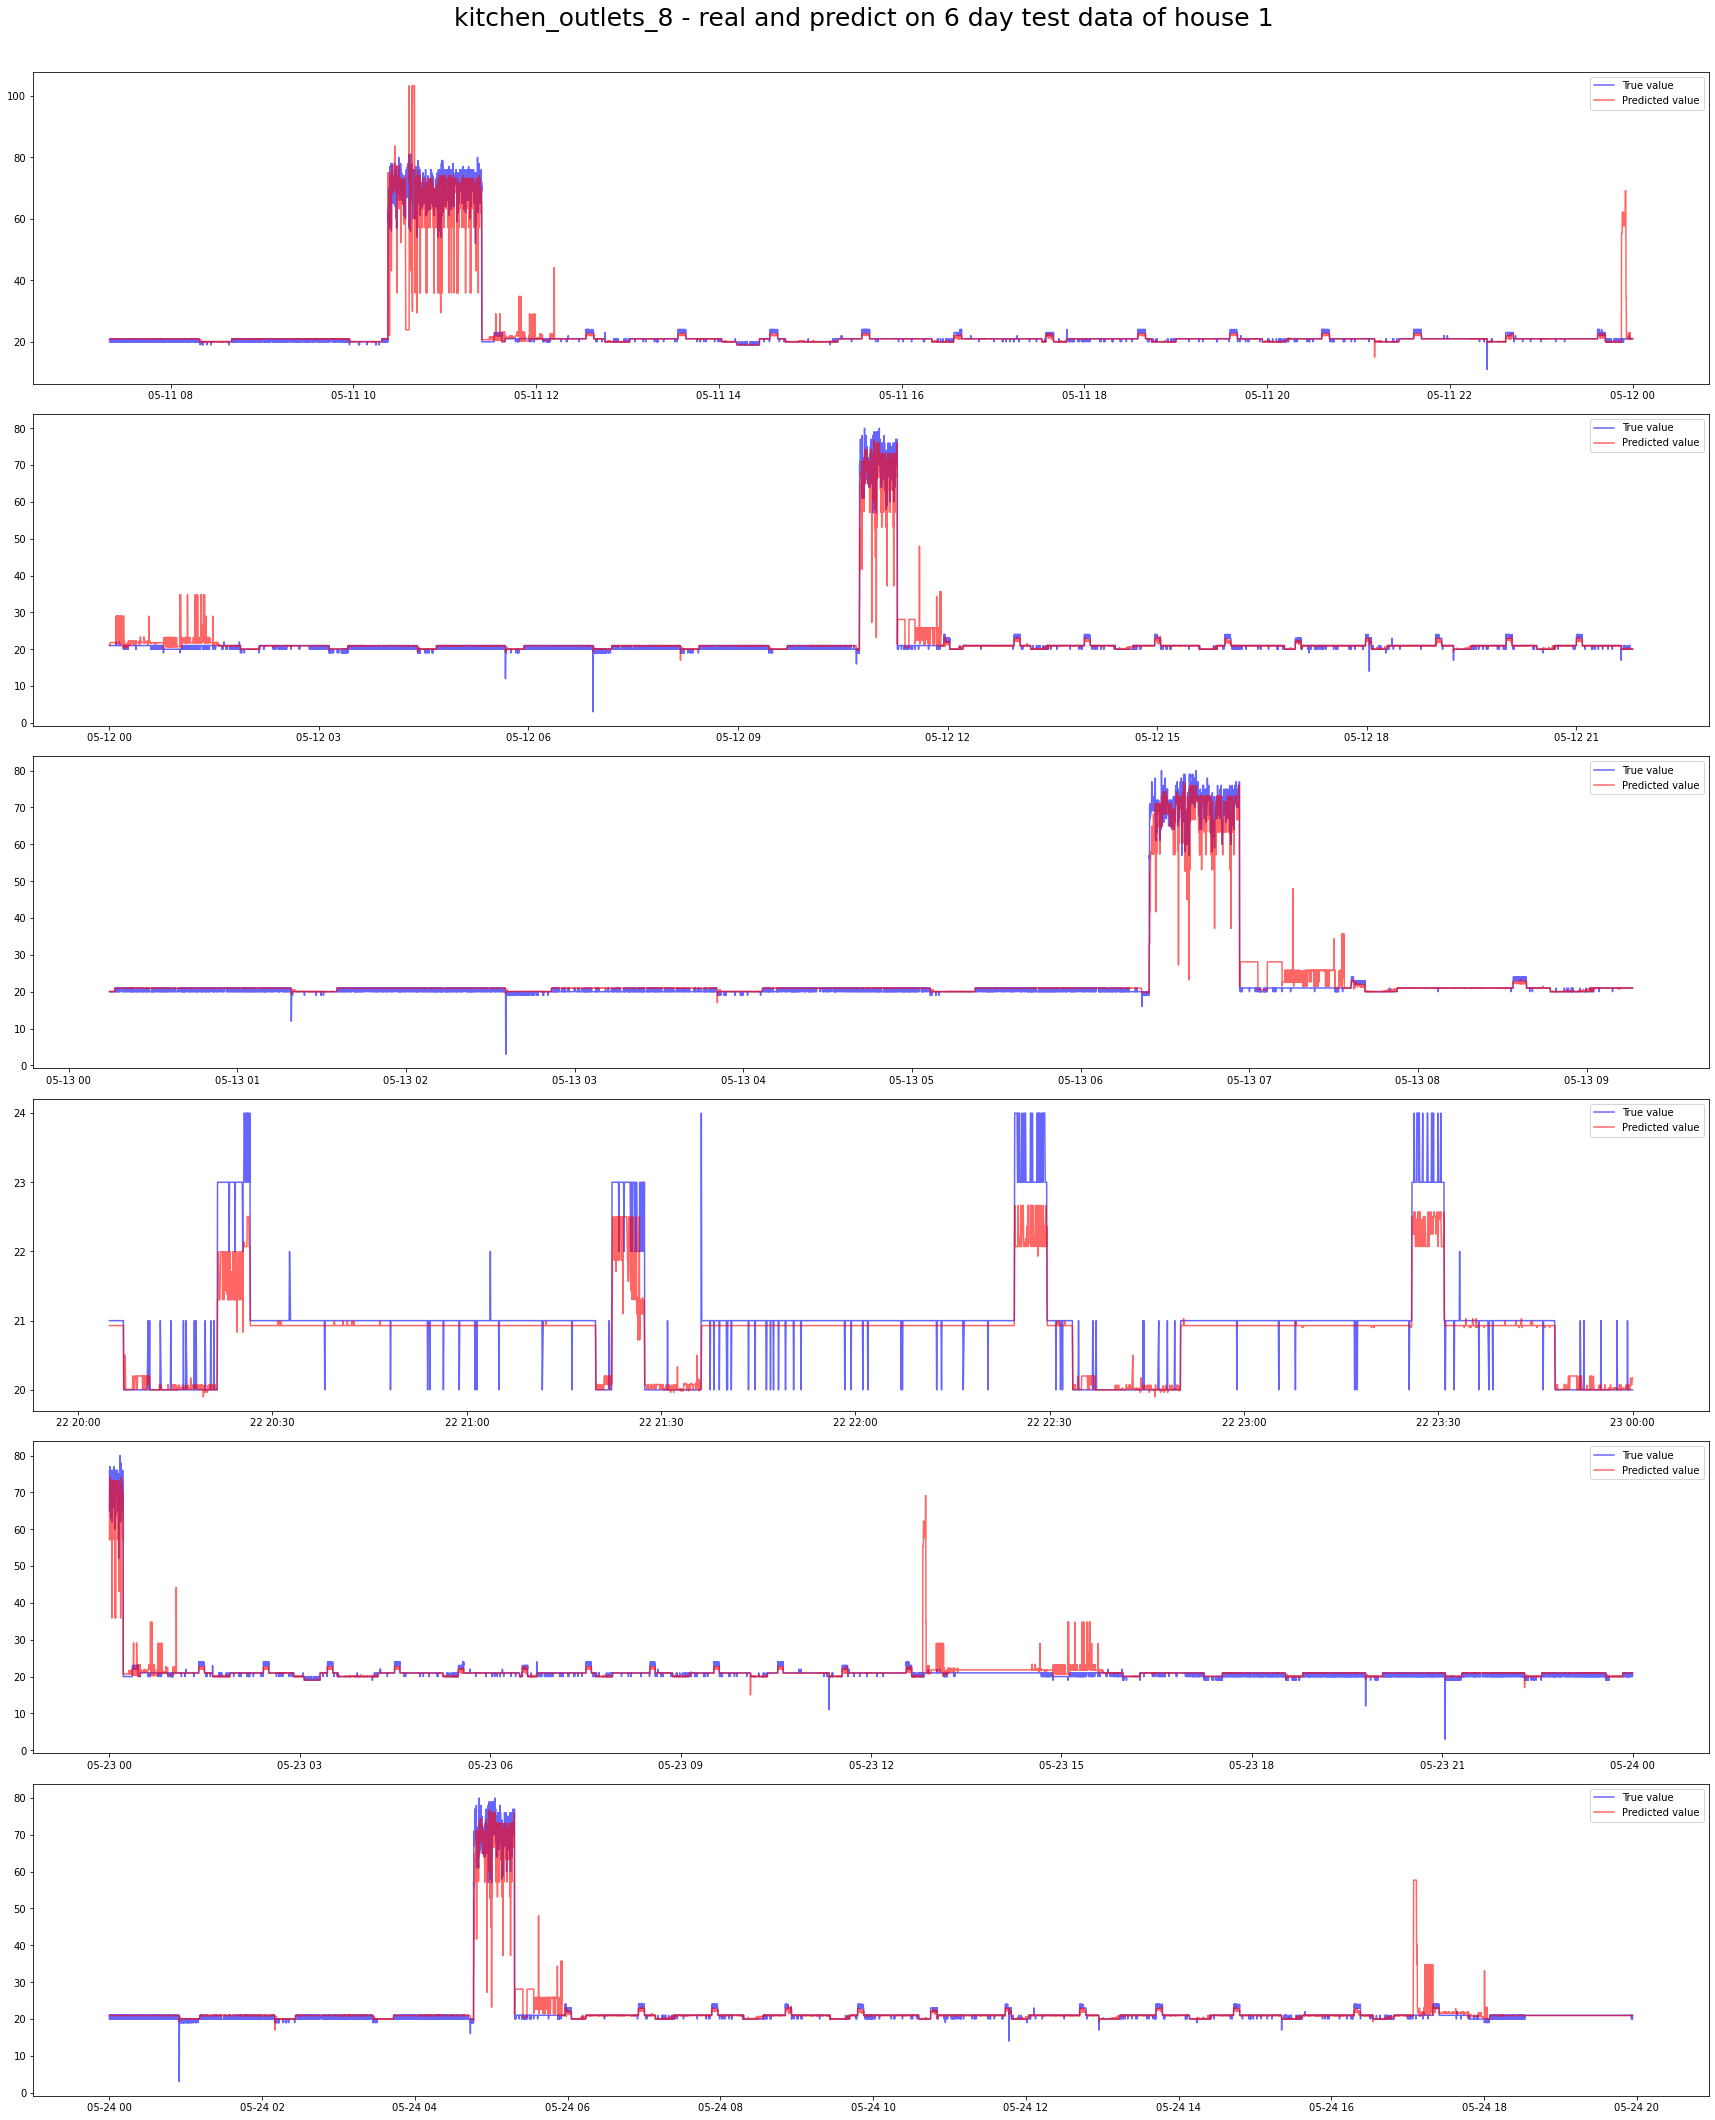

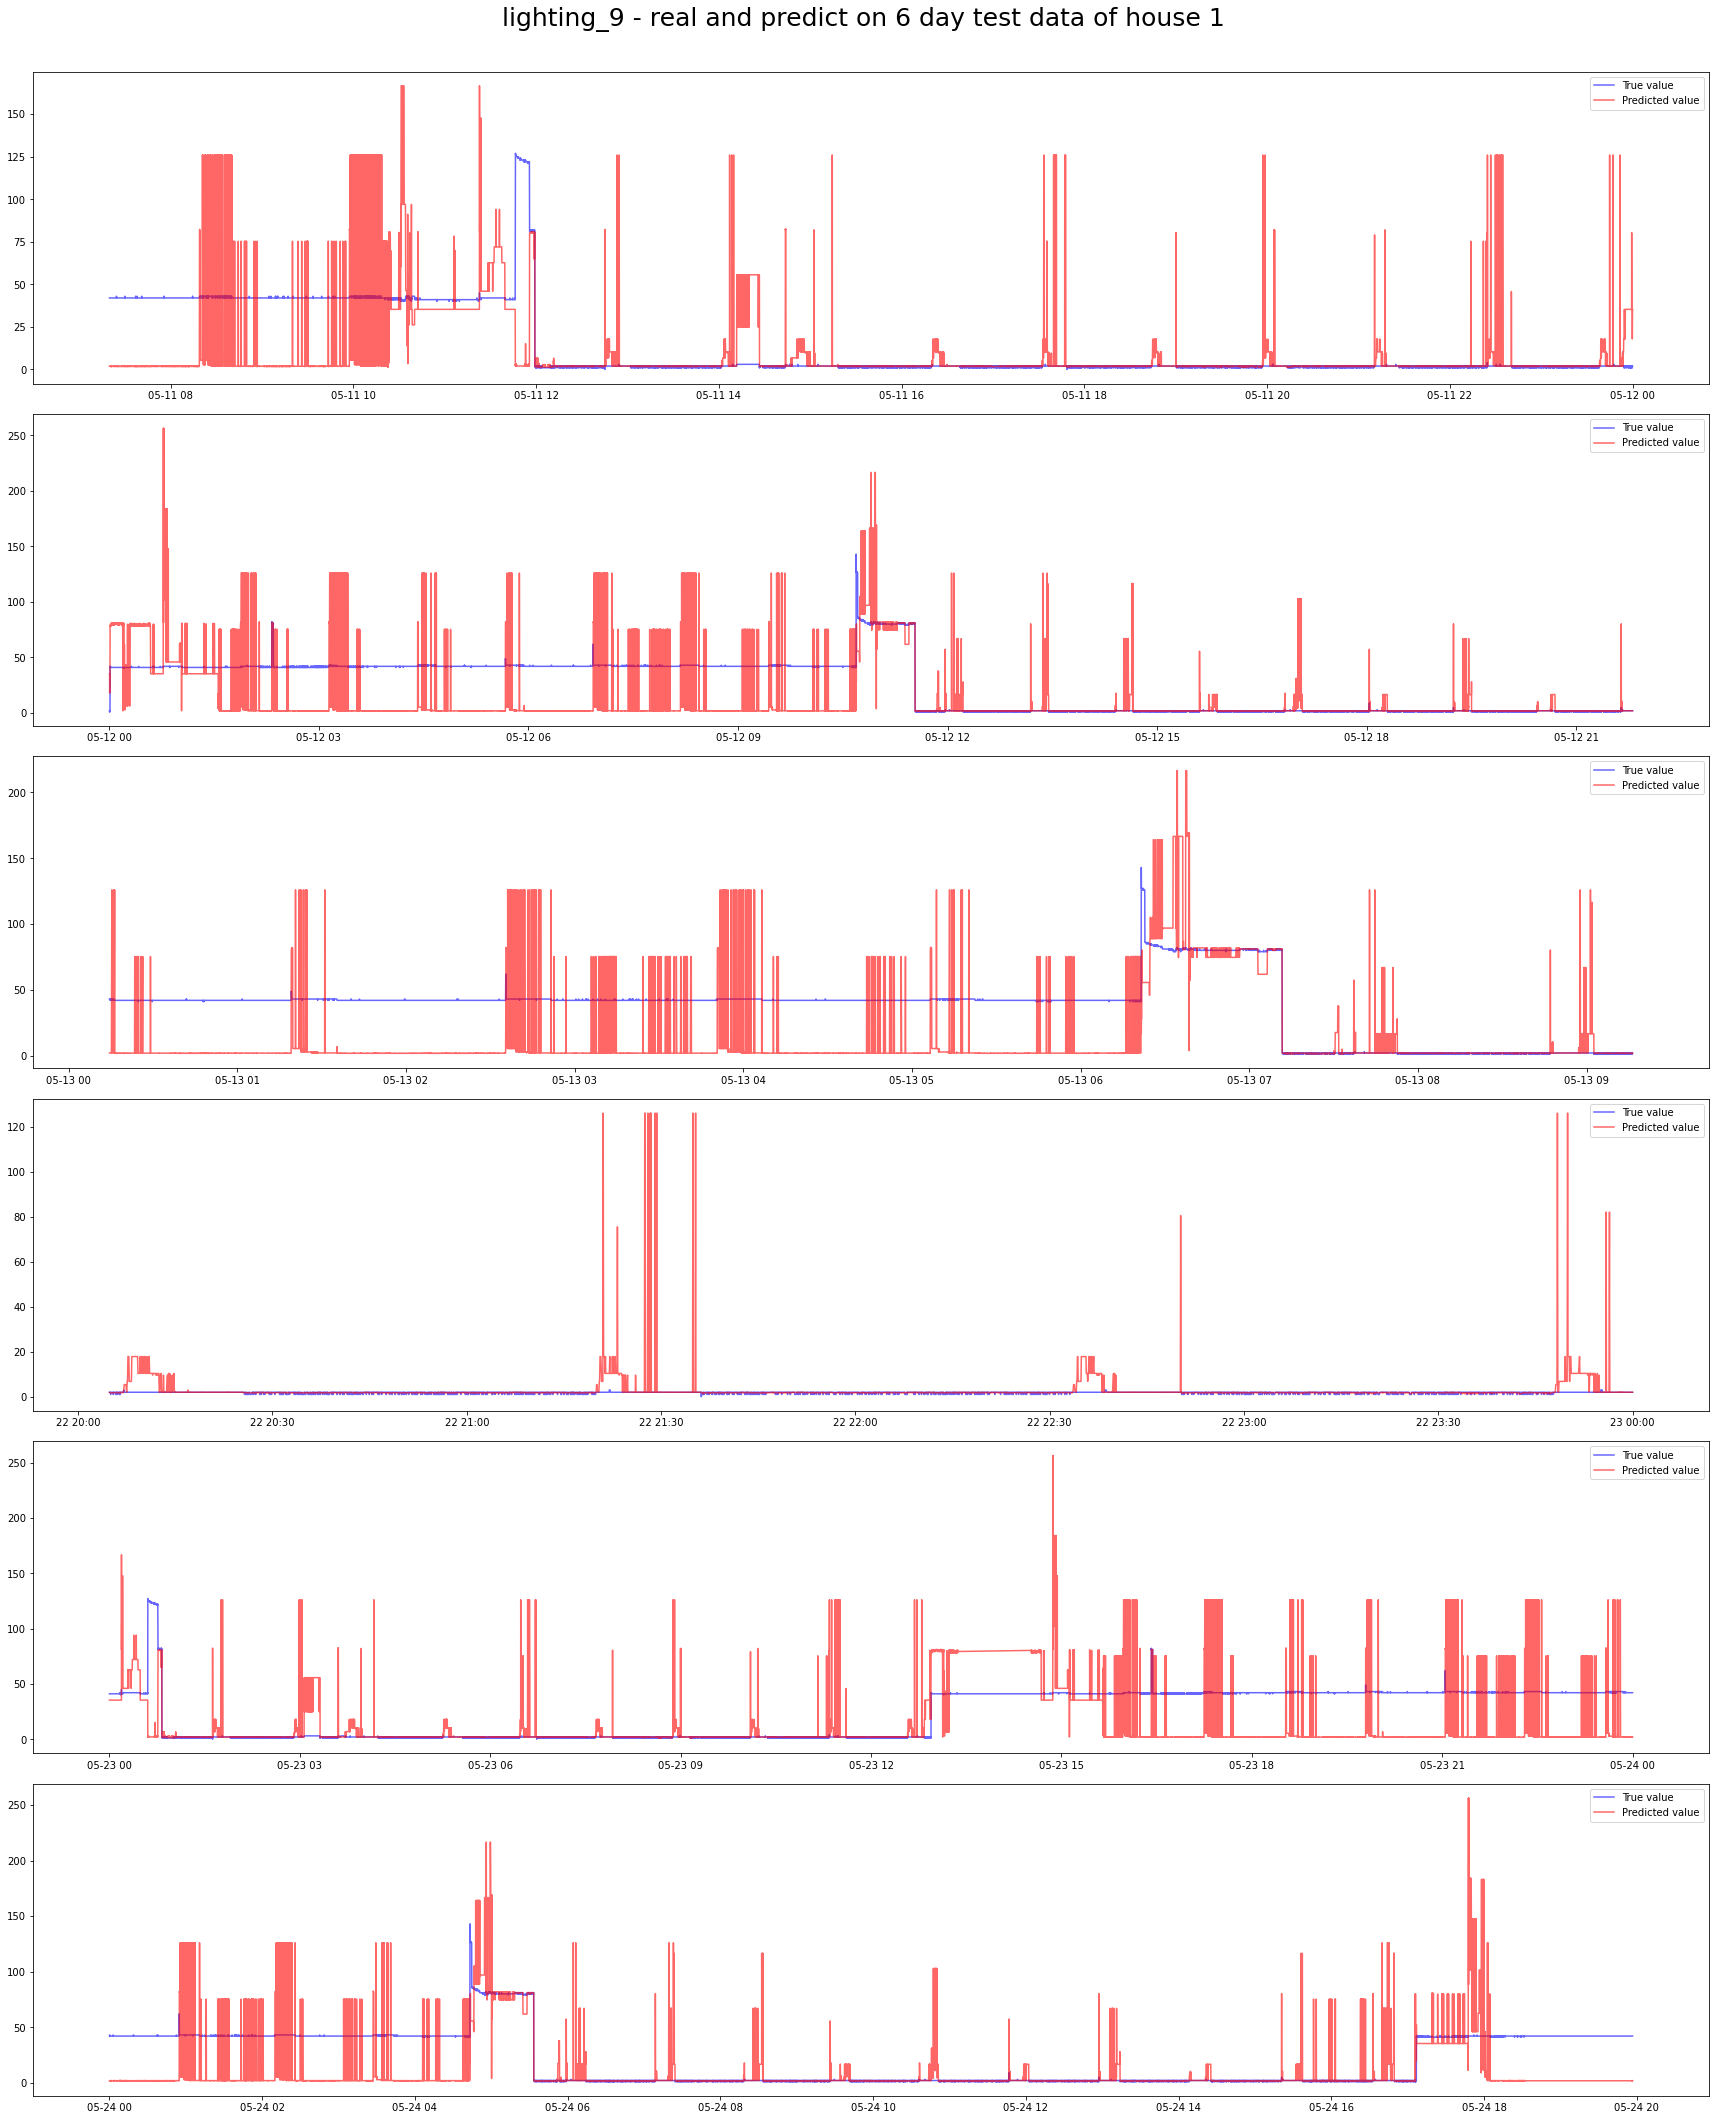

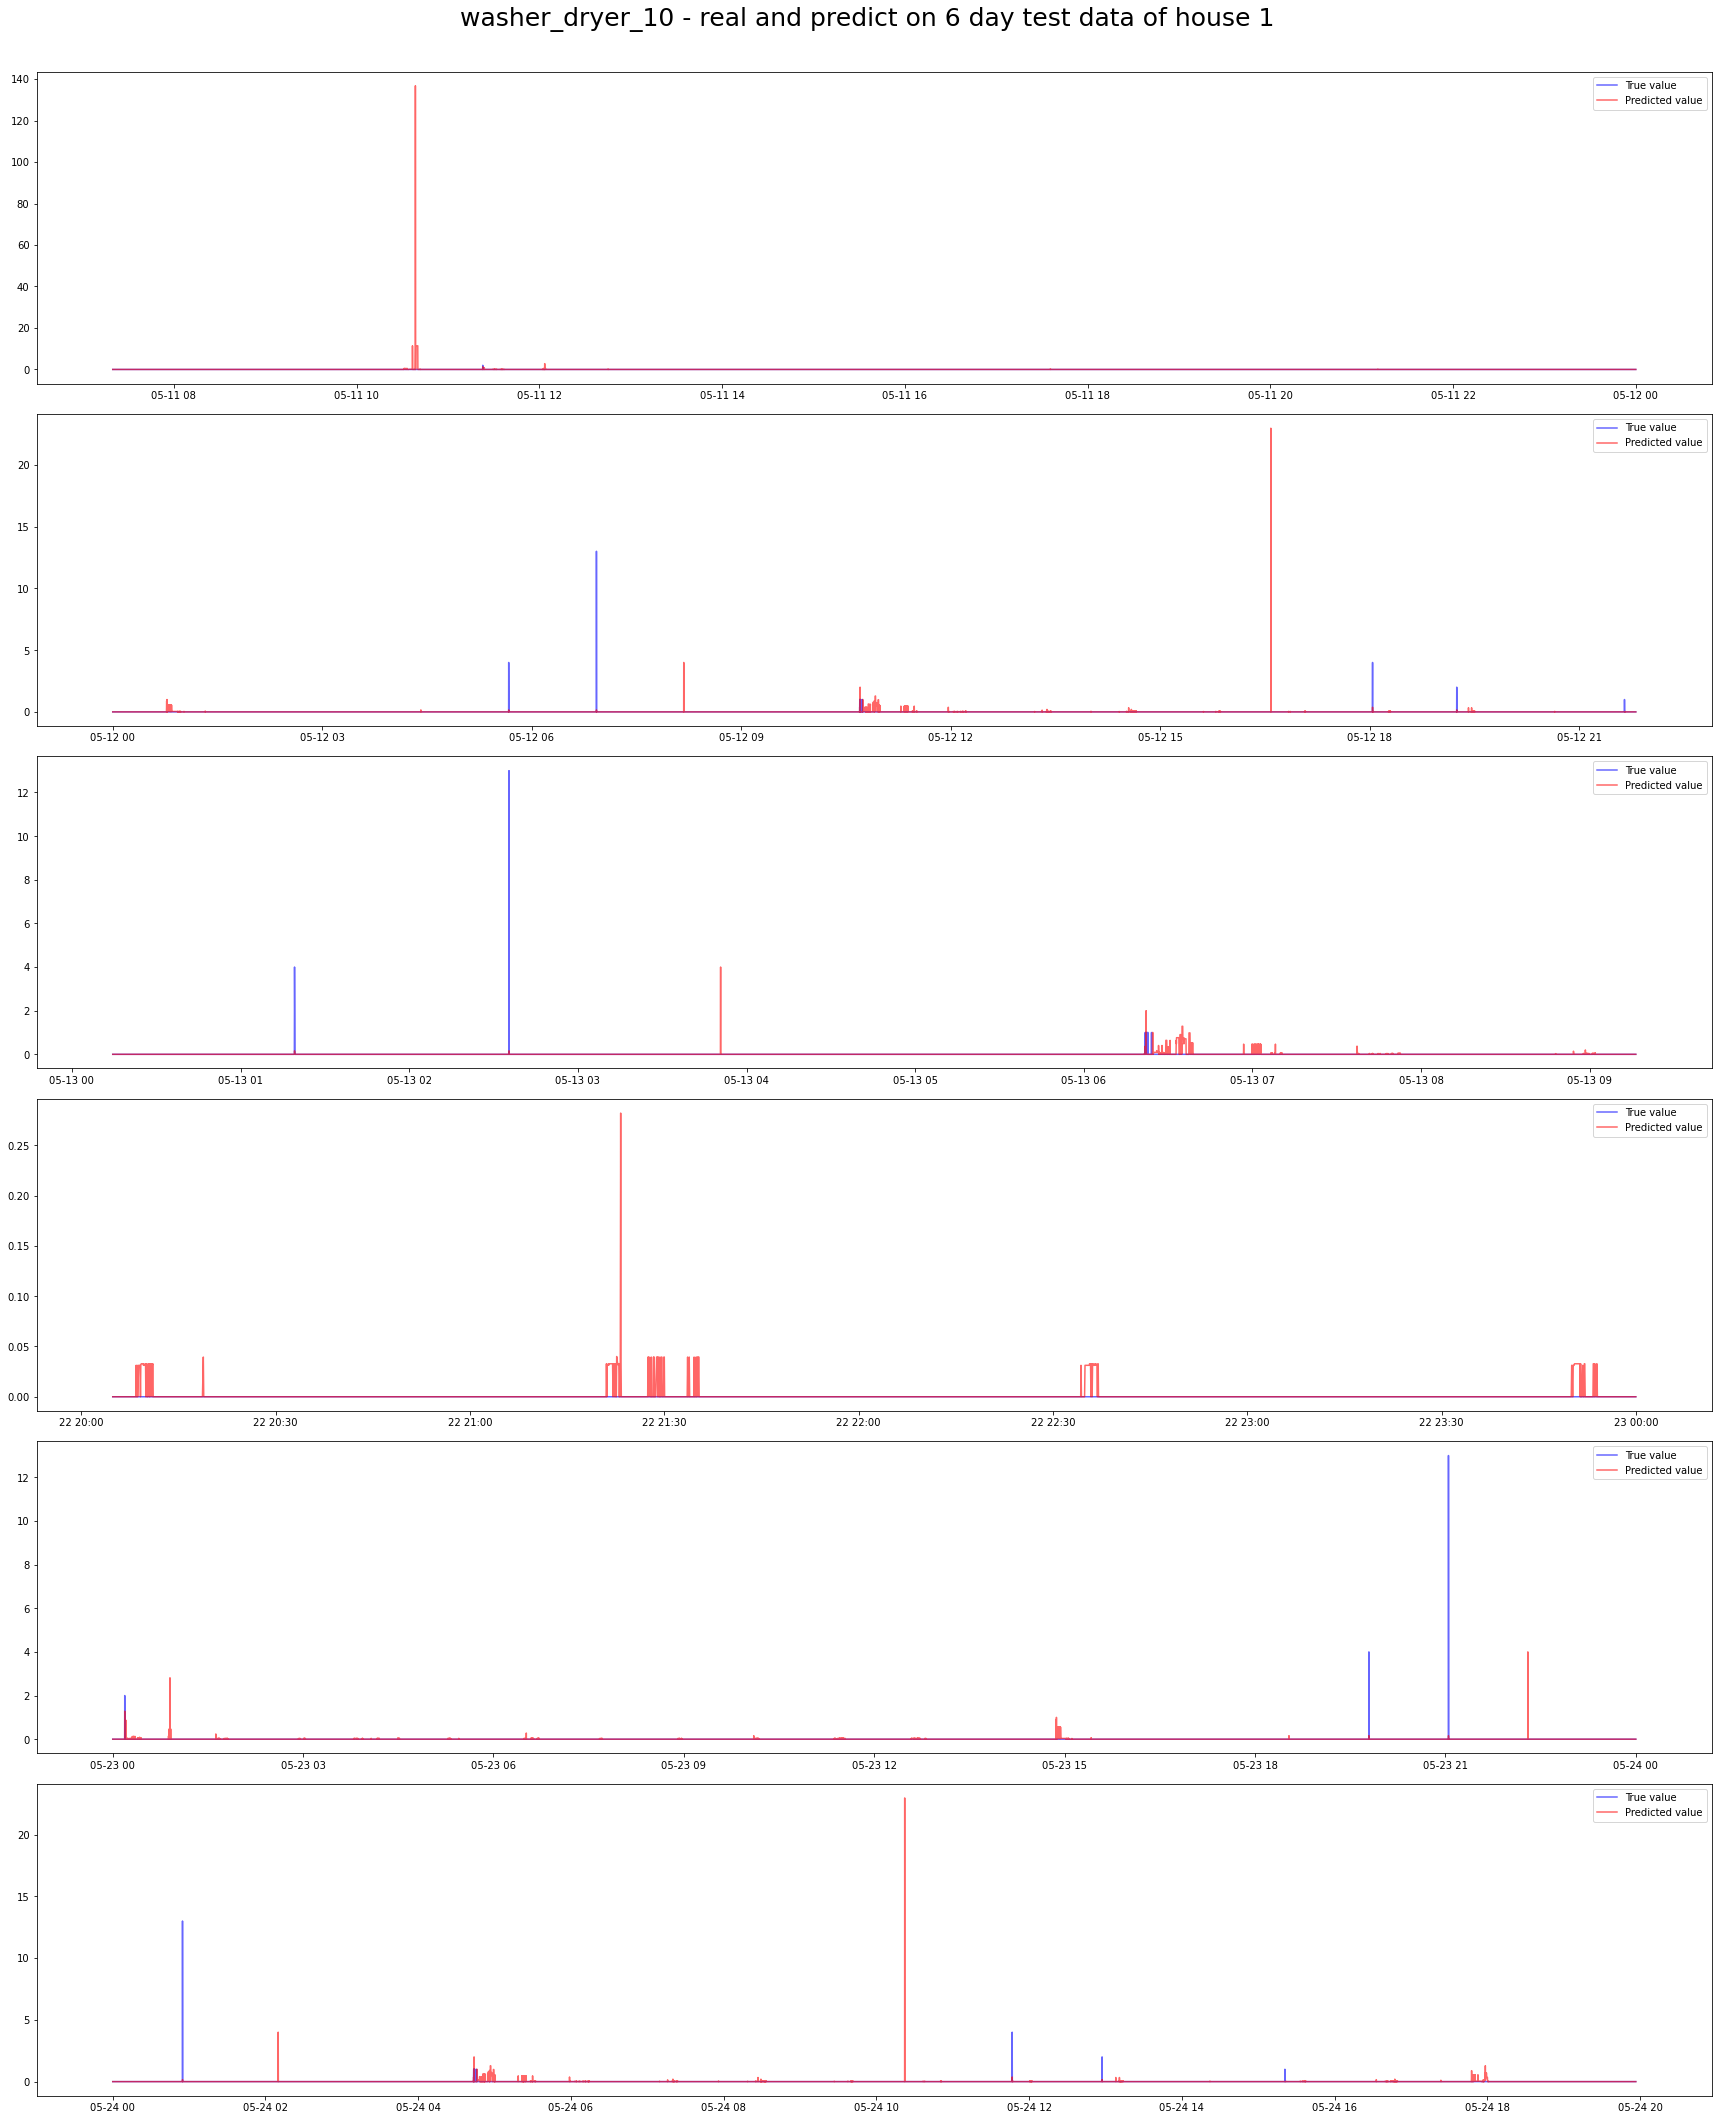

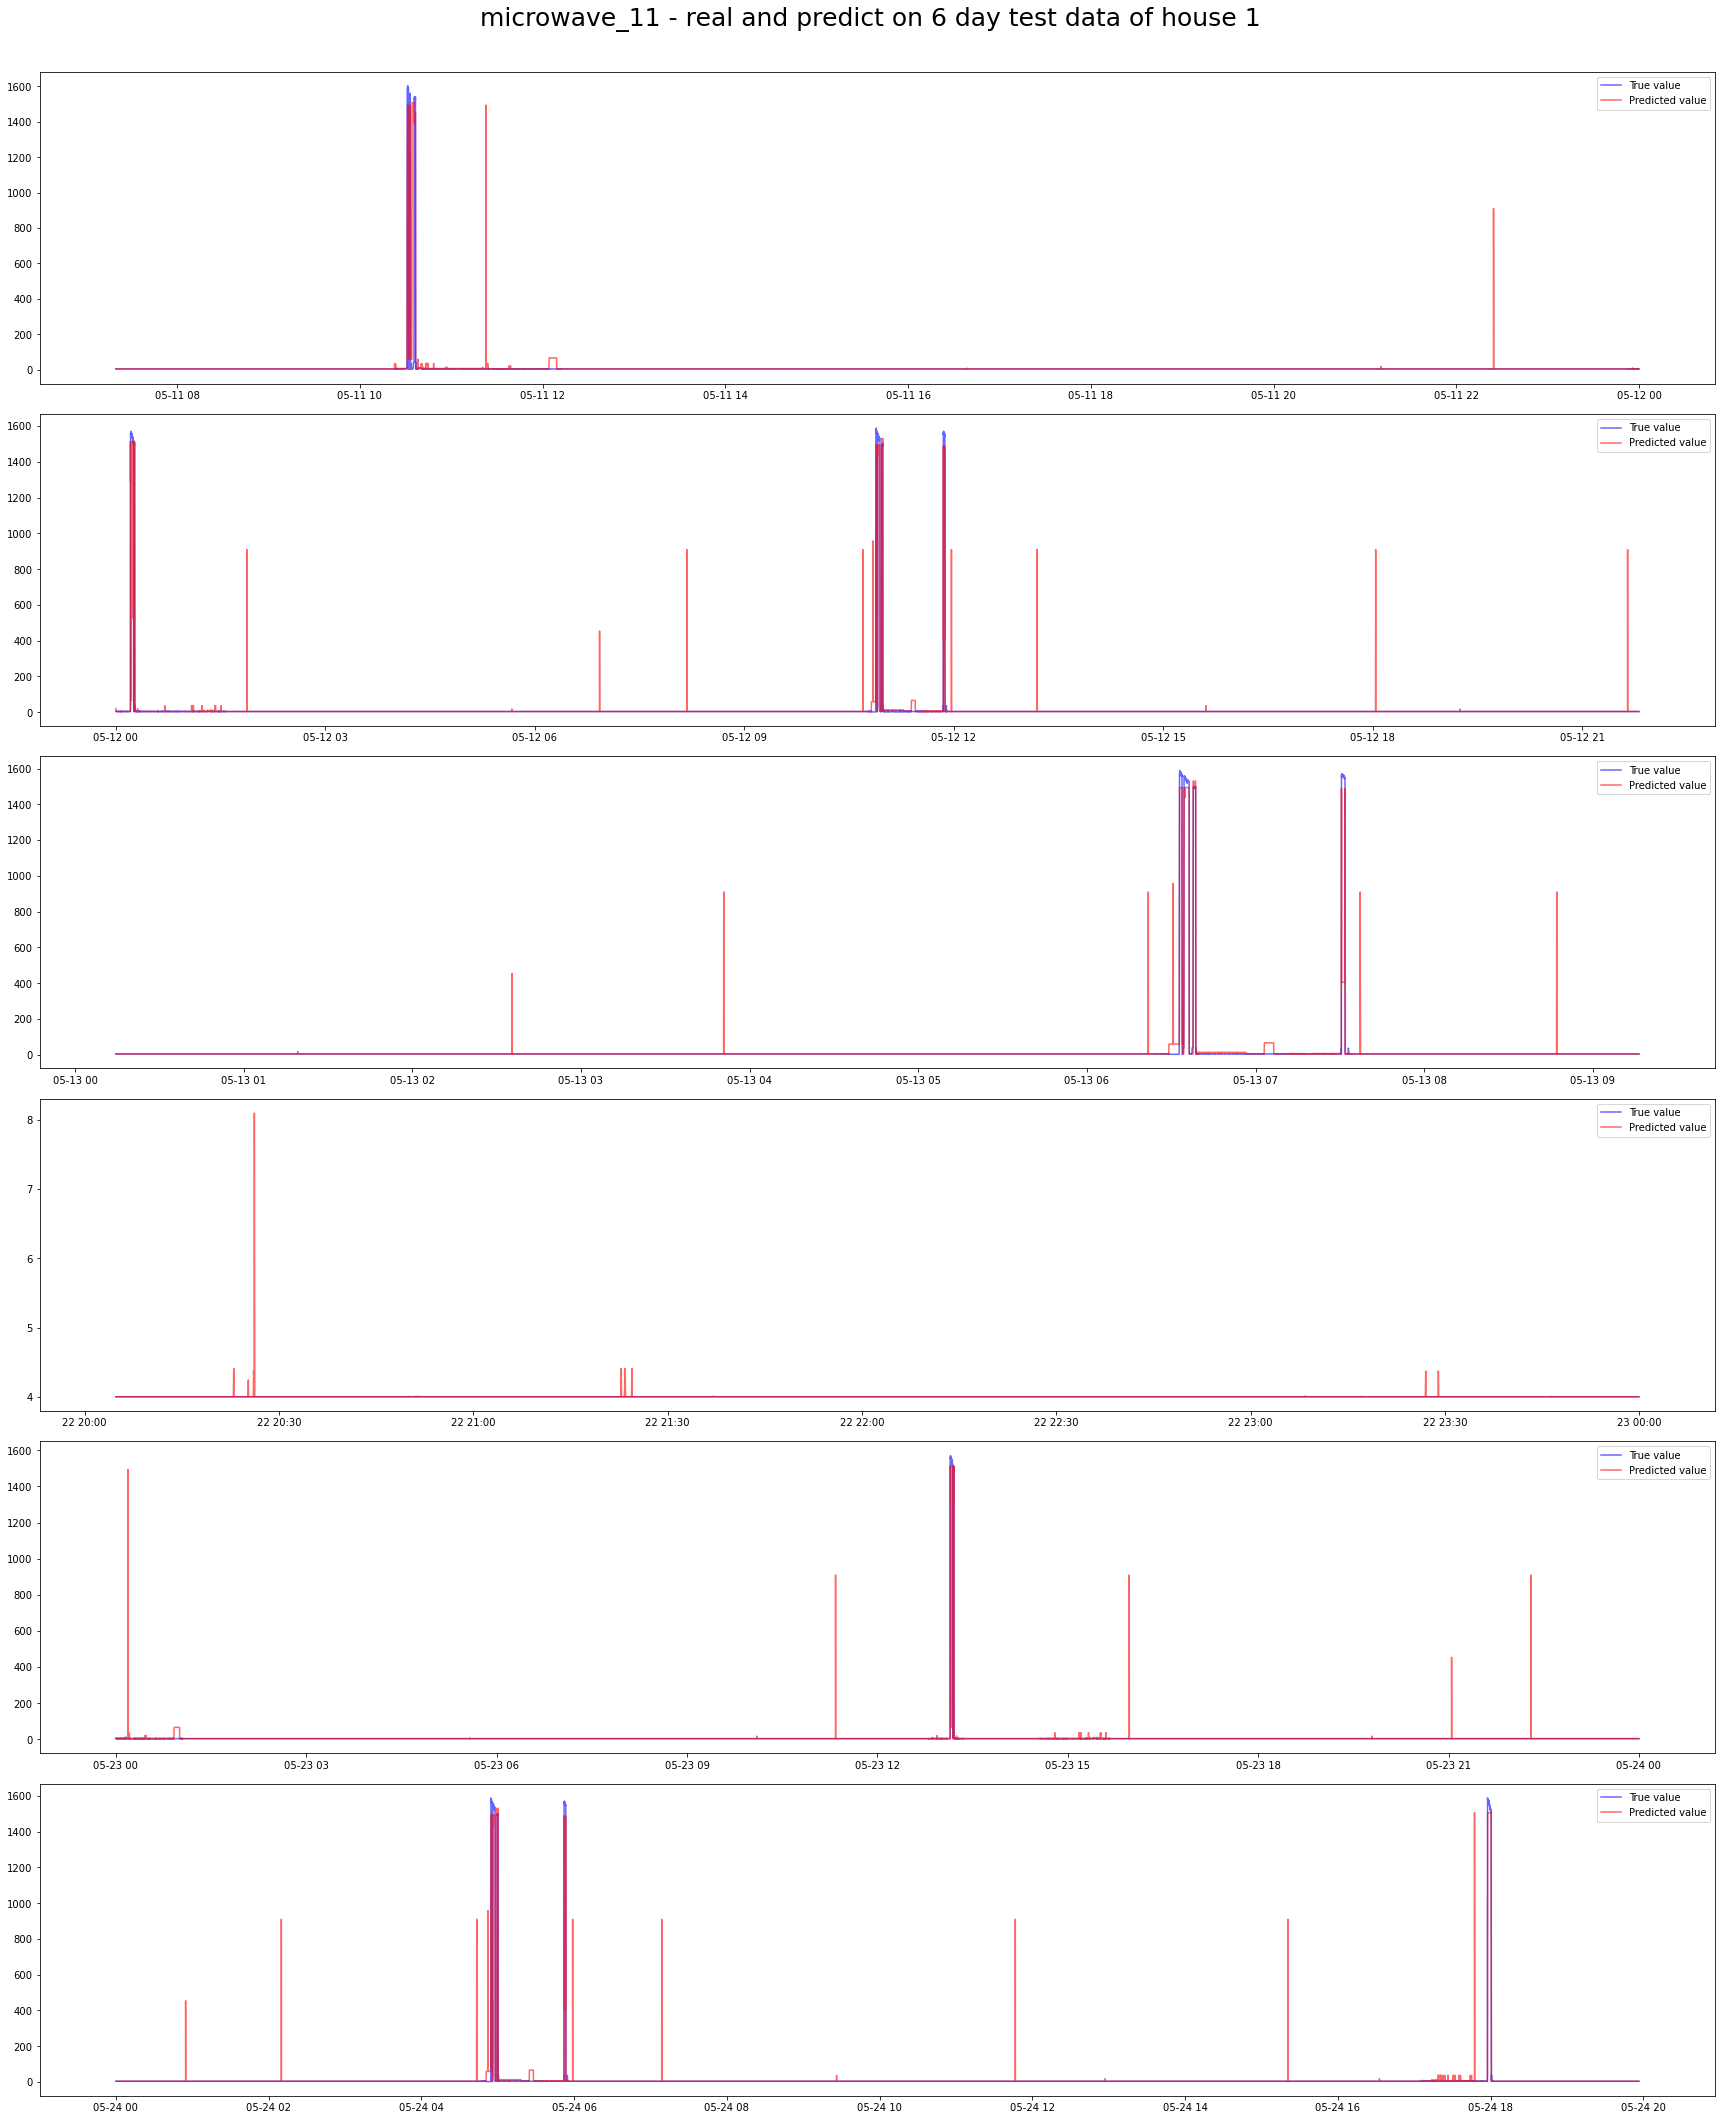

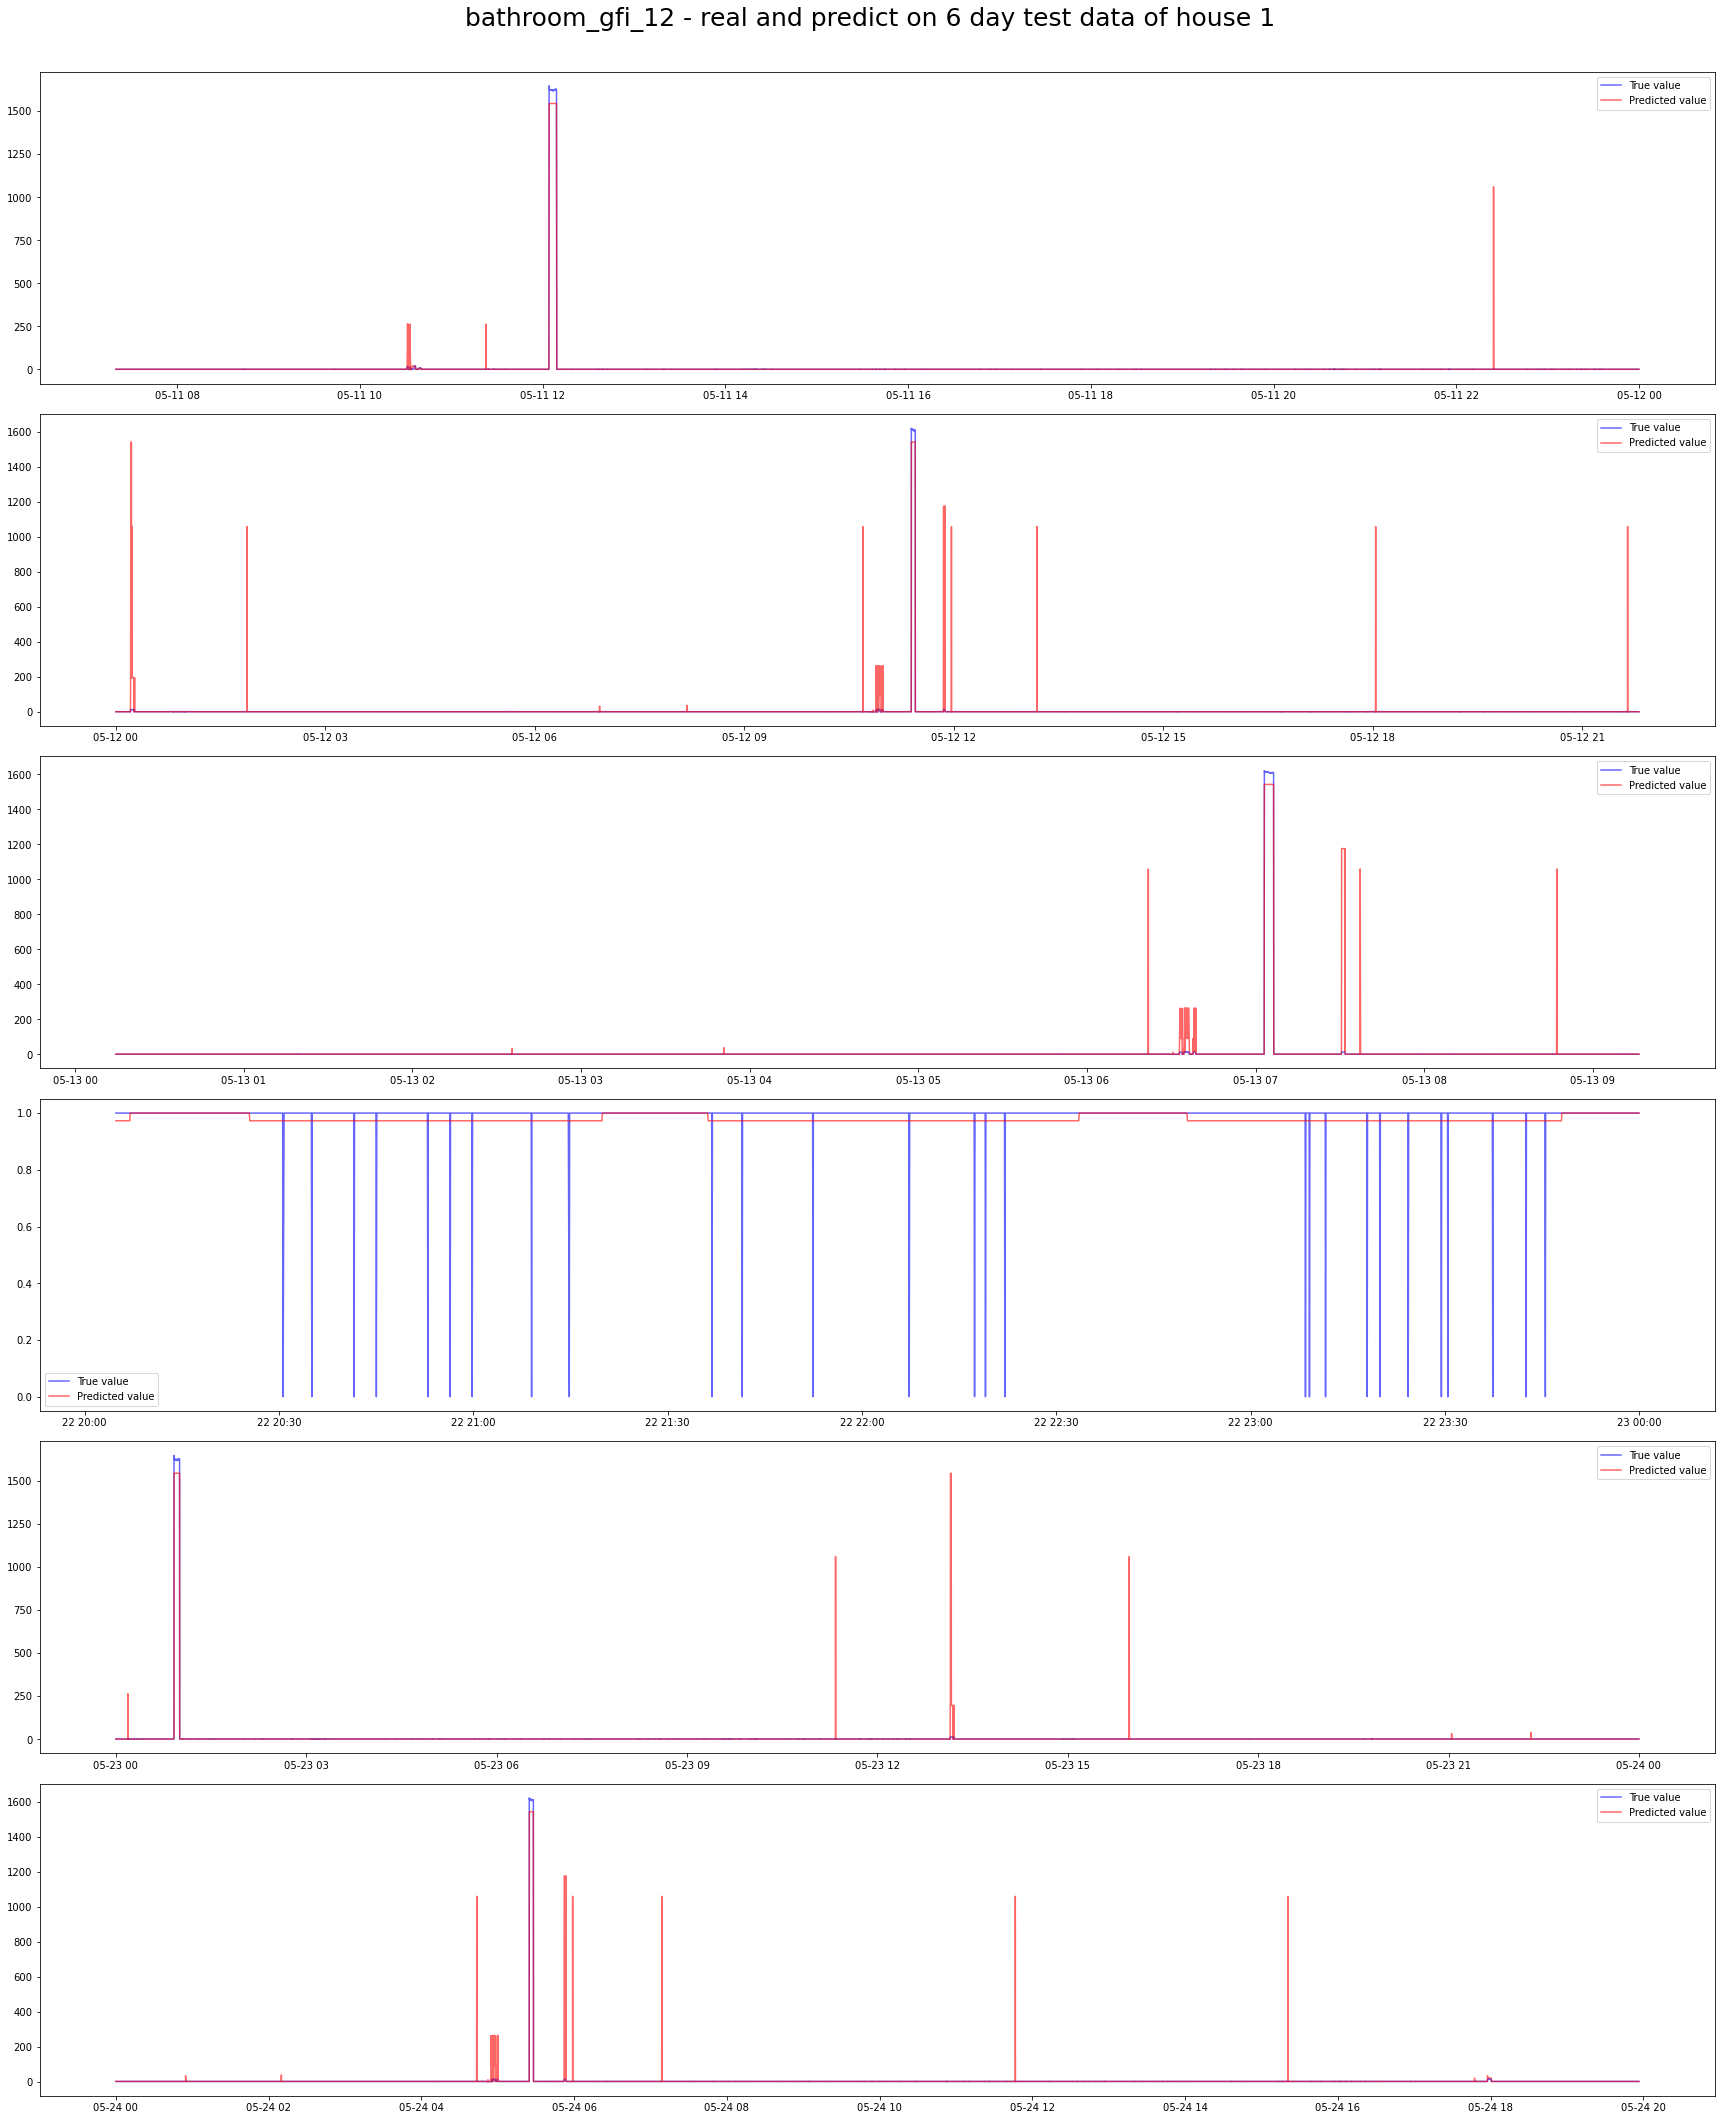

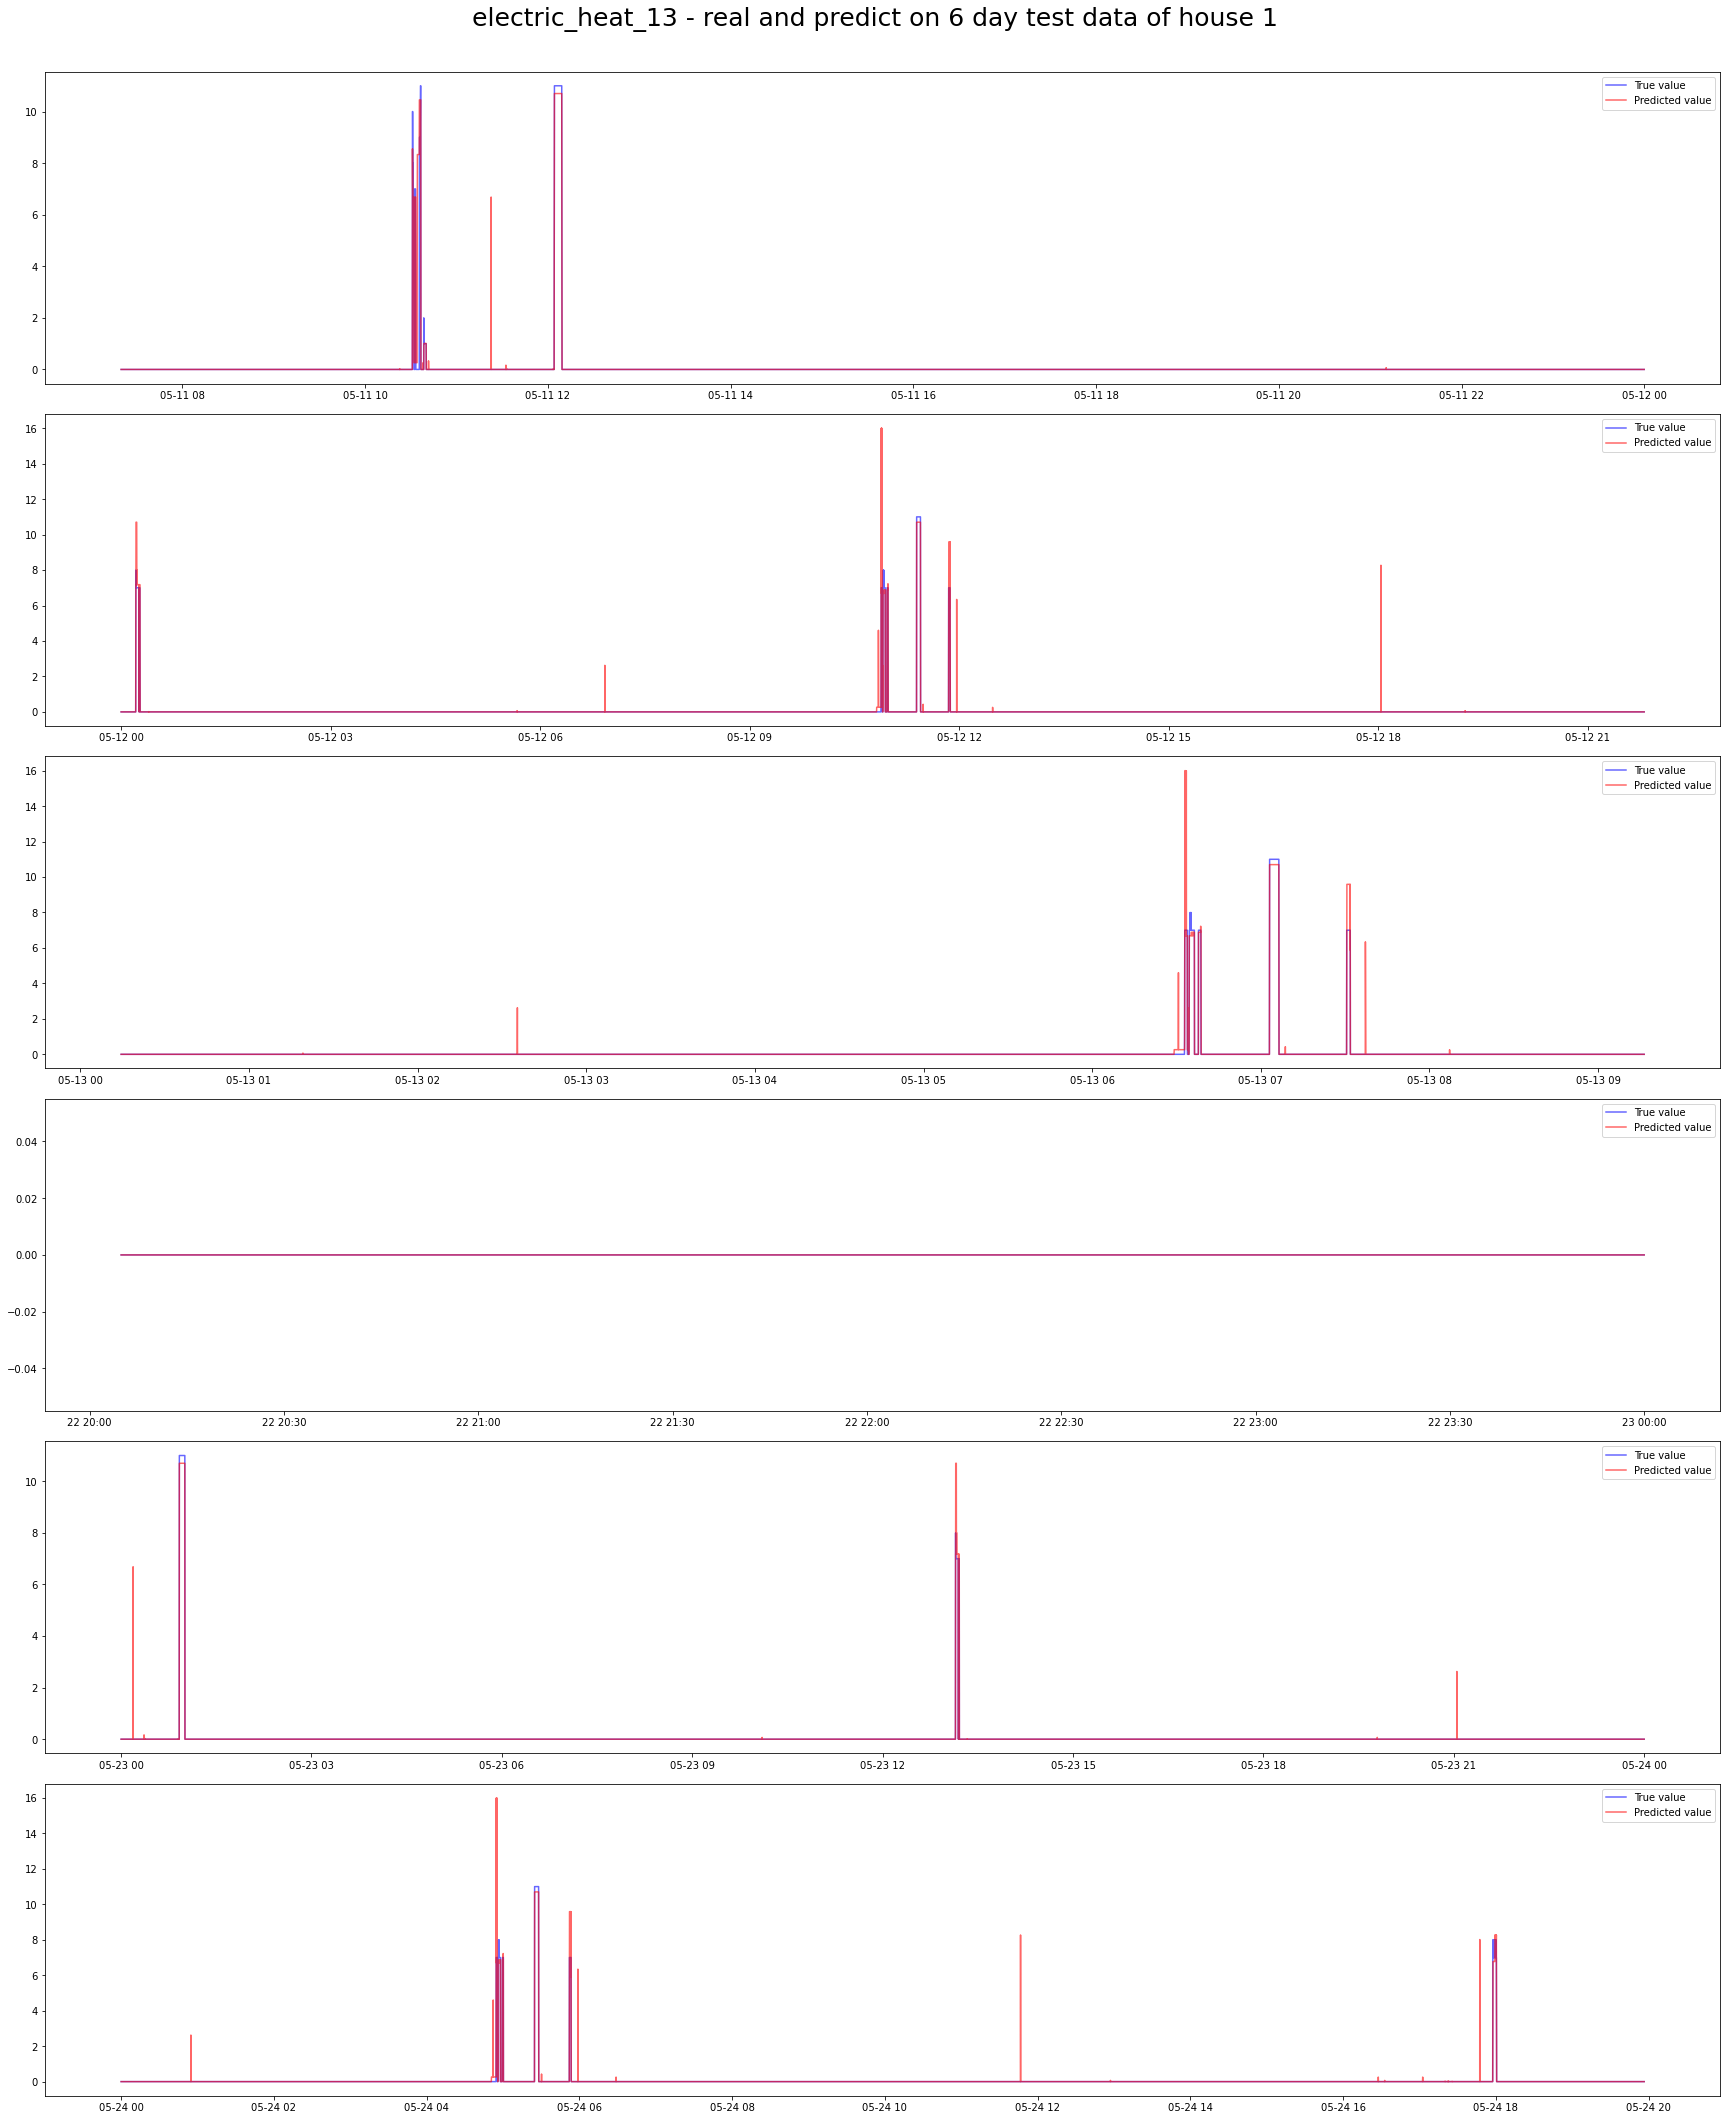

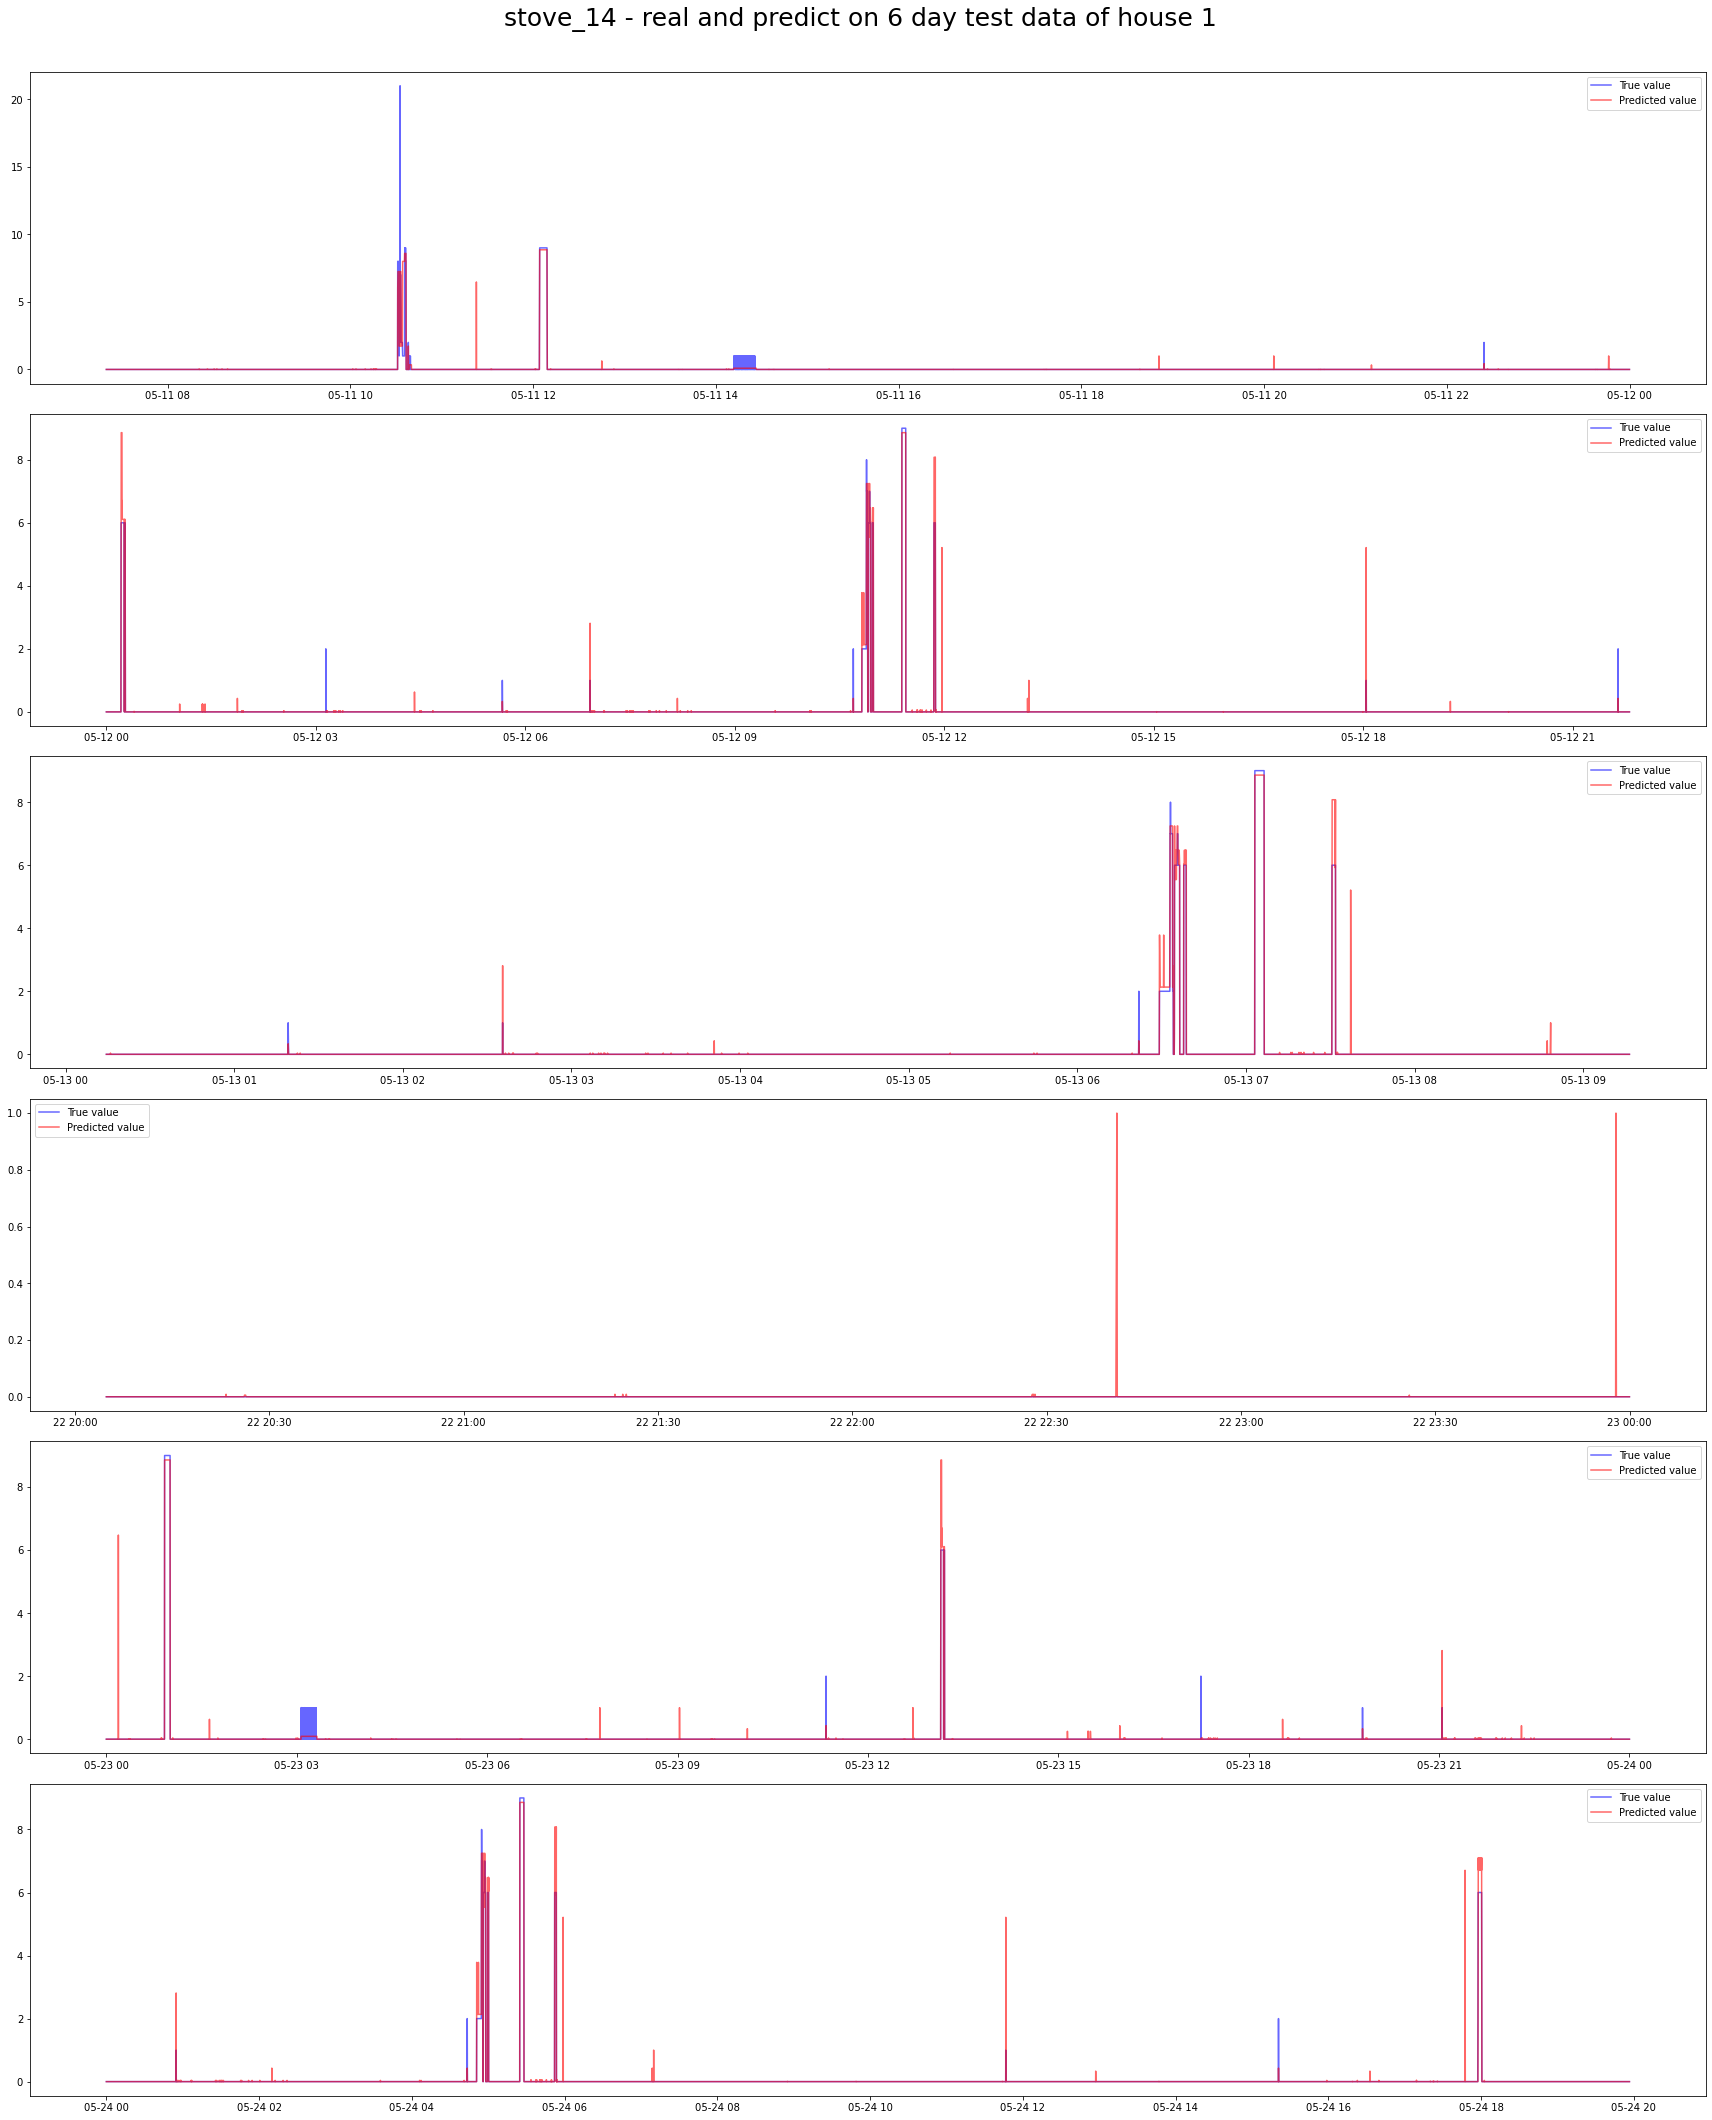

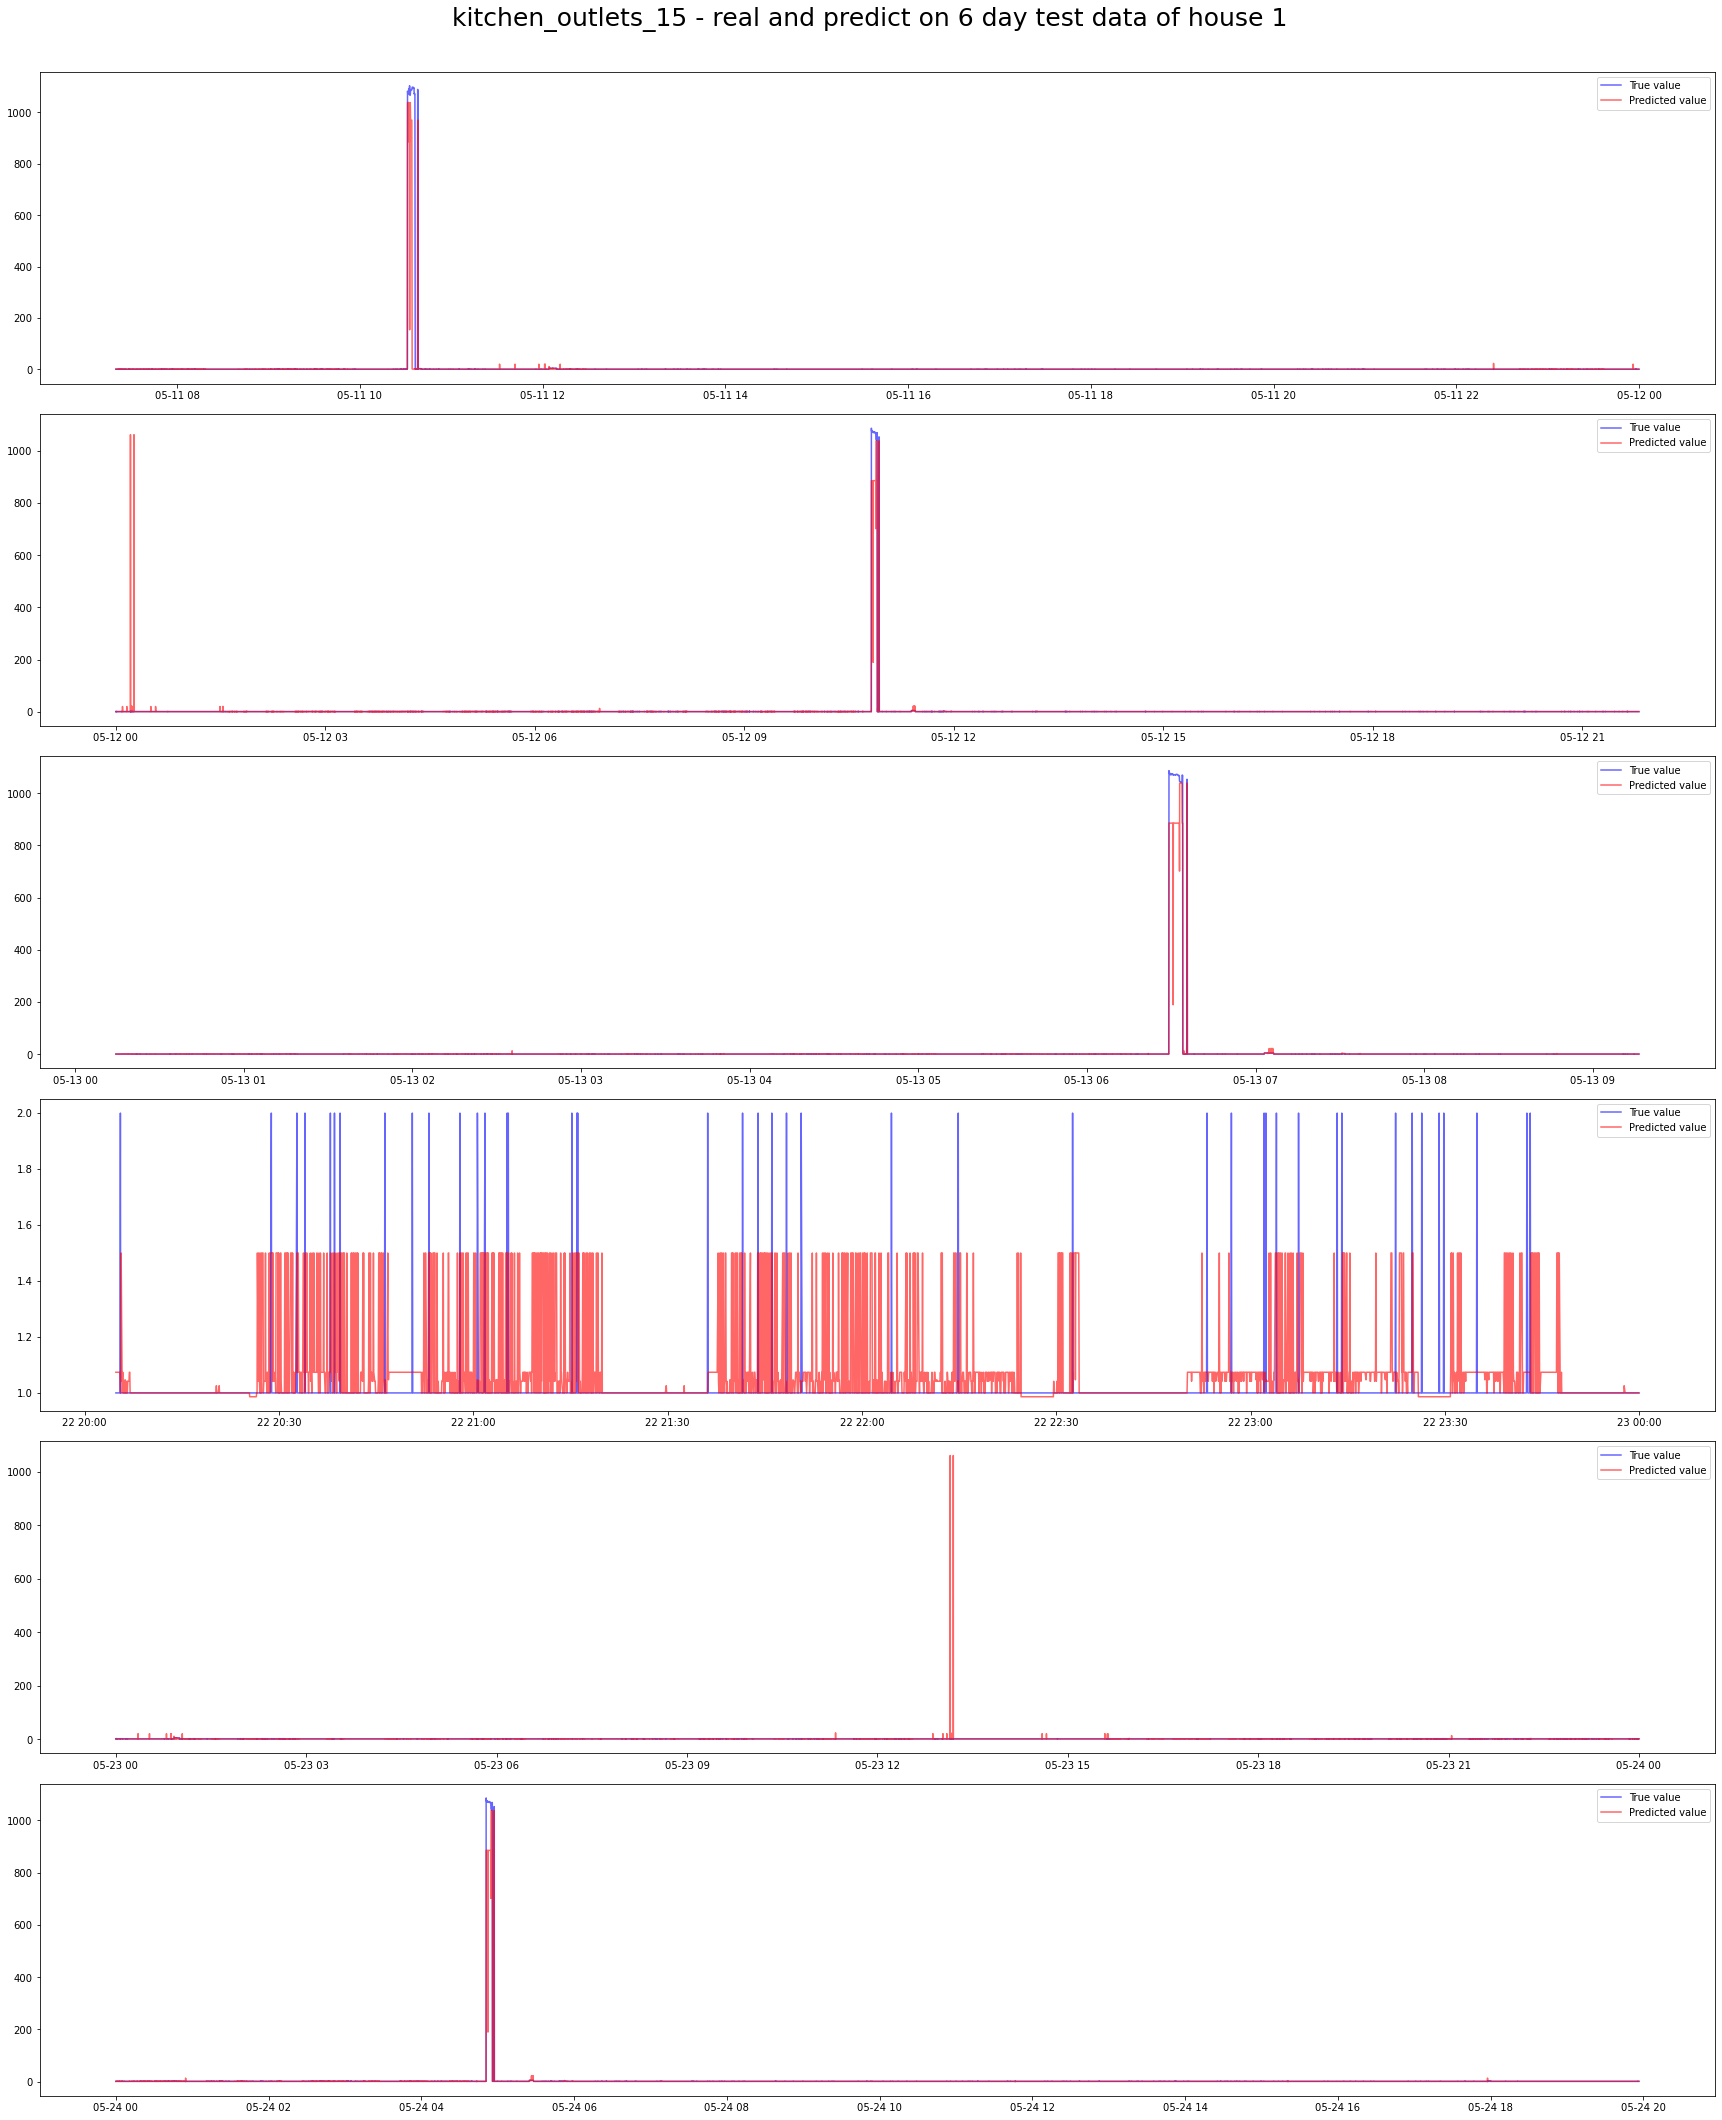

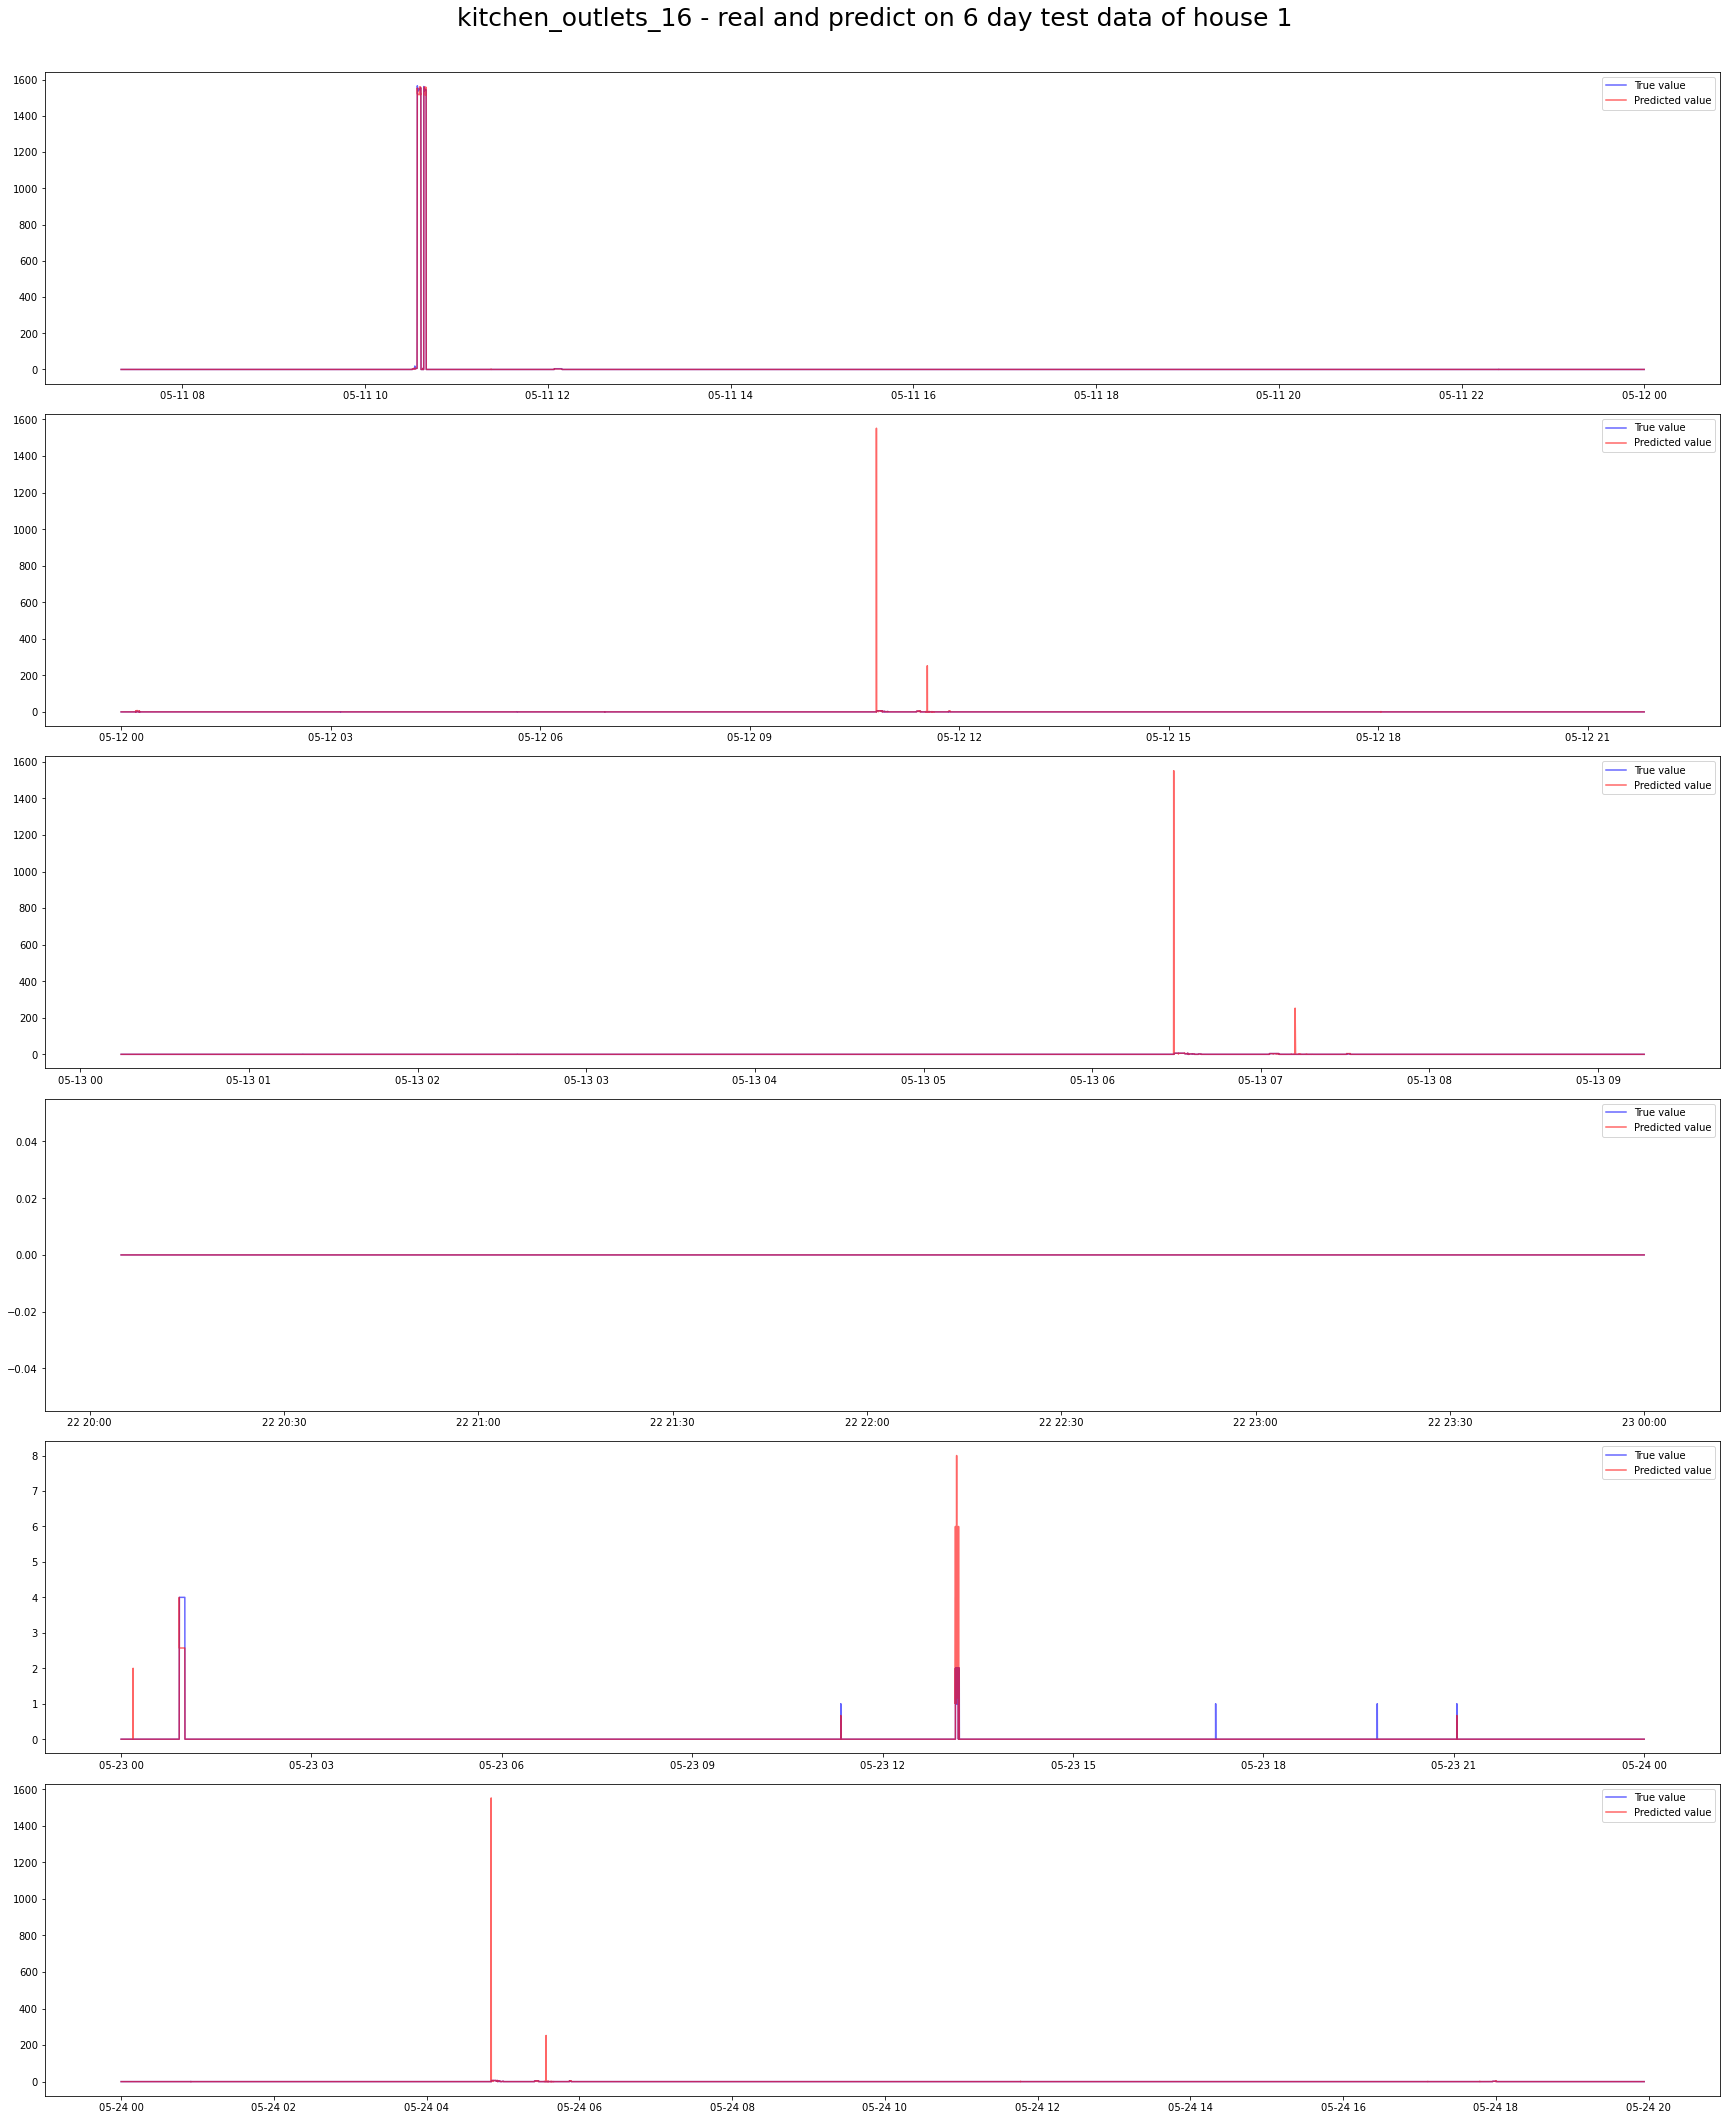

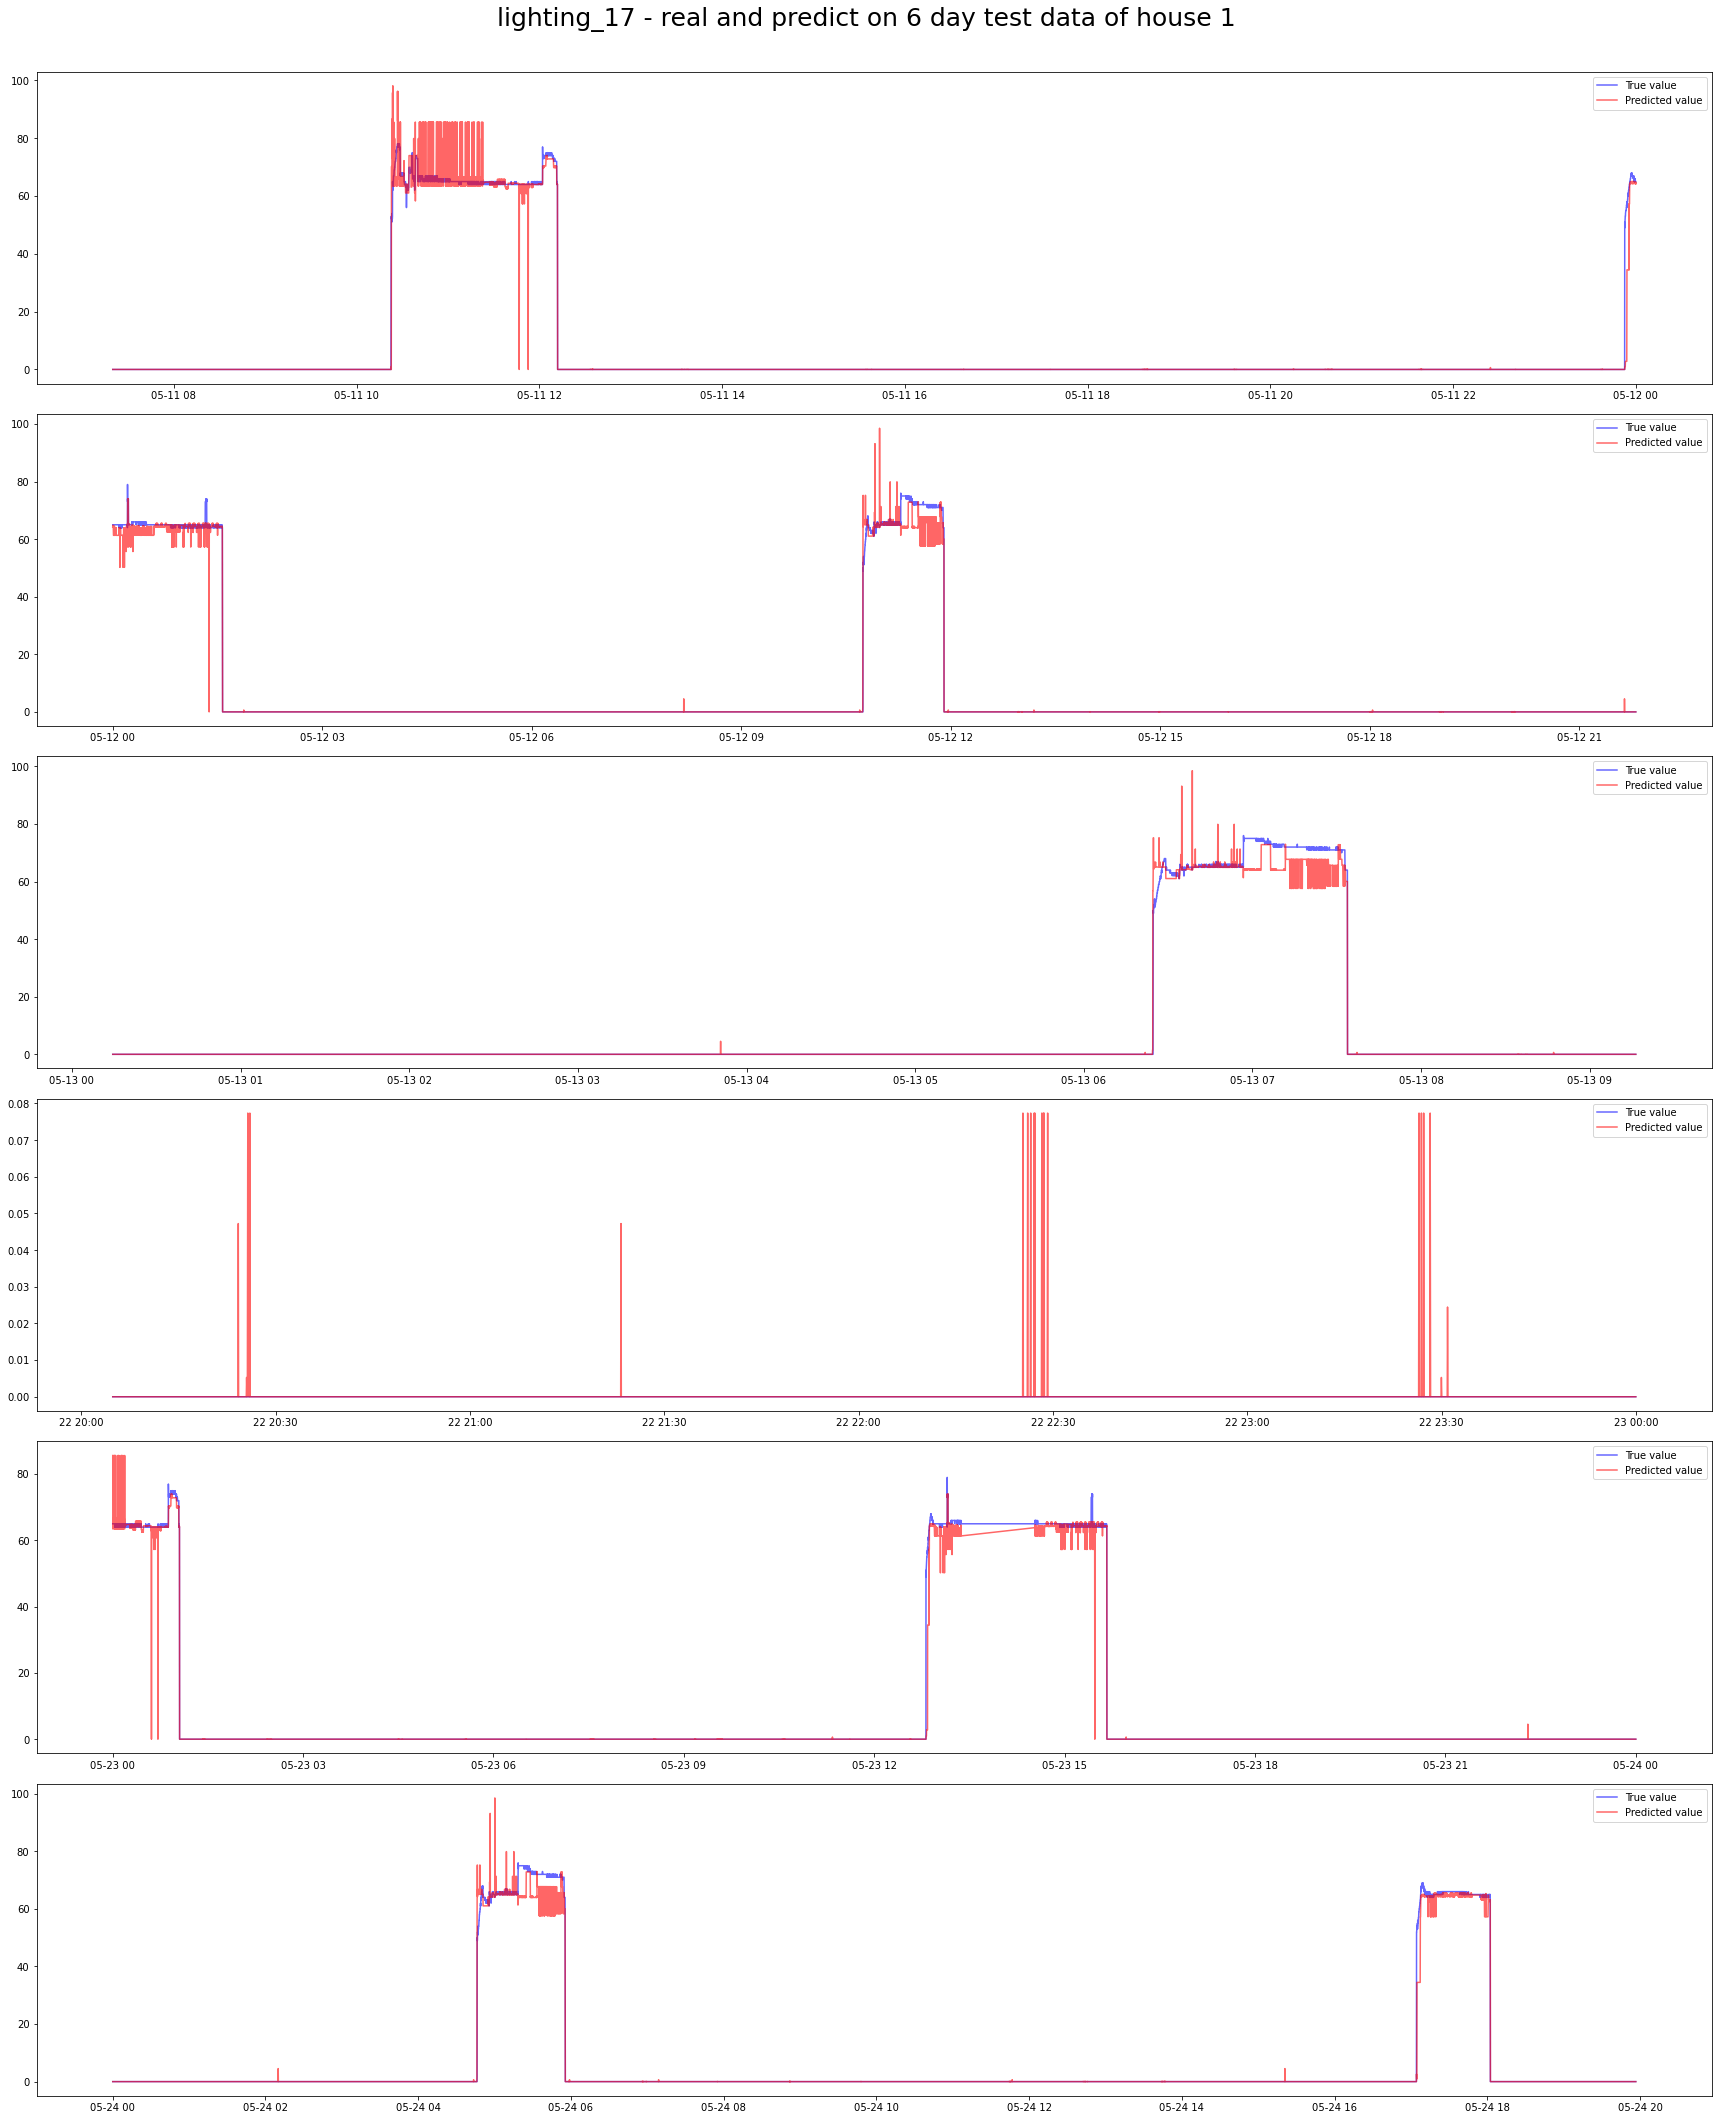

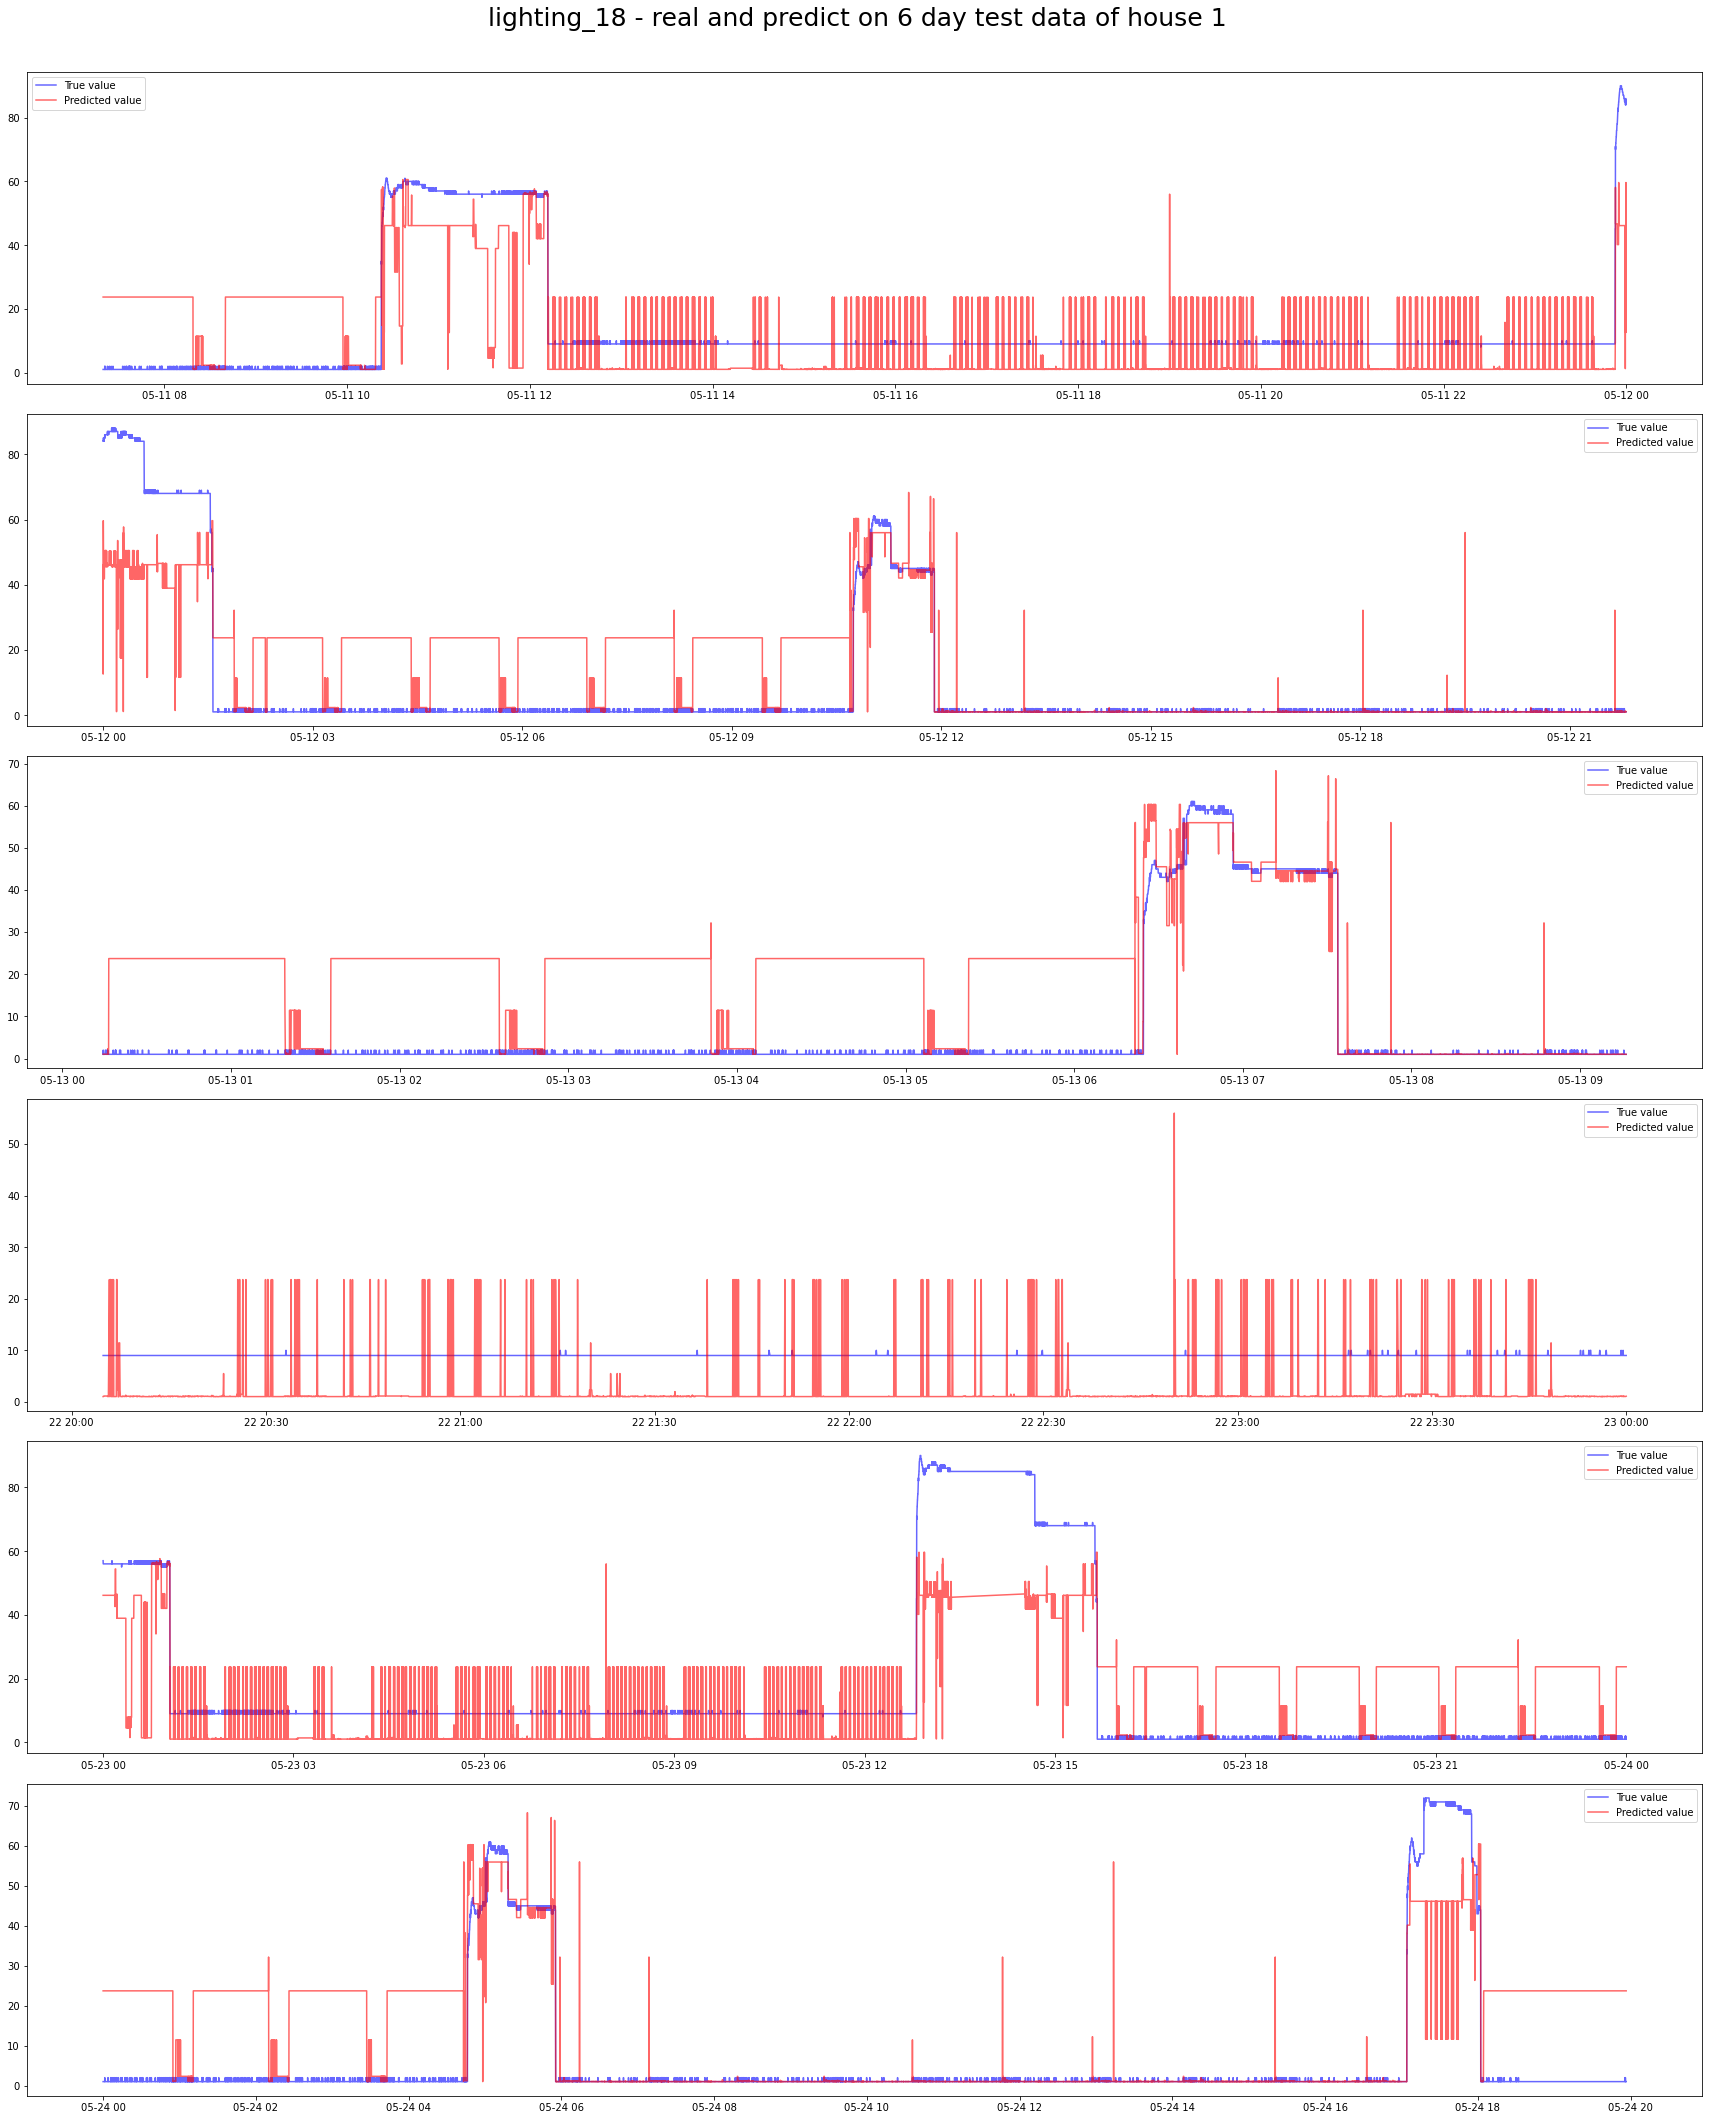

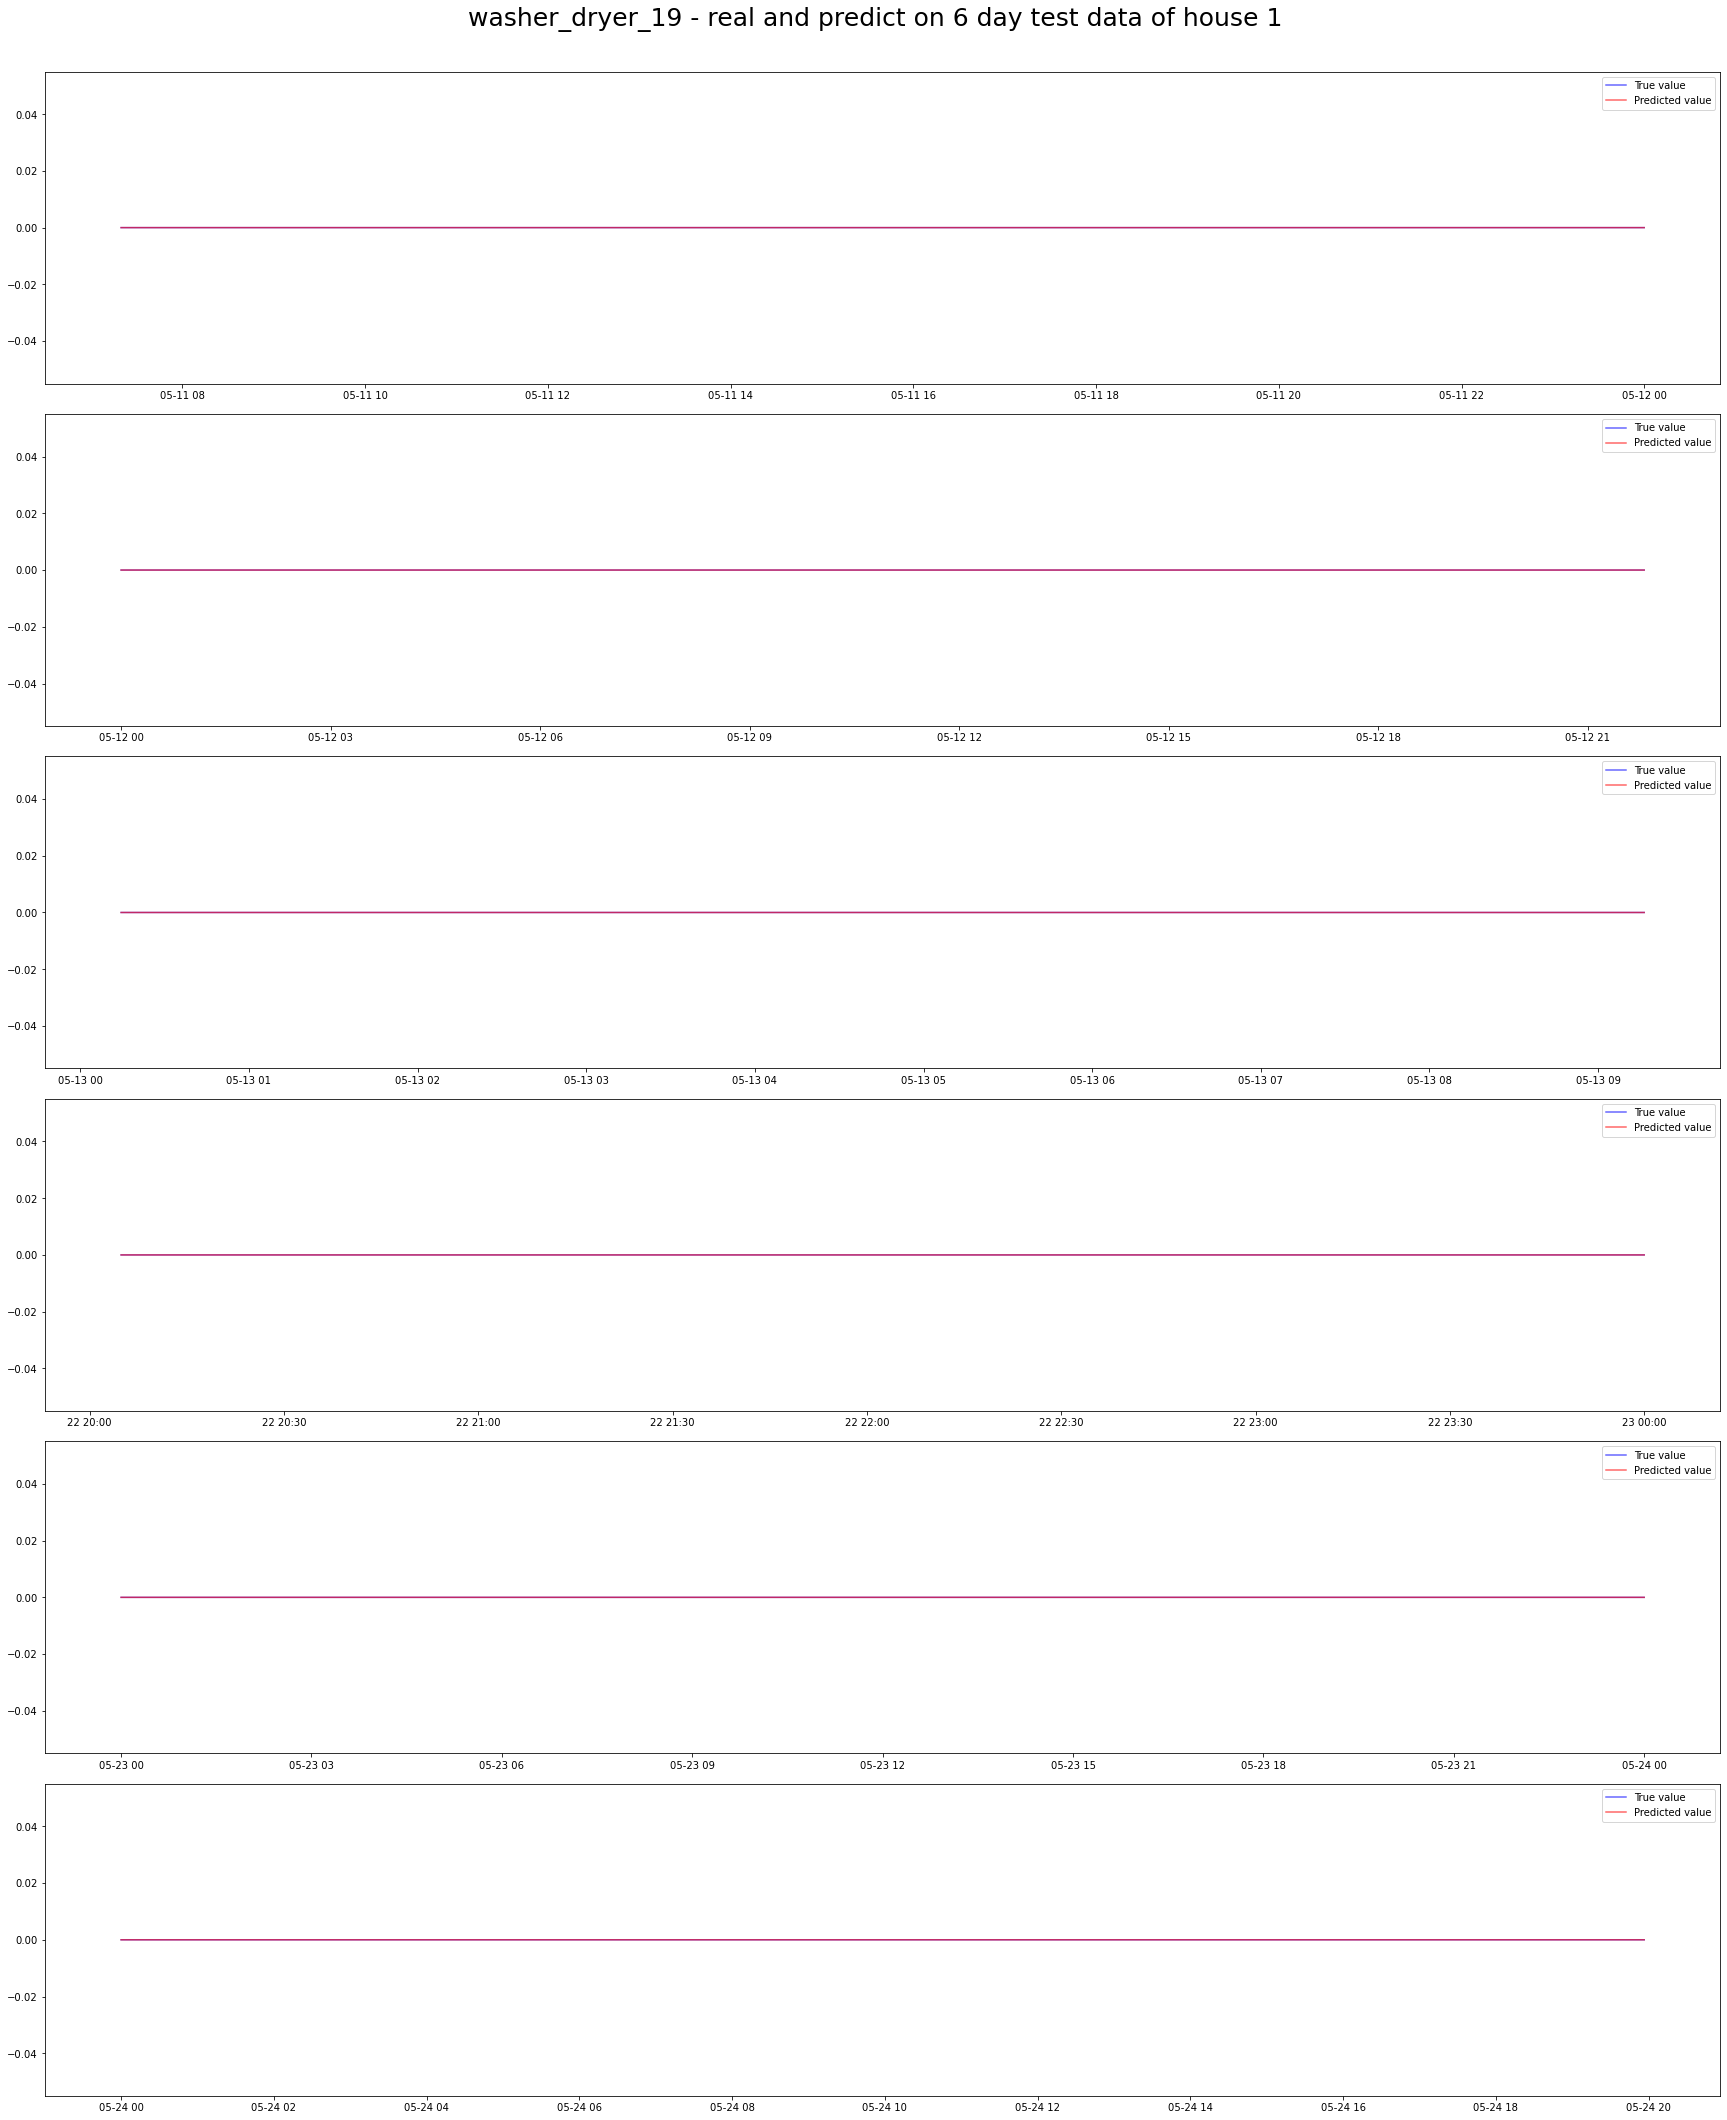

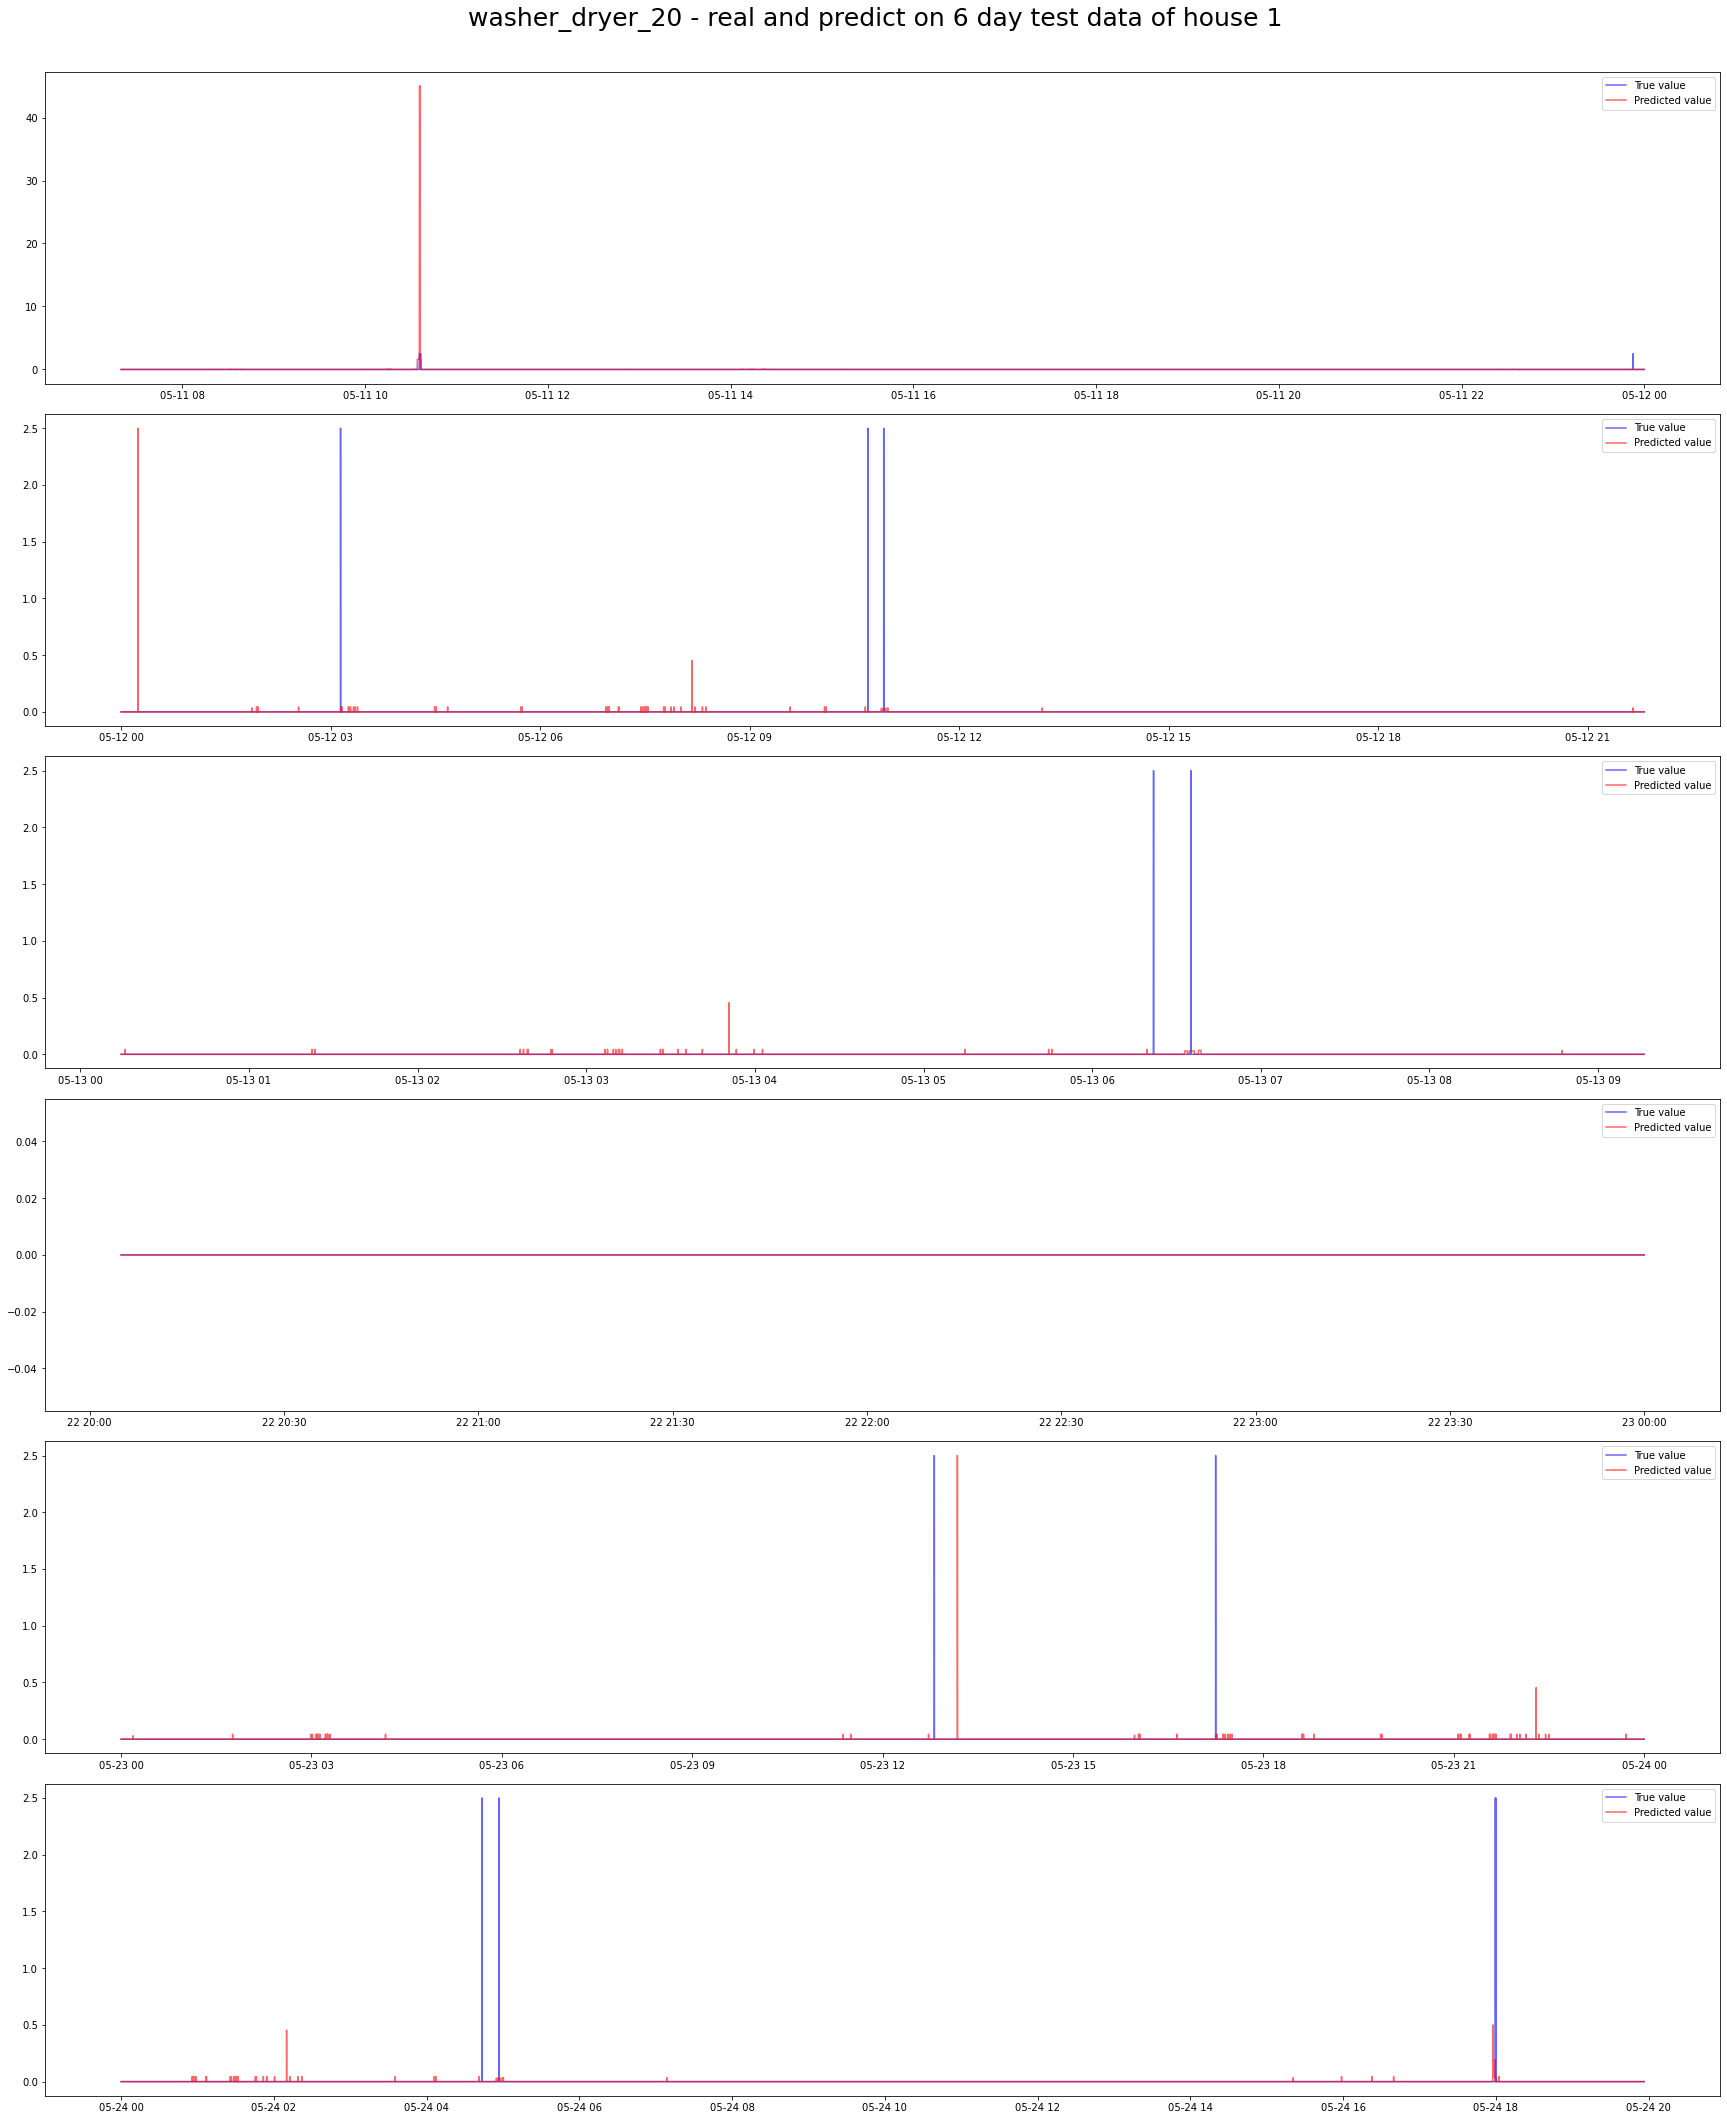

In [42]:
for app in appliances:
    
    plot_each_app(df1_test, dates[1][17:], mul_pred[app], df1_test[app].values, 
                  '{} - real and predict on 6 day test data of house 1'.format(app))

Now, let's try fully connected neural network  
For faster implementation, we use keras API with TensorFlow backend

In [43]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from keras.regularizers import l2

In [44]:
def build_fc_model(layers):
    fc_model = Sequential() #Crea un objeto vacio que contendra el modelo
    for i in range(len(layers)-1):
        #print(f'input_dim = {layers[i]}')
        #print(f'output_dim = {layers[i+1]}')
        
        #Para evitar problemas defina los valores de las neuronas por fuera de Dense
        output_dim = layers[i+1]
        input_dim = layers[i]
        fc_model.add(Dense(output_dim, input_dim = input_dim)) #, W_regularizer=l2(0.1)) )
        #fc_model.add( Dense( output_dim= layers[i+1], input_dim=layers[i]))       
        fc_model.add( Dropout(0.5) )
        if i < (len(layers) - 2):
            fc_model.add( Activation('relu') )
    fc_model.summary()
    
    return fc_model

fc_model_1 = build_fc_model([2, 256, 512, 1024, 1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               768       
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              5

In [45]:
adam = Adam(lr = 1e-5) #Optimizador con learnig de 1e-5
fc_model_1.compile(loss='mean_squared_error', optimizer=adam) #Añade el optimizador al modelo
start = time.time() #Contador de tiempo
#Guarda los pesos del entrenamiento en ciertos puntos para continuar el entrenamiento o guardar el modelo
checkpointer = ModelCheckpoint(filepath="./fc_refrig_h1_2.hdf5", verbose=0, save_best_only=True)
hist_fc_1 = fc_model_1.fit( X_train1, y_train1, batch_size=512, verbose=1, epochs=200, validation_split=0.33, callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Epoch 1/200
282/282 [==============================] - 7s 25ms/step - loss: 13018.6348 - val_loss: 9280.8232
Epoch 2/200
282/282 [==============================] - 7s 25ms/step - loss: 12413.6338 - val_loss: 9380.8906
Epoch 3/200
282/282 [==============================] - 7s 25ms/step - loss: 11814.7910 - val_loss: 9379.3447
Epoch 4/200
282/282 [==============================] - 8s 27ms/step - loss: 11646.1660 - val_loss: 9486.6309
Epoch 5/200
282/282 [==============================] - 7s 25ms/step - loss: 11203.4502 - val_loss: 9512.0703
Epoch 6/200
282/282 [==============================] - 7s 26ms/step - loss: 11208.5693 - val_loss: 9517.2949
Epoch 7/200
282/282 [==============================] - 7s 25ms/step - loss: 11081.4951 - val_loss: 9513.0576
Epoch 8/200
282/282 [==============================] - 7s 26ms/step - loss: 10853.9219 - val_loss: 9562.4736
Epoch 9/200
282/282 [==============================] - 8s 27ms/step - loss: 10711.4541 - val_loss: 9545.9297
Epoch 10/200
282/28

282/282 [==============================] - 7s 26ms/step - loss: 8953.9473 - val_loss: 9632.6729
Epoch 77/200
282/282 [==============================] - 7s 27ms/step - loss: 8958.9346 - val_loss: 9605.2734
Epoch 78/200
282/282 [==============================] - 7s 26ms/step - loss: 8948.2168 - val_loss: 9658.8457
Epoch 79/200
282/282 [==============================] - 8s 27ms/step - loss: 8917.1846 - val_loss: 9595.0742
Epoch 80/200
282/282 [==============================] - 8s 27ms/step - loss: 8913.9736 - val_loss: 9552.4082
Epoch 81/200
282/282 [==============================] - 7s 26ms/step - loss: 8910.7725 - val_loss: 9545.7256
Epoch 82/200
282/282 [==============================] - 7s 26ms/step - loss: 8894.4697 - val_loss: 9548.7803
Epoch 83/200
282/282 [==============================] - 7s 26ms/step - loss: 8892.0928 - val_loss: 9513.0986
Epoch 84/200
282/282 [==============================] - 7s 26ms/step - loss: 8927.7842 - val_loss: 9536.1855
Epoch 85/200
282/282 [==========

Epoch 151/200
282/282 [==============================] - 8s 27ms/step - loss: 8533.4219 - val_loss: 9236.6182
Epoch 152/200
282/282 [==============================] - 7s 26ms/step - loss: 8486.3896 - val_loss: 9196.8633
Epoch 153/200
282/282 [==============================] - 8s 27ms/step - loss: 8528.3564 - val_loss: 9188.3477
Epoch 154/200
282/282 [==============================] - 7s 26ms/step - loss: 8538.7568 - val_loss: 9203.6377
Epoch 155/200
282/282 [==============================] - 7s 26ms/step - loss: 8519.7295 - val_loss: 9196.5439
Epoch 156/200
282/282 [==============================] - 7s 27ms/step - loss: 8532.4902 - val_loss: 9210.6104
Epoch 157/200
282/282 [==============================] - 7s 26ms/step - loss: 8543.3682 - val_loss: 9217.2725
Epoch 158/200
282/282 [==============================] - 7s 26ms/step - loss: 8495.7158 - val_loss: 9210.6748
Epoch 159/200
282/282 [==============================] - 7s 26ms/step - loss: 8497.9014 - val_loss: 9214.4902
Epoch 160/

In [46]:
fc_model_1 = load_model('fc_refrig_h1_2.hdf5')
pred_fc_1 = fc_model_1.predict(X_test1).reshape(-1)
mse_loss_fc_1 = mse_loss(pred_fc_1, y_test1)
mae_loss_fc_1 = mae_loss(pred_fc_1, y_test1)
print('Mean square error on test set: ', mse_loss_fc_1)
print('Mean absolute error on the test set: ', mae_loss_fc_1)

Mean square error on test set:  9680.06581513062
Mean absolute error on the test set:  51.30821928184018


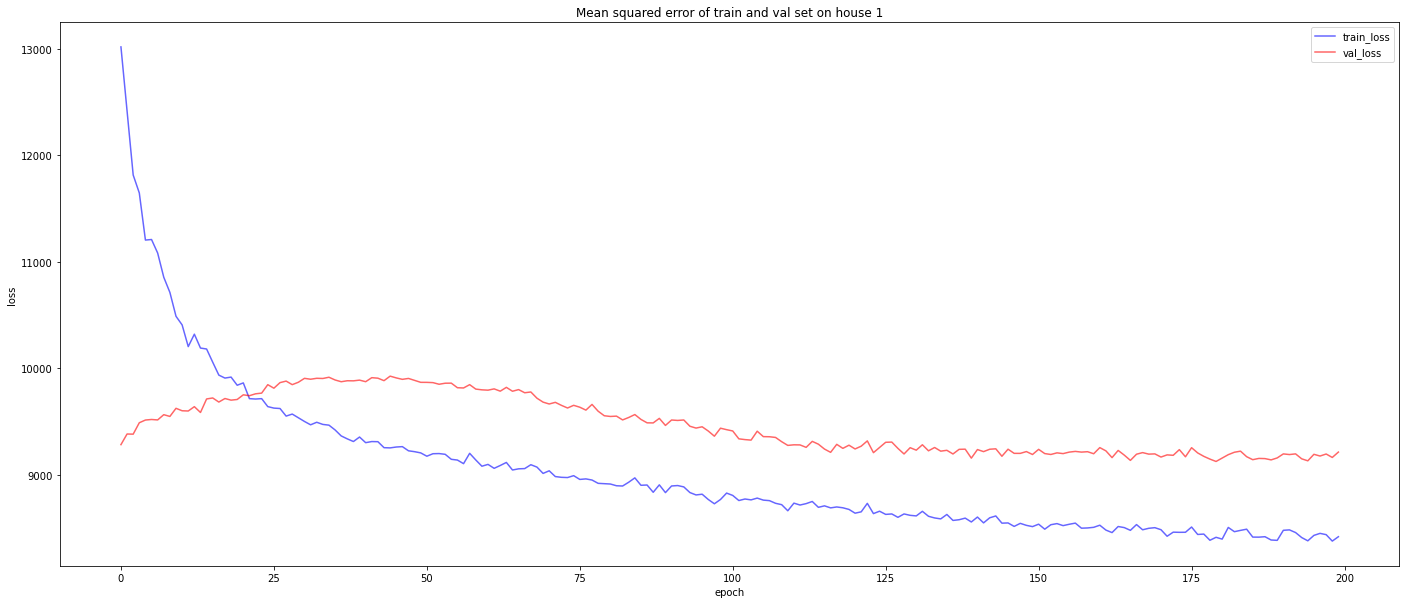

In [47]:
train_loss = hist_fc_1.history['loss']
val_loss = hist_fc_1.history['val_loss']
def plot_losses(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = [24,10]
    plt.title('Mean squared error of train and val set on house 1')
    plt.plot( range(len(train_loss)), train_loss, color = 'b', alpha = 0.6, label='train_loss' )
    plt.plot( range(len( val_loss )), val_loss, color = 'r', alpha = 0.6, label='val_loss' )
    plt.xlabel( 'epoch' )
    plt.ylabel( 'loss' )
    plt.legend()

plot_losses(train_loss, val_loss)

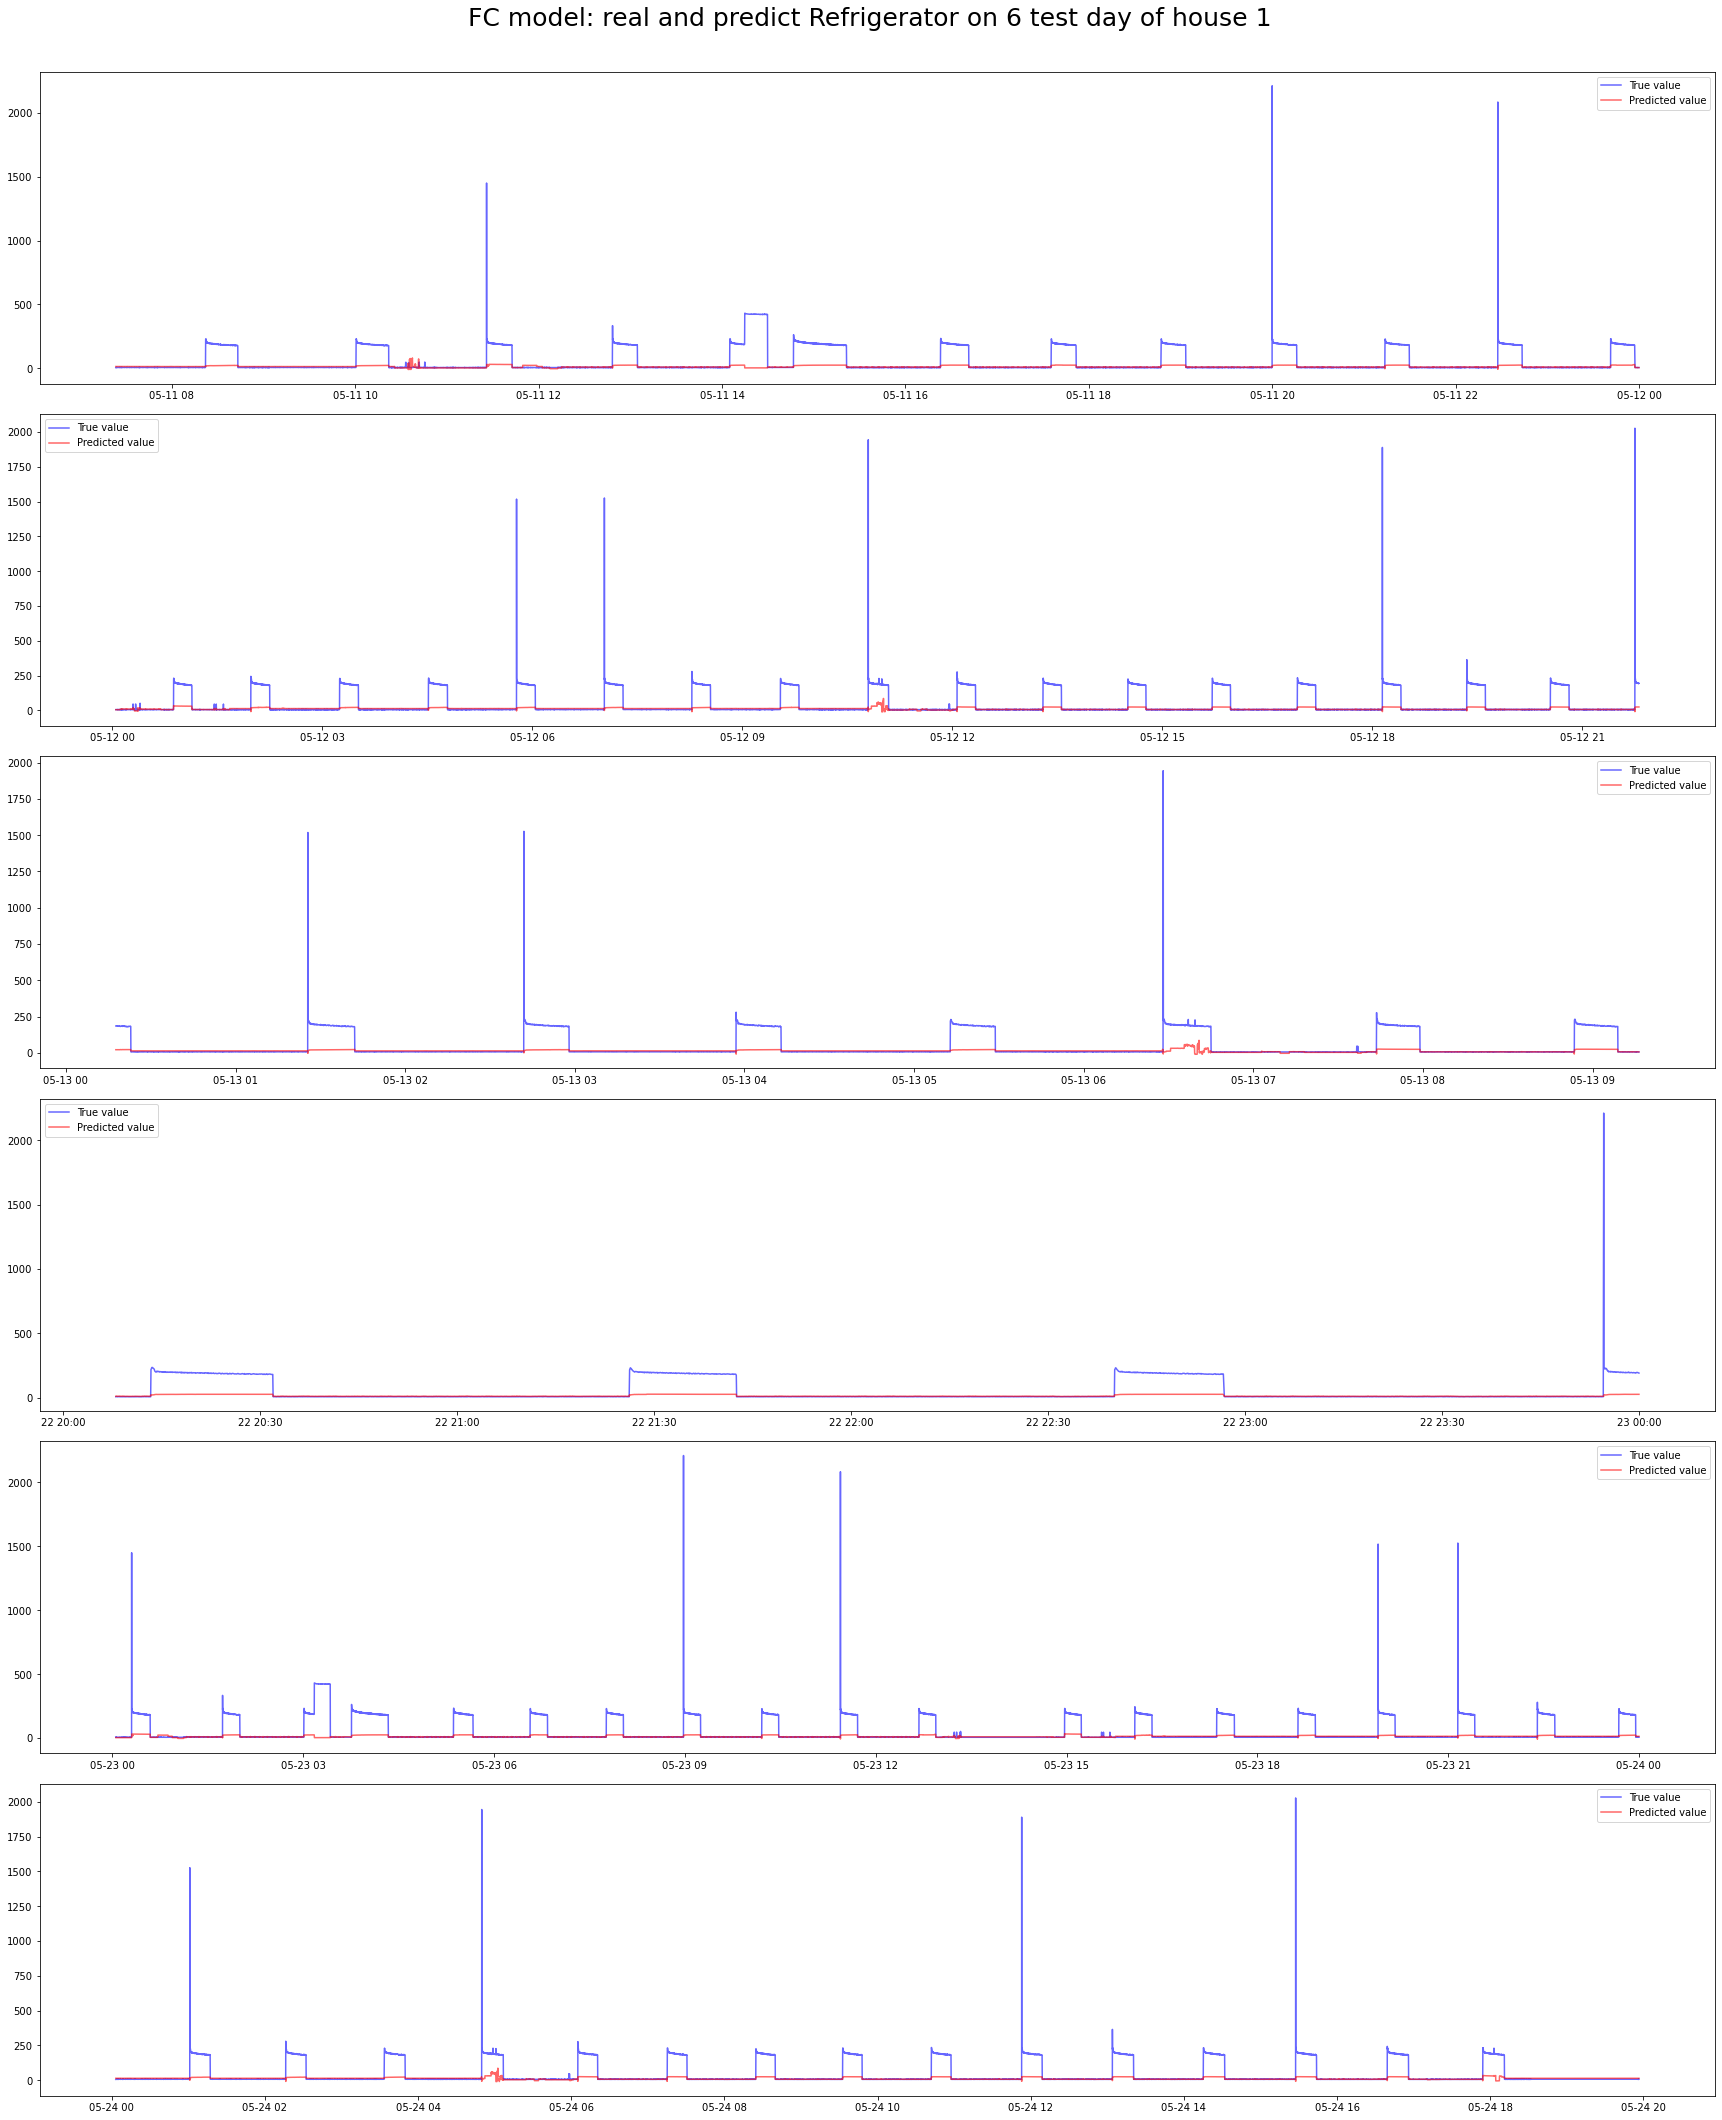

In [48]:
plot_each_app(df1_test, dates[1][17:], pred_fc_1, y_test1, 
              'FC model: real and predict Refrigerator on 6 test day of house 1', look_back = 50)

### Use this model on house 2

In [49]:
y_pred_fc_2 = fc_model_1.predict(X_2).reshape(-1)
mse_fc_2 = mse_loss(y_pred_fc_2, y_2)
mae_fc_2 = mae_loss(y_pred_fc_2, y_2)
print('Mean square error on test set: ', mse_fc_2)
print('Mean absolute error on the test set: ', mae_fc_2)

Mean square error on test set:  13136.235022011542
Mean absolute error on the test set:  75.05230002048677


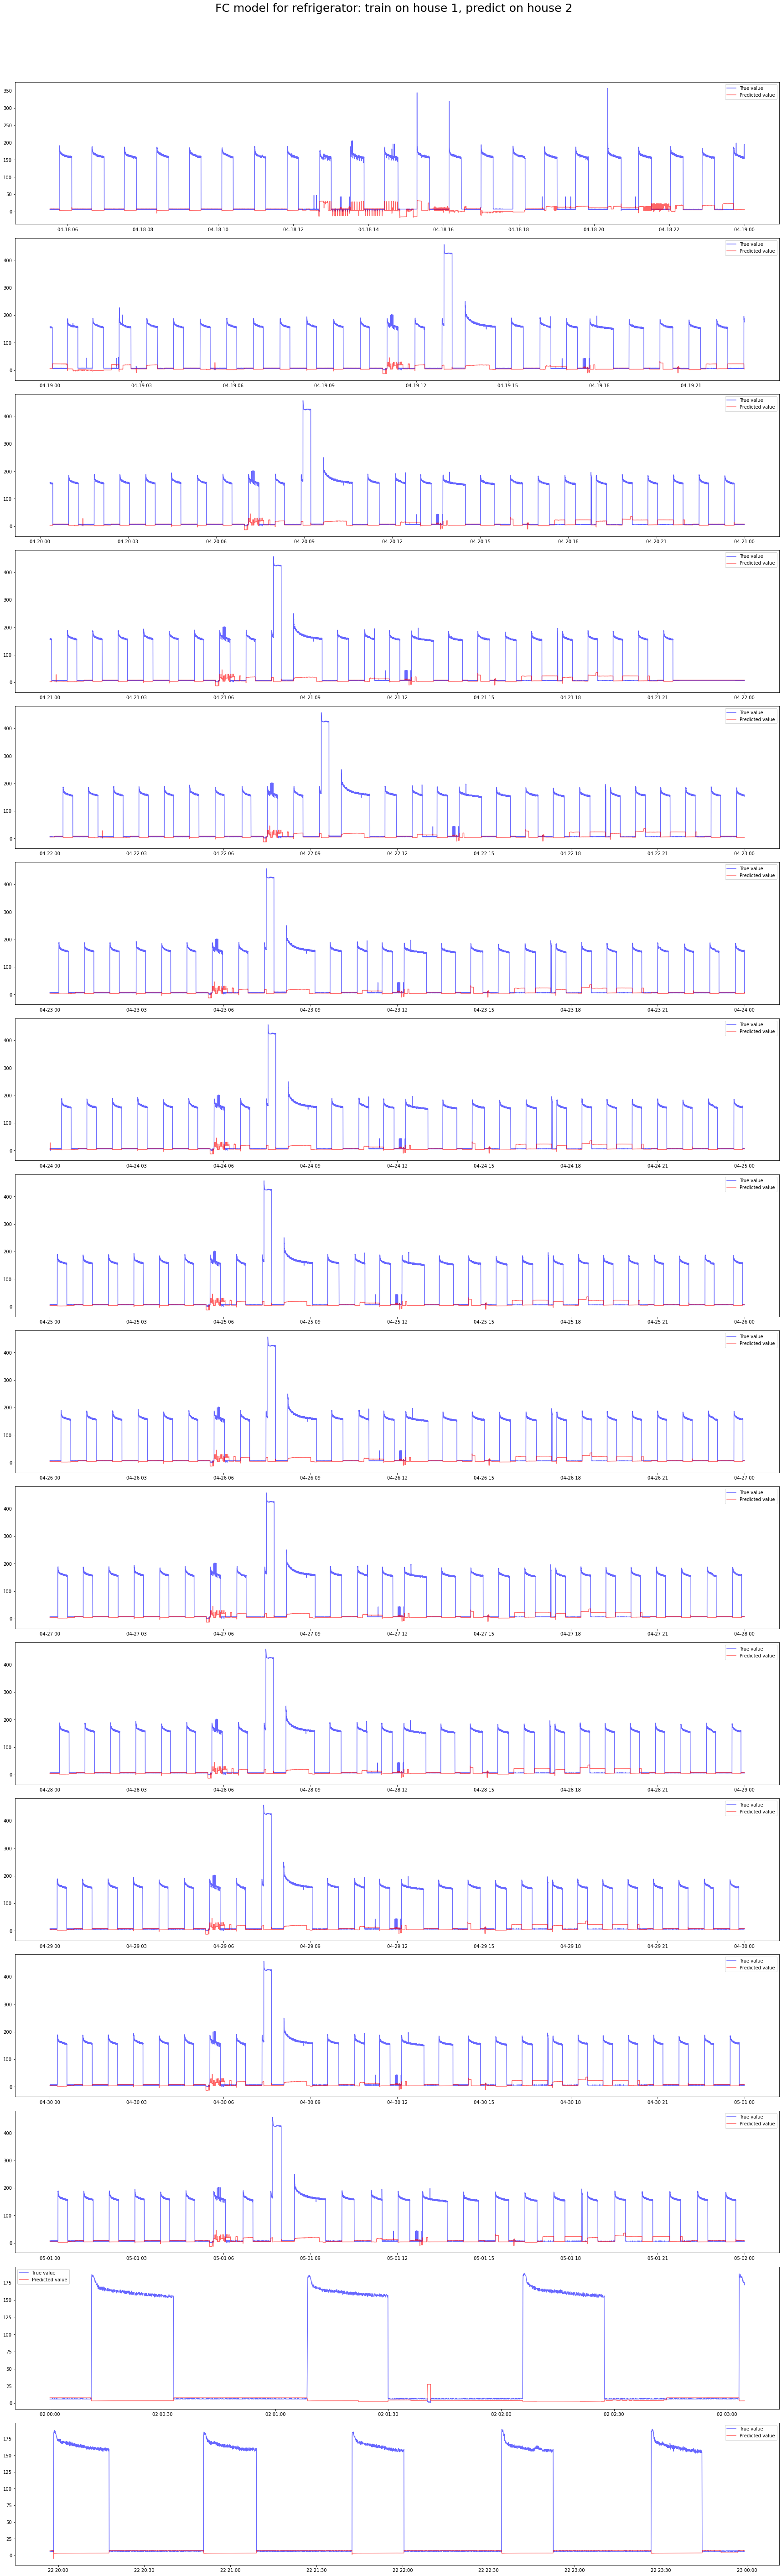

In [50]:
plot_each_app(dfs[2], dates[2], y_pred_fc_2, y_2, 'FC model for refrigerator: train on house 1, predict on house 2')

### Let's use 50 consecutive total consumtions to predict energy consumption of each appliance

In [51]:
def process_data(df, dates, x_features, y_features, look_back = 50):
    i = 0
    for date in dates:
        data = df[date]
        len_data = data.shape[0]
        x = np.array([data[x_features].values[i:i+look_back] 
                      for i in range(len_data - look_back) ]).reshape(-1,look_back, 2)
        y = data[y_features].values[look_back:,:]
        if i == 0:
            X = x
            Y = y
        else:
            X = np.append(X, x, axis=0)
            Y = np.append(Y, y, axis=0)
        i += 1
    return X,Y

In [52]:
start = time.time()
X_train, y_train = process_data(dfs[1], dates[1][:17], ['mains_1','mains_2'], dfs[1].columns.values[2:])
X_test, y_test = process_data(dfs[1], dates[1][17:], ['mains_1','mains_2'], dfs[1].columns.values[2:])
print('Process data time: ', time.time() - start)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Process data time:  873.3380117416382
(318841, 50, 2) (318841, 23) (86757, 50, 2) (86757, 23)


### Let's use fully connected neural network again, but this time we use the past 50 consecutive main values to predict the present value of refrigerator

In [53]:
fc_model = build_fc_model([100, 256, 512, 1024, 1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               25856     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)             

In [54]:
# Let's flatten data to feed into fc model
X_train_fc = X_train.reshape(-1, 100)
y_train_fc = y_train[:,2]
print(X_train_fc.shape, y_train_fc.shape)

(318841, 100) (318841,)


In [57]:
adam = Adam(lr = 1e-5)
fc_model.compile(loss='mean_squared_error', optimizer=adam)
start = time.time()
checkpointer = ModelCheckpoint(filepath="./fc_refrig_h1.hdf5", verbose=0, save_best_only=True)
hist_fc2 = fc_model.fit( X_train_fc, y_train_fc,
                    batch_size=512, verbose=1, epochs= 200,
                    validation_split=0.33, callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Epoch 1/200
418/418 [==============================] - 15s 37ms/step - loss: 288672.8750 - val_loss: 291175.6250
Epoch 2/200
418/418 [==============================] - 13s 32ms/step - loss: 256021.0625 - val_loss: 307584.0312
Epoch 3/200
418/418 [==============================] - 14s 33ms/step - loss: 236280.4844 - val_loss: 300709.1562
Epoch 4/200
418/418 [==============================] - 15s 35ms/step - loss: 220623.5625 - val_loss: 289740.7812
Epoch 5/200
418/418 [==============================] - 15s 35ms/step - loss: 210043.3281 - val_loss: 281652.4688
Epoch 6/200
418/418 [==============================] - 14s 35ms/step - loss: 206445.5469 - val_loss: 270519.6562
Epoch 7/200
418/418 [==============================] - 14s 33ms/step - loss: 198733.0156 - val_loss: 278510.1562
Epoch 8/200
418/418 [==============================] - 14s 34ms/step - loss: 192300.8125 - val_loss: 265823.3438 192108.
Epoch 9/200
418/418 [==============================] - 15s 35ms/step - loss: 190097.6406

Epoch 73/200
418/418 [==============================] - 15s 36ms/step - loss: 158264.3281 - val_loss: 293034.6875
Epoch 74/200
418/418 [==============================] - 14s 34ms/step - loss: 157167.1562 - val_loss: 288202.1250
Epoch 75/200
418/418 [==============================] - 14s 34ms/step - loss: 155397.8594 - val_loss: 296924.0000
Epoch 76/200
418/418 [==============================] - 15s 35ms/step - loss: 157766.4688 - val_loss: 294213.2500
Epoch 77/200
418/418 [==============================] - 15s 36ms/step - loss: 157259.0625 - val_loss: 294895.1562
Epoch 78/200
418/418 [==============================] - 14s 35ms/step - loss: 157295.3594 - val_loss: 296498.4062
Epoch 79/200
418/418 [==============================] - 15s 36ms/step - loss: 154415.0938 - val_loss: 296691.5625
Epoch 80/200
418/418 [==============================] - 14s 34ms/step - loss: 156912.7031 - val_loss: 298465.5938
Epoch 81/200
418/418 [==============================] - 15s 36ms/step - loss: 155581.046

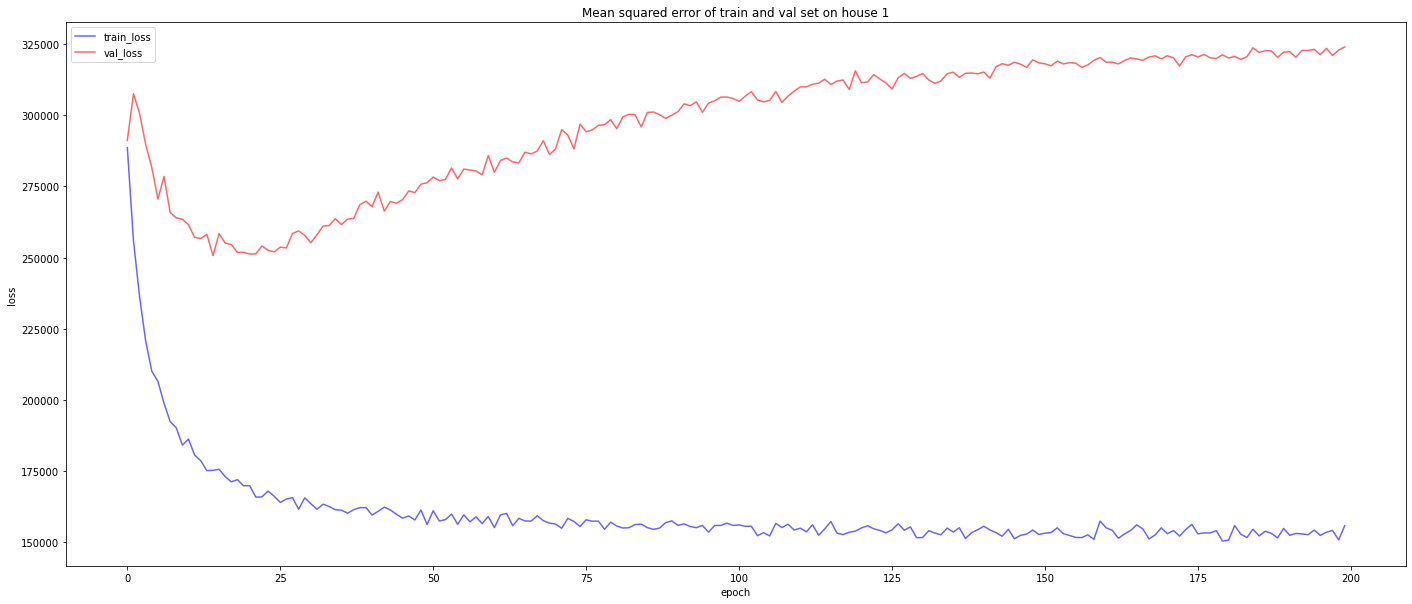

In [58]:
train_loss = hist_fc2.history['loss']
val_loss = hist_fc2.history['val_loss']

plot_losses(train_loss, val_loss)

In [59]:
fc_model = load_model('fc_refrig_h1.hdf5')
pred_fc = fc_model.predict(X_test.reshape(-1, 100)).reshape(-1)
print(pred_fc.shape)

(86757,)


In [60]:
mse_loss_fc = mse_loss(pred_fc, y_test[:,2])
mae_loss_fc = mae_loss(pred_fc, y_test[:,2])
print('Mean square error on test set: ', mse_loss_fc)
print('Mean absolute error on the test set: ', mae_loss_fc)

Mean square error on test set:  256161.06805452725
Mean absolute error on the test set:  222.59434381962458


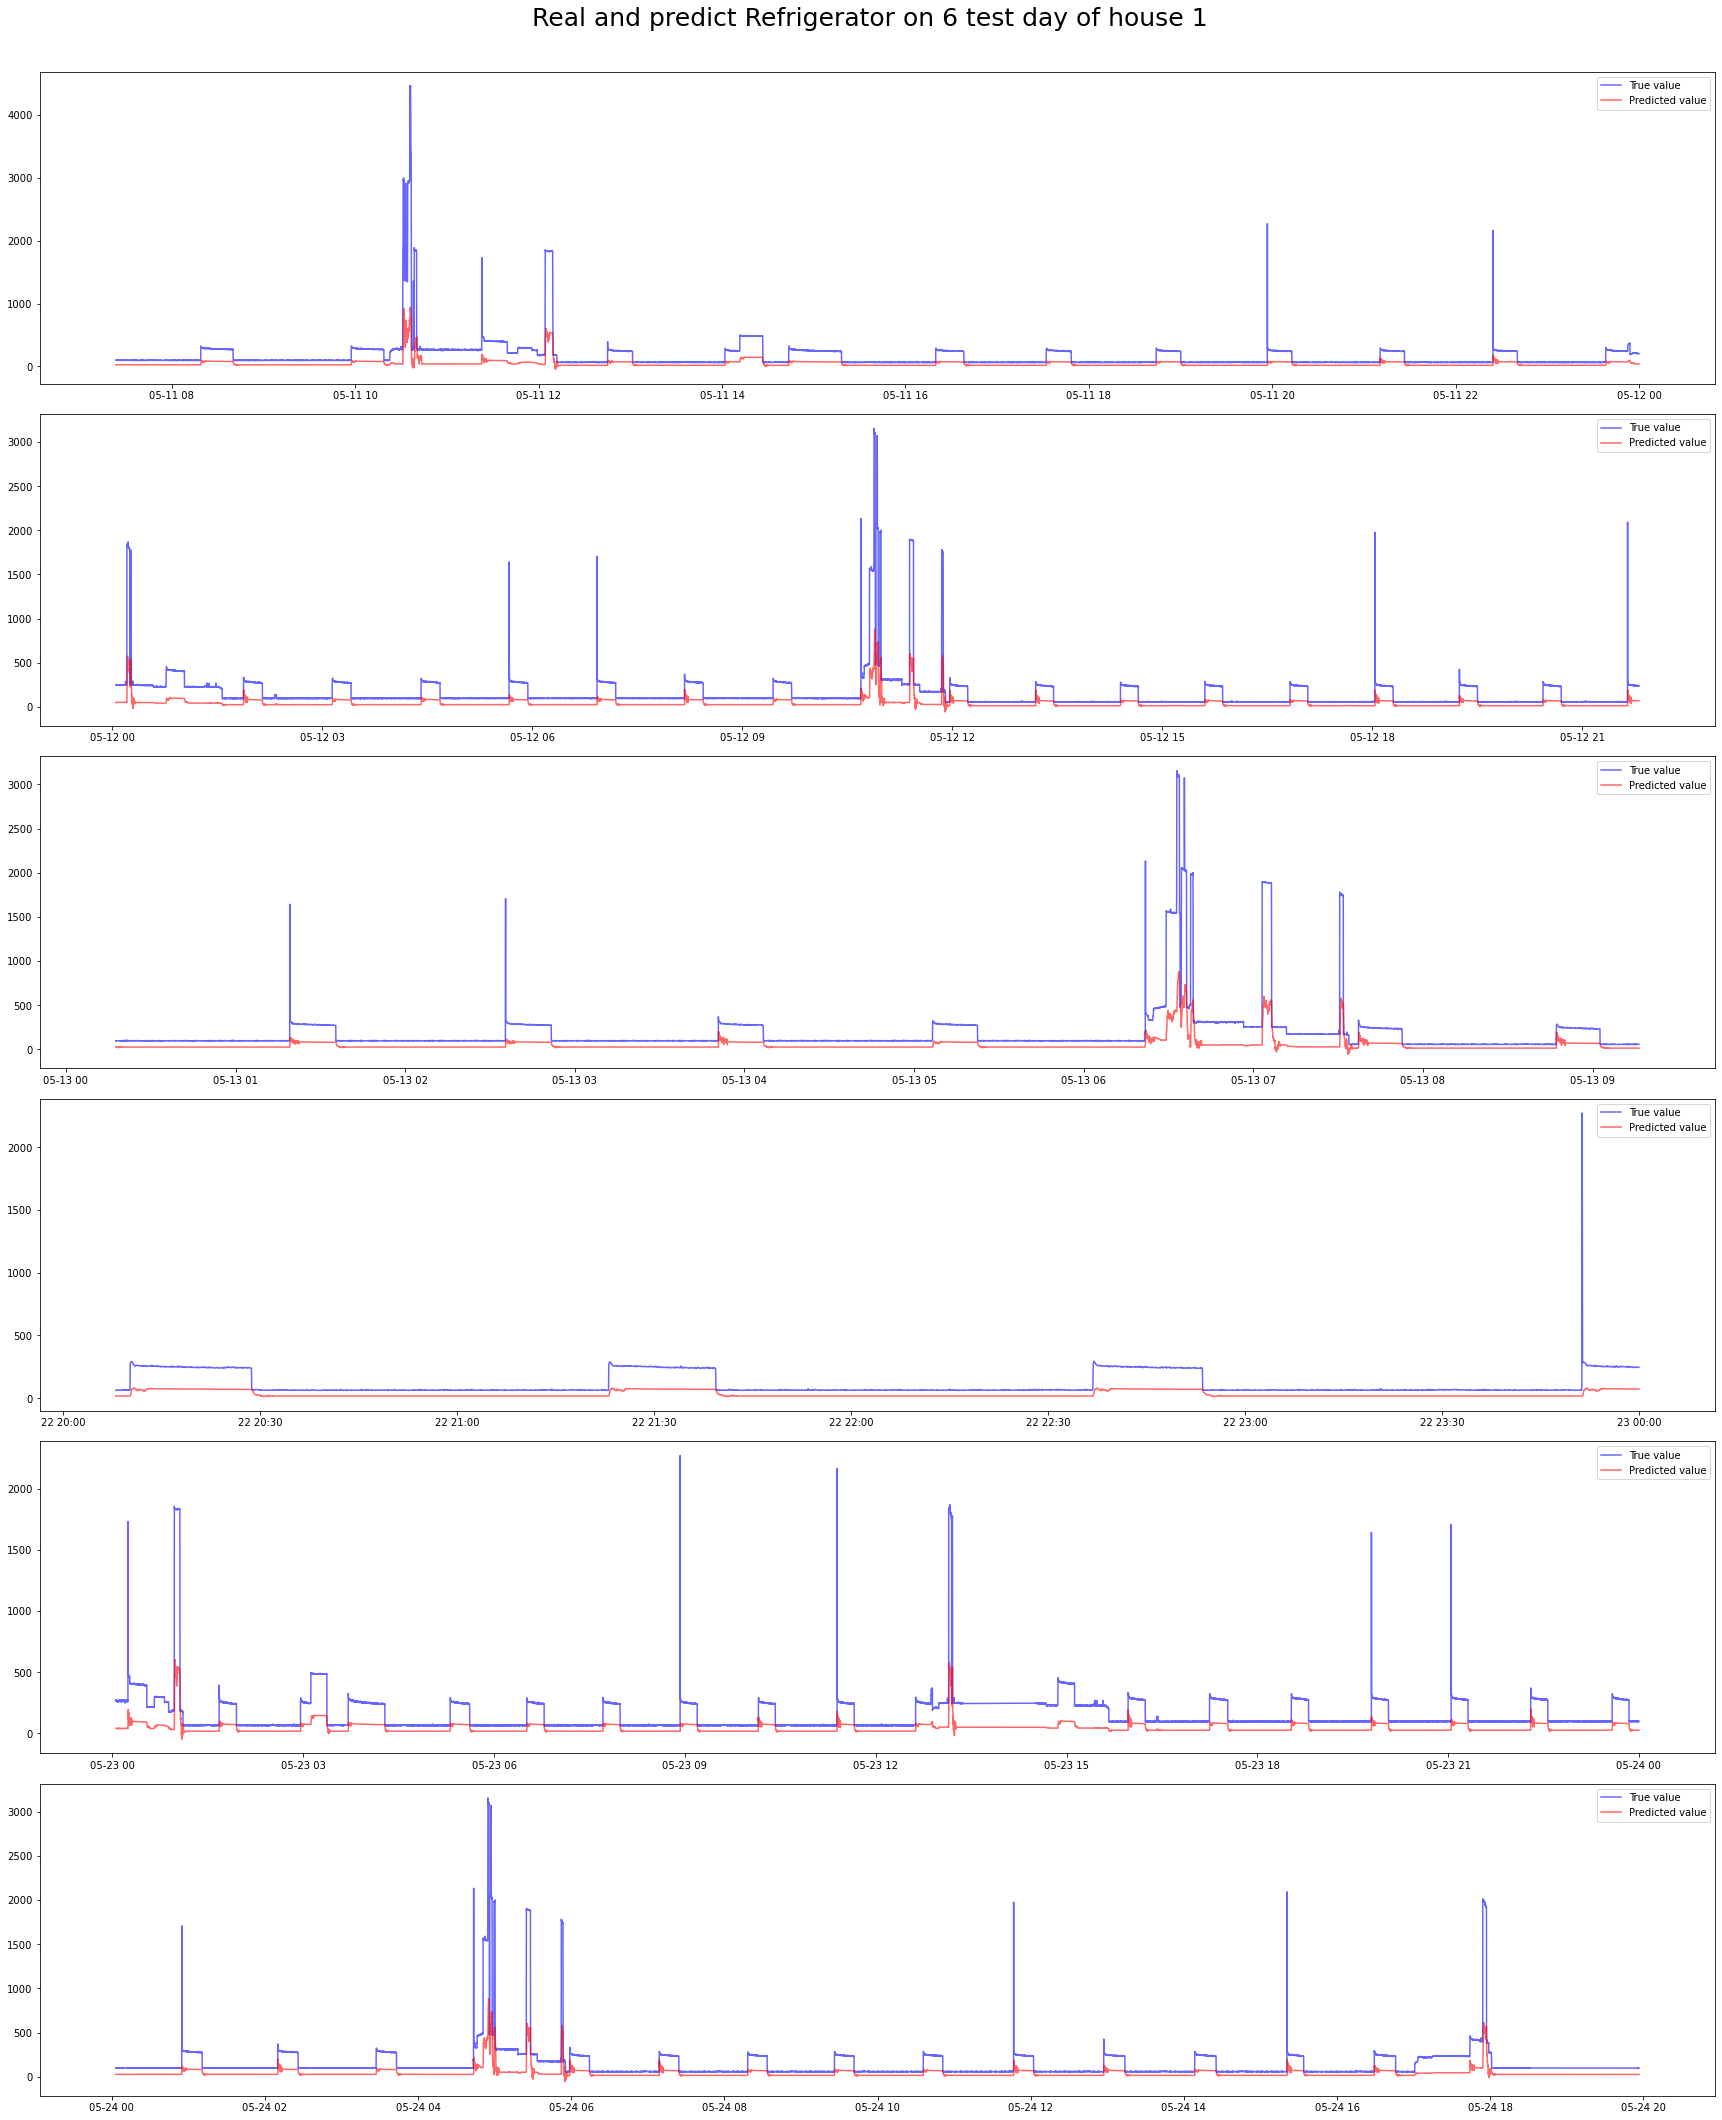

In [61]:
plot_each_app(df1_test, dates[1][17:], pred_fc, y_test[:,2], 
              'Real and predict Refrigerator on 6 test day of house 1', look_back = 50)

### Test on house 2

In [63]:
start = time.time()
X_2, y_2 = process_data(dfs[2], dates[2], ['mains_2','mains_1'], ['refrigerator_9'])
X_2_fc = X_2.reshape(-1, 100)
y_2 = y_2.reshape(-1)
print('Process data time: ', time.time() - start)
print(X_2_fc.shape, y_2.shape)

Process data time:  1305.7678482532501
(316040, 100) (316040,)


In [64]:
pred_fc_50_h2 = fc_model.predict(X_2_fc).reshape(-1)
mse_loss_fc_50_2 = mse_loss(pred_fc_50_h2, y_2)
mae_loss_fc_50_2 = mae_loss(pred_fc_50_h2, y_2)
print('Mean square error on test set: ', mse_loss_fc_50_2)
print('Mean absolute error on the test set: ', mae_loss_fc_50_2)

Mean square error on test set:  7222.949585780016
Mean absolute error on the test set:  53.97085179331166


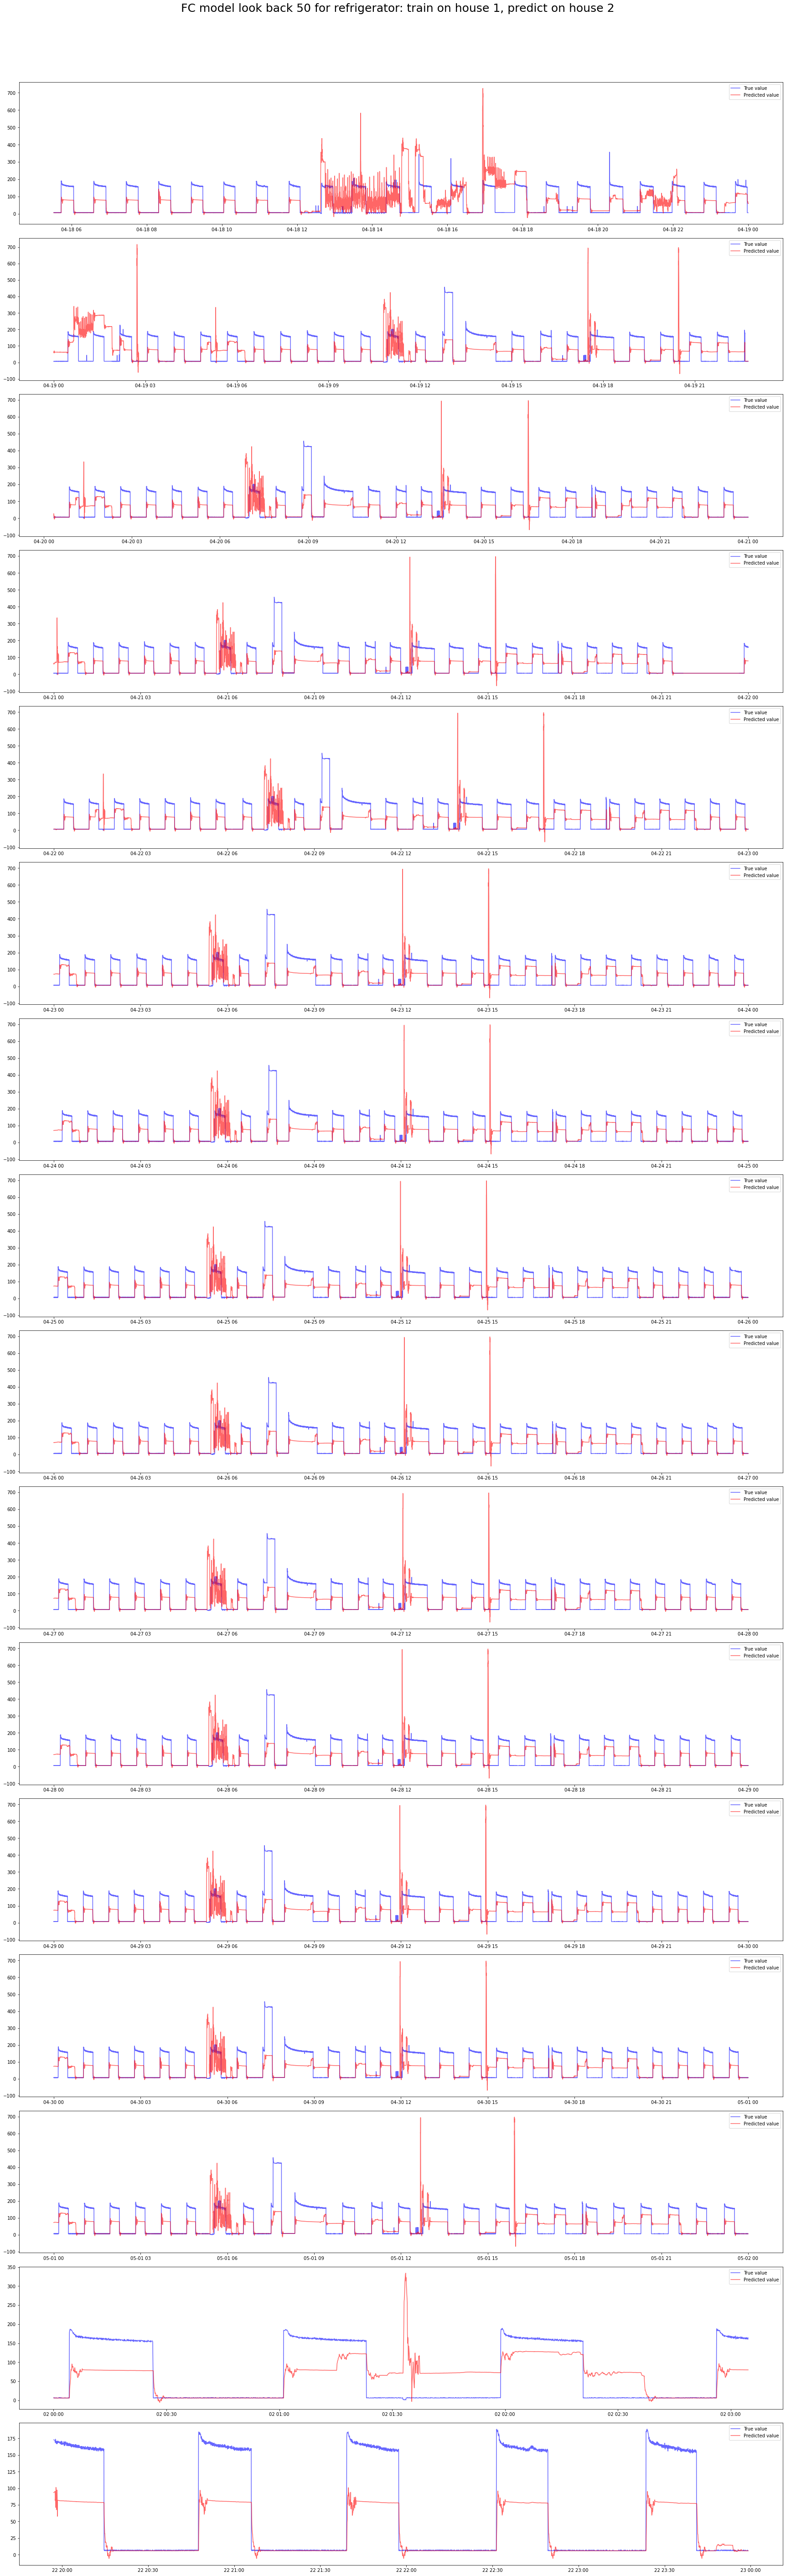

In [66]:
plot_each_app(dfs[2], dates[2], pred_fc_50_h2, y_2, 'FC model look back 50 for refrigerator: train on house 1, predict on house 2')

### Long term short term memory neural network
#### Now we will try a type of recurrent neural network called long term short term memory model¶

In [78]:
def build_lstm_model(layers):
    model = Sequential()
    for i in range(len(layers) - 2):

        model.add(LSTM(
            input_dim=layers[i],
            output_dim=layers[i+1],
            #stateful=True,
            return_sequences= True if i < len(layers) - 3 else False ))
        model.add(Dropout(0.3))
    
    model.add(Dense(layers[-1]))
    model.summary()
    return model

model = build_lstm_model([2,64,128,256, 1])

TypeError: __init__() missing 1 required positional argument: 'units'

In [ ]:

start = time.time()
adam = Adam(lr = 5e-5)
model.compile(loss='mean_squared_error', optimizer=adam)
checkpointer = ModelCheckpoint(filepath="./lstm_model.hdf5", verbose=0, save_best_only=True)
hist_lstm = model.fit(
            X_train,
            y_train[:,2],
            batch_size=512,
            verbose=1,
            epochs=200,
            validation_split=0.3,
            callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

In [ ]:
train_loss = hist_lstm.history['loss']
val_loss = hist_lstm.history['val_loss']

plot_losses(train_loss, val_loss)

In [ ]:
model = load_model('lstm_model.hdf5')
pred_lstm = model.predict(X_test).reshape(-1)
print(pred_lstm.shape)

In [ ]:
mse_loss_lstm = mse_loss(pred_lstm, y_test[:,2])
mae_loss_lstm = mae_loss(pred_lstm, y_test[:,2])
print('Mean square error on test set: ', mse_loss_lstm)
print('Mean absolute error on the test set: ', mae_loss_lstm)

In [ ]:
plot_each_app(df1_test, dates[1][17:], pred_lstm, y_test[:,2], 
              'Real and predict Refrigerator on 6 test day of house 1', look_back = 50)

## Test LST model on house 2

In [ ]:
pred_lstm_h2 = model.predict(X_2).reshape(-1)
mse_loss_lstm_h2 = mse_loss(pred_lstm_h2, y_2)
mae_loss_lstm_h2 = mae_loss(pred_lstm_h2, y_2)
print('Mean square error on test set: ', mse_loss_lstm_h2)
print('Mean absolute error on the test set: ', mae_loss_lstm_h2)

In [ ]:
plot_each_app(df[2], dates[2], pred_lstm_h2, y_2, 
              'Real and predict Refrigerator on 6 test day of house 2', look_back = 50)